## Imports

In [1]:
import pandas as pd
import os
import re
import ast
from tqdm import tqdm
from hdbscan import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, Birch, KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

---

### Read in Data

In [2]:
for (dirpath, dirnames, filenames) in os.walk('../Data/recipes/'):
    break

In [3]:
len(filenames)

31

In [4]:
filenames.remove('.DS_Store')

In [5]:
df = pd.DataFrame()
for i in filenames:
    new_df = pd.read_csv('../Data/recipes/' + i)
    df = pd.concat([df, new_df], axis=0, ignore_index=True)

In [6]:
# Save complete dataframe as new file
df.to_csv('../Ignore/complete_brewtoad_recipes.csv')

---

## EDA

In [7]:
df.head()

Unnamed: 0    ABV     FG  IBU     OG  SRM  boil_time boil_time_units  \
0           0  0.055  1.012   36  1.054    4        105             min   
1           1  0.060  1.014   15  1.060    4         60             min   
2           2  0.052  1.016   26  1.056    6         60             min   
3           3  0.051  1.014   57  1.053    5         60             min   
4           4  0.111  1.030  146  1.115   57         90             min   

                                              extras  \
0                                                  0   
1  {0: {'amount': 1.0, 'amount_unit': 'oz', 'name...   
2                                                  0   
3                                                  0   
4  {0: {'amount': 32.0, 'amount_unit': 'oz', 'nam...   

                                        fermentables  \
0  {0: {'amount': 5.0, 'amount_unit': 'lb', 'name...   
1  {0: {'amount': 20.0, 'amount_unit': 'lb', 'nam...   
2  {0: {'amount': 6.0, 'amount_unit': 'lb', 'name...   
3  {0: {'amount': 10.0, 'amount_unit': 'lb', 'nam...   
4  {0: {'amount': 14.0, 'amount_unit': 'lb', 'nam...   

                                                hops  \
0  {0: {'amount': 0.25, 'amount_unit': 'oz', 'nam...   
1  {0: {'amount': 3.0, 'amount_unit': 'oz', 'name...   
2  {0: {'amount': 1.5, 'amount_unit': 'oz', 'name...   
3  {0: {'amount': 0.5, 'amount_unit': 'oz', 'name...   
4  {0: {'amount': 2.0, 'amount_unit': 'oz', 'name...   

                                                link  meets_guidelines  \
0  http://www.brewtoad.com/recipes/frances-summer...                 0   
1       http://www.brewtoad.com/recipes/belgian-whit                 0   
2  http://www.brewtoad.com/recipes/russian-german...                 0   
3         http://www.brewtoad.com/recipes/baldy-pale                 0   
4       http://www.brewtoad.com/recipes/danger-stout                 0   

                            name                       style  volume  \
0     Frances' Summer Hair Wheat  American Wheat or Rye Beer    5.26   
1                   Belgian whit                     Witbier   15.00   
2  Russian German American Lager      Premium American Lager    6.30   
3                     Baldy Pale           American Pale Ale    5.50   
4                   Danger Stout      Russian Imperial Stout    5.00   

  volume_units                                              yeast  
0          gal  {0: {'name': 'Safale US-05', 'generic': True, ...  
1          gal  {0: {'name': 'Hefeweizen IV Ale Yeast', 'gener...  
2          gal  {0: {'name': 'Southern German Lager Yeast', 'g...  
3          gal  {0: {'name': 'Safale US-05', 'generic': True, ...  
4          gal  {0: {'name': 'American Ale II', 'generic': Tru...

In [8]:
# Drop redundant index column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
# Check to make sure that it dropped
df.head()

ABV     FG  IBU     OG  SRM  boil_time boil_time_units  \
0  0.055  1.012   36  1.054    4        105             min   
1  0.060  1.014   15  1.060    4         60             min   
2  0.052  1.016   26  1.056    6         60             min   
3  0.051  1.014   57  1.053    5         60             min   
4  0.111  1.030  146  1.115   57         90             min   

                                              extras  \
0                                                  0   
1  {0: {'amount': 1.0, 'amount_unit': 'oz', 'name...   
2                                                  0   
3                                                  0   
4  {0: {'amount': 32.0, 'amount_unit': 'oz', 'nam...   

                                        fermentables  \
0  {0: {'amount': 5.0, 'amount_unit': 'lb', 'name...   
1  {0: {'amount': 20.0, 'amount_unit': 'lb', 'nam...   
2  {0: {'amount': 6.0, 'amount_unit': 'lb', 'name...   
3  {0: {'amount': 10.0, 'amount_unit': 'lb', 'nam...   
4  {0: {'amount': 14.0, 'amount_unit': 'lb', 'nam...   

                                                hops  \
0  {0: {'amount': 0.25, 'amount_unit': 'oz', 'nam...   
1  {0: {'amount': 3.0, 'amount_unit': 'oz', 'name...   
2  {0: {'amount': 1.5, 'amount_unit': 'oz', 'name...   
3  {0: {'amount': 0.5, 'amount_unit': 'oz', 'name...   
4  {0: {'amount': 2.0, 'amount_unit': 'oz', 'name...   

                                                link  meets_guidelines  \
0  http://www.brewtoad.com/recipes/frances-summer...                 0   
1       http://www.brewtoad.com/recipes/belgian-whit                 0   
2  http://www.brewtoad.com/recipes/russian-german...                 0   
3         http://www.brewtoad.com/recipes/baldy-pale                 0   
4       http://www.brewtoad.com/recipes/danger-stout                 0   

                            name                       style  volume  \
0     Frances' Summer Hair Wheat  American Wheat or Rye Beer    5.26   
1                   Belgian whit                     Witbier   15.00   
2  Russian German American Lager      Premium American Lager    6.30   
3                     Baldy Pale           American Pale Ale    5.50   
4                   Danger Stout      Russian Imperial Stout    5.00   

  volume_units                                              yeast  
0          gal  {0: {'name': 'Safale US-05', 'generic': True, ...  
1          gal  {0: {'name': 'Hefeweizen IV Ale Yeast', 'gener...  
2          gal  {0: {'name': 'Southern German Lager Yeast', 'g...  
3          gal  {0: {'name': 'Safale US-05', 'generic': True, ...  
4          gal  {0: {'name': 'American Ale II', 'generic': Tru...

In [10]:
# Find number of recipes collected
df.shape

(89882, 17)

In [11]:
df.isnull().sum()

ABV                 0
FG                  0
IBU                 0
OG                  0
SRM                 0
boil_time           0
boil_time_units     0
extras              0
fermentables        0
hops                0
link                0
meets_guidelines    0
name                0
style               0
volume              0
volume_units        0
yeast               0
dtype: int64

In [12]:
df.describe()

ABV            FG           IBU            OG           SRM  \
count  89882.000000  89882.000000  89882.000000  89882.000000  89882.000000   
mean       0.061373      1.015184     42.141129      1.062037     13.497352   
std        0.016479      0.004761     32.130608      0.016159     12.685776   
min        0.010000      0.998000    -54.000000      1.008000      0.000000   
25%        0.051000      1.012000     24.000000      1.052000      5.000000   
50%        0.058000      1.015000     34.000000      1.059000      9.000000   
75%        0.069000      1.017000     53.000000      1.069000     17.000000   
max        0.291000      1.275000   2529.000000      1.422000    508.000000   

          boil_time  meets_guidelines        volume  
count  89882.000000      89882.000000  89882.000000  
mean      65.585712          0.479184     11.717903  
std       14.587556          0.499569     82.403081  
min        0.000000          0.000000      0.170000  
25%       60.000000          0.000000      5.000000  
50%       60.000000          0.000000      5.500000  
75%       60.000000          1.000000      7.500000  
max      480.000000          1.000000  10000.000000

Some of the values here don't make sense. 
- `IBU`s are a measure of how bitter a beer is, and they cannot be negative and should not be 0. Also the max values are definitely incorrect. The highest IBU beer that has been verified by an independent lab is Dogfish Head's Hoo Lawd with 658 IBUs. While others have claimed higher numbers, none have been verified. Homebrewers may have gone above and beyond this point, but I doubt they've exceeded it by almost 2000 IBUs.
- `SRM` measures color and should not be 0. 
- `boil_time` should not be 0 as boiling is required to make beer, anything without a boil is likely a cider or incorrectly entered data
- `FG` is the specific gravity of the beer after fermentation. I find it very unlikely that a value of 1.0 would exist because this is the specific gravity of water. It wouldn't make sense given the addition of all of the ingredients. Similarly the maximum values are extremely high. I need to investigate those as well
- `OG` is the specific gravity of the beer before fermentation. Again the high values require investigation

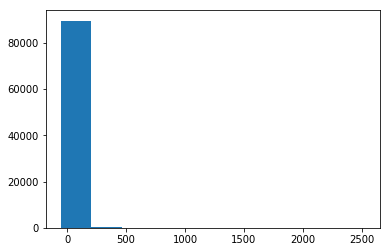

In [13]:
plt.hist(df['IBU']);

In [14]:
df.sort_values('IBU', ascending=False).head(20)

ABV     FG   IBU     OG  SRM  boil_time boil_time_units  \
88455  0.087  1.020  2529  1.086    6         90             min   
56295  0.053  1.014  1982  1.055    2         60             min   
17313  0.049  1.010   960  1.048    2         60             min   
52207  0.076  1.022   932  1.080    5         60             min   
23470  0.080  1.013   852  1.074    6         75             min   
14457  0.041  1.009   811  1.041    5         60             min   
14133  0.040  1.009   737  1.040    3         60             min   
14134  0.040  1.009   737  1.040    3         60             min   
37975  0.076  1.019   715  1.077   19         60             min   
13689  0.127  1.031   615  1.128    8        120             min   
18608  0.253  1.061   571  1.254   27        240             min   
79730  0.058  1.015   570  1.059    7         60             min   
42370  0.151  1.056   540  1.171   84        250             min   
42416  0.076  1.020   487  1.078   27         60             min   
69775  0.076  1.020   485  1.078   27         60             min   
54815  0.043  1.012   442  1.045    8         60             min   
71145  0.077  1.023   440  1.082   53         60             min   
21971  0.084  1.021   438  1.085    6         90             min   
37753  0.076  1.011   432  1.069    4         60             min   
21322  0.079  1.019   396  1.079    6         90             min   

                                                  extras  \
88455                                                  0   
56295  {0: {'amount': 2.0, 'amount_unit': 'each', 'na...   
17313                                                  0   
52207                                                  0   
23470  {0: {'amount': 1.0, 'amount_unit': 'each', 'na...   
14457                                                  0   
14133  {0: {'amount': 1.0, 'amount_unit': 'each', 'na...   
14134  {0: {'amount': 1.0, 'amount_unit': 'each', 'na...   
37975  {0: {'amount': 2.0, 'amount_unit': 'each', 'na...   
13689                                                  0   
18608  {0: {'amount': 40.0, 'amount_unit': 'gal', 'na...   
79730  {0: {'amount': 1.0, 'amount_unit': 'oz', 'name...   
42370  {0: {'amount': 2.0, 'amount_unit': 'lb', 'name...   
42416  {0: {'amount': 1.0, 'amount_unit': 'tsp', 'nam...   
69775  {0: {'amount': 1.0, 'amount_unit': 'tsp', 'nam...   
54815                                                  0   
71145  {0: {'amount': 1.0, 'amount_unit': 'tsp', 'nam...   
21971  {0: {'amount': 1.0, 'amount_unit': 'each', 'na...   
37753  {0: {'amount': 1.0, 'amount_unit': 'tsp', 'nam...   
21322  {0: {'amount': 1.0, 'amount_unit': 'each', 'na...   

                                            fermentables  \
88455  {0: {'amount': 13.25, 'amount_unit': 'lb', 'na...   
56295  {0: {'amount': 5.5, 'amount_unit': 'lb', 'name...   
17313  {0: {'amount': 6.5, 'amount_unit': 'lb', 'name...   
52207  {0: {'amount': 14.0, 'amount_unit': 'lb', 'nam...   
23470  {0: {'amount': 12.0, 'amount_unit': 'lb', 'nam...   
14457  {0: {'amount': 2.0, 'amount_unit': 'lb', 'name...   
14133  {0: {'amount': 10.0, 'amount_unit': 'lb', 'nam...   
14134  {0: {'amount': 10.0, 'amount_unit': 'lb', 'nam...   
37975  {0: {'amount': 9.0, 'amount_unit': 'lb', 'name...   
13689  {0: {'amount': 12.0, 'amount_unit': 'lb', 'nam...   
18608  {0: {'amount': 14.5, 'amount_unit': 'lb', 'nam...   
79730  {0: {'amount': 8.0, 'amount_unit': 'lb', 'name...   
42370  {0: {'amount': 9.0, 'amount_unit': 'lb', 'name...   
42416  {0: {'amount': 9.62, 'amount_unit': 'lb', 'nam...   
69775  {0: {'amount': 9.62, 'amount_unit': 'lb', 'nam...   
54815  {0: {'amount': 8.0, 'amount_unit': 'lb', 'name...   
71145  {0: {'amount': 5.0, 'amount_unit': 'lb', 'name...   
21971  {0: {'amount': 26.0, 'amount_unit': 'lb', 'nam...   
37753  {0: {'amount': 4.75, 'amount_unit': 'lb', 'nam...   
21322  {0: {'amount': 12.0, 'amount_unit': 'lb', 'nam...   

                                                    hops  

I'm going to restrict the recipes to those with an IBU rating larger than 0 and smaller than 658 based off of the established record by Dogfish Head Brewery

In [15]:
drop_indices = list(df[df['IBU'] >=658].index)
drop_indices.extend(list(df[df['IBU'] <= 0].index))
df.drop(drop_indices, axis=0, inplace=True)
df.shape

(89092, 17)

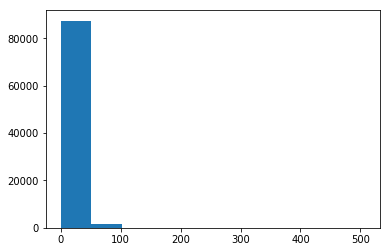

In [16]:
plt.hist(df['SRM']);

In [17]:
df[df['SRM'] == 0]

ABV     FG  IBU     OG  SRM  boil_time boil_time_units  \
9698   0.045  1.012  118  1.046    0         60             min   
11946  0.026  1.001   11  1.021    0         60             min   
24691  0.060  1.013   53  1.059    0         60             min   
38804  0.048  1.014   33  1.050    0         60             min   
39630  0.038  1.012   57  1.041    0         60             min   
43102  0.090  1.016  135  1.085    0         60             min   
60454  0.144  1.037    1  1.147    0         60             min   
60624  0.045  1.011   21  1.045    0         90             min   
63100  0.089  1.024   42  1.092    0         60             min   
69918  0.040  1.013   11  1.044    0         60             min   
74339  0.053  1.017   25  1.058    0         60             min   
74405  0.057  1.011   38  1.054    0         90             min   
80007  0.053  1.013    6  1.054    0         60             min   

                                                  extras  \
9698                                                   0   
11946                                                  0   
24691  {0: {'amount': 1.0, 'amount_unit': 'tsp', 'nam...   
38804  {0: {'amount': 2.0, 'amount_unit': 'tsp', 'nam...   
39630                                                  0   
43102                                                  0   
60454  {0: {'amount': 1.0, 'amount_unit': 'each', 'na...   
60624  {0: {'amount': 0.25, 'amount_unit': 'oz', 'nam...   
63100                                                  0   
69918  {0: {'amount': 2.0, 'amount_unit': 'tsp', 'nam...   
74339  {0: {'amount': 6.0, 'amount_unit': 'lb', 'name...   
74405  {0: {'amount': 4.0, 'amount_unit': 'oz', 'name...   
80007  {0: {'amount': 14.0, 'amount_unit': 'g', 'name...   

                                            fermentables  \
9698   {0: {'amount': 1.0, 'amount_unit': 'lb', 'name...   
11946  {0: {'amount': 16.48, 'amount_unit': 'oz', 'na...   
24691  {0: {'amount': 8.0, 'amount_unit': 'lb', 'name...   
38804  {0: {'amount': 6.0, 'amount_unit': 'lb', 'name...   
39630  {0: {'amount': 7.5, 'amount_unit': 'lb', 'name...   
43102  {0: {'amount': 15.94, 'amount_unit': 'lb', 'na...   
60454  {0: {'amount': 16.0, 'amount_unit': 'lb', 'nam...   
60624  {0: {'amount': 7.0, 'amount_unit': 'lb', 'name...   
63100  {0: {'amount': 10.0, 'amount_unit': 'lb', 'nam...   
69918  {0: {'amount': 8.5, 'amount_unit': 'lb', 'name...   
74339  {0: {'amount': 10.0, 'amount_unit': 'lb', 'nam...   
74405  {0: {'amount': 5.75, 'amount_unit': 'lb', 'nam...   
80007  {0: {'amount': 3.75, 'amount_unit': 'lb', 'nam...   

                                                    hops  \
9698   {0: {'amount': 0.5, 'amount_unit': 'oz', 'name...   
11946  {0: {'amount': 0.5, 'amount_unit': 'oz', 'name...   
24691  {0: {'amount': 1.0, 'amount_unit': 'oz', 'name...   
38804  {0: {'amount': 1.0, 'amount_unit': 'oz', 'name...   
39630  {0: {'amount': 0.75, 'amount_unit': 'oz', 'nam...   
43102  {0: {'amount': 3.5, 'amount_unit': 'oz', 'name...   
60454  {0: {'amount': 0.1, 'amount_unit': 'oz', 'name...   
60624  {0: {'amount': 0.4, 'amount_unit': 'oz', 'name...   
63100  {0: {'amount': 3.0, 'amount_unit': 'oz', 'name...   
69918  {0: {'amount': 0.25, 'amount_unit': 'oz', 'nam...   
74339  {0: {'amount': 1.0, 'amount_unit': 'oz', 'name...   
74405  {0: {'amount': 0.28, 'amount_unit': 'oz', 'nam...   
80007  {0: {'amount': 0.49, 'amount_unit': 'oz', 'nam...   

                                                    link  meets_guidelines  \
9698   http://www.brewtoad.com/recipes/alagash-clone-...                 1   
11946  http://www.brewtoad.com/recipes/stephen-kings-...                 1   
24691      http://www.brewtoad.com/recipes/cream-ale-196                 0   
38804  http://www.brewtoad.com/recipes/2013-sunnyland...                 0   
39630  http://www.brewtoad.com/recipes/maplewood-sess...                 0   
43102  http://www.brewtoad.com/recipes/summer-mosaic-...                 0   
6

A beer with an SRM of 0 would be completely clear. Again, these values do not make sense, so I'll discard these recipes

In [18]:
drop_indices = list(df[df['SRM'] == 0].index)
df.drop(drop_indices, axis=0, inplace=True)

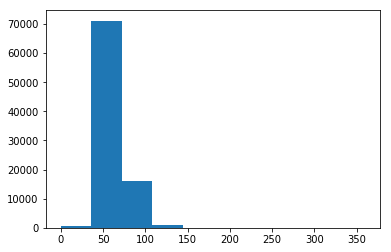

In [19]:
plt.hist(df['boil_time']);

In [20]:
df[df['boil_time'] > 120]

ABV     FG  IBU     OG  SRM  boil_time boil_time_units  \
172    0.043  1.011   39  1.044    4        240             min   
213    0.050  1.013   15  1.051    7        180             min   
520    0.105  1.030   44  1.110   16        150             min   
823    0.059  1.016   26  1.061   10        180             min   
858    0.071  1.020   22  1.074   10        180             min   
989    0.111  1.017   56  1.102   22        180             min   
1201   0.098  1.028   40  1.103   21        150             min   
1247   0.084  1.017   26  1.081   35        130             min   
1395   0.147  1.028  234  1.140   43        240             min   
1748   0.064  1.016   27  1.065   16        210             min   
2152   0.107  1.030   72  1.112   60        150             min   
2293   0.092  1.030   66  1.100   10        180             min   
2944   0.086  1.022  175  1.088   13        180             min   
3584   0.056  1.014   19  1.057    3        170             min   
3598   0.076  1.017   34  1.075   12        240             min   
3654   0.088  1.023   48  1.090   13        180             min   
3666   0.071  1.017   84  1.071    6        180             min   
3716   0.074  1.021   35  1.077   37        180             min   
4297   0.104  1.013   69  1.093   57        200             min   
5386   0.069  1.015   26  1.068    4        240             min   
6146   0.088  1.029  108  1.096   18        130             min   
6550   0.094  1.018  161  1.090   12        130             min   
6567   0.057  1.016   47  1.059    3        150             min   
6877   0.064  1.017   62  1.066    8        180             min   
7756   0.077  1.018   98  1.077   10        150             min   
7886   0.115  1.021   66  1.108   14        180             min   
8026   0.072  1.015   23  1.070   11        240             min   
8072   0.055  1.013   34  1.055   18        150             min   
8142   0.100  1.016   40  1.092   22        180             min   
8667   0.051  1.012   46  1.051   17        150             min   
...      ...    ...  ...    ...  ...        ...             ...   
74589  0.131  1.021  169  1.121    9        130             min   
75906  0.067  1.023   97  1.074   48        180             min   
76300  0.104  1.026   51  1.105   16        135             min   
77598  0.071  1.021   18  1.075   15        150             min   
78241  0.119  1.023   88  1.114    8        240             min   
78320  0.110  1.032   63  1.116   31        330             min   
78564  0.110  1.034   54  1.118   13        180             min   
78637  0.117  1.036  148  1.125   64        360             min   
78824  0.058  1.015   31  1.059   12        240             min   
78838  0.129  1.017   94  1.115   35        130             min   
82146  0.094  1.026  118  1.098   11        130             min   
82825  0.093  1.029   72  1.100   34        180             min   
82982  0.116  1.028  100  1.116   17        180             min   
83158  0.090  1.025   89  1.094   32        150             min   
83397  0.100  1.025   64  1.102    7        150             min   
83616  0.079  1.020   68  1.080   13        165             min   
84214  0.072  1.018   72  1.073    9        150             min   
84281  0.054  1.014   63  1.055    6        240             min   
84336  0.100  1.026  115  1.102   11        180             min   
84360  0.064  1.016   69  1.065    8        140             min   
85669  0.098  1.025   36  1.100   23        135             min   
86353  0.054  1.013   40  1.054    5        130             min   
86500  0.063  1.015   53  1.063    7        180             min   
87007  0.140  1.036   36  1.142   63        360             min   
88226  0.108  1.027   47  1.110   38        180             min   
88742  0.094  1.027   19  1.099   10        180             min   
89088  0.073  1.025  164  1.081   31        150             min   
89255  0.088  1.017  352  1.085    5        240         

The boil time for a beer needs to be at least 30 minutes and should not be longer than 2 full hours. I'll drop all recipes that don't follow these guidelines

In [21]:
df = df[(df['boil_time'] >= 30) & (df['boil_time'] <= 120)]

In [22]:
df.describe()

ABV            FG           IBU            OG           SRM  \
count  88592.000000  88592.000000  88592.000000  88592.000000  88592.000000   
mean       0.061256      1.015178     42.396650      1.061942     13.567636   
std        0.016003      0.004564     29.182405      0.015657     12.702144   
min        0.011000      1.000000      1.000000      1.011000      1.000000   
25%        0.051000      1.012000     24.000000      1.052000      5.000000   
50%        0.058000      1.015000     34.000000      1.059000      9.000000   
75%        0.069000      1.017000     53.000000      1.069000     17.000000   
max        0.286000      1.081000    615.000000      1.299000    508.000000   

          boil_time  meets_guidelines        volume  
count  88592.000000      88592.000000  88592.000000  
mean      65.578856          0.477684     11.669187  
std       12.622512          0.499505     82.069312  
min       30.000000          0.000000      0.170000  
25%       60.000000          0.000000      5.000000  
50%       60.000000          0.000000      5.500000  
75%       60.000000          1.000000      7.500000  
max      120.000000          1.000000  10000.000000

In [23]:
# Check which units were used for the boiling time
df['boil_time_units'].value_counts()

min    88592
Name: boil_time_units, dtype: int64

All beers used minutes for the unit of time in the boil, so I can drop this column as it does not contain any useful information

In [24]:
# Drop boiling time units column
df.drop('boil_time_units', axis=1, inplace=True)

---

## Volume Conversion

In [25]:
df['volume_units'].value_counts()

gal    77789
L      10803
Name: volume_units, dtype: int64

In [26]:
# Write function to change L to gallons
def liter_to_gal(row):
    # Look for where the units are liters
    if row['volume_units'] == 'L':
        # 1 Liter = 0.2641720524 gallons, multiply by this conversion factor
        return round(row['volume'] * 0.2641720524, 2)
    return round(row['volume'], 2)

In [27]:
# Convert all volume measurements
df['volume'] = df.apply(liter_to_gal, axis=1)

Now that all volume units have been converted, I can drop the volume units column as it no longer contains helpful information

In [28]:
df.drop('volume_units', axis=1, inplace=True)

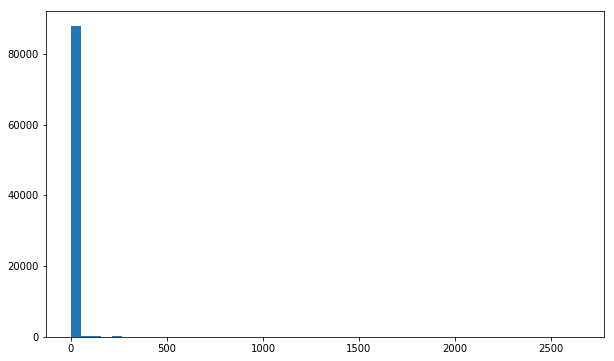

In [29]:
plt.figure(figsize=(10,6))
plt.hist(df['volume'], bins=50);

In [30]:
df['volume'].value_counts().head()

5.00     25554
5.50     13568
6.00      7260
5.49      3635
10.00     2371
Name: volume, dtype: int64

Homebrew recipes scale linearly within reasonable values. Clearly from the histogram above, there are some rather extreme values for volume considering the extraordinary right skew. The standard size for a homebrew recipe is 5 gallons. This is also the most common value for the volume by far. I will only consider recipes within the range of 1 to 25 gallons (5 times smaller and 5 times larger than the standard size

In [31]:
df = df[(df['volume'] >= 1) & (df['volume'] <= 25)]

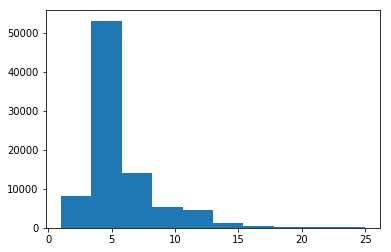

In [32]:
plt.hist(df['volume']);

---

## Convert Ingredient Columns From Strings to Dictionaries

When I saved the dataframes my web scraper created as a .csv file, it changed the dictionary values for the hops and the grains to be strings. I will convert these strings back to dictionaries below

In [33]:
dict_cols = ['fermentables', 'hops', 'yeast', 'extras']
for col in dict_cols:
    df[col] = df[col].map(ast.literal_eval)

## Drop any Recipe with '--deleted ingredient--' or Missing Section

Because all of the ingredient columns are nested dictionaries, I will write a function below to drop ingredients based on a list of values. This can either be strings that will appear in the ingredient name, or numerical values that will be compared to any of the ingredient measurements

In [34]:
def ingredient_name_dropper(value_list, column, dict_key, substring=True):
    # Store original number of rows to track how many rows are dropped
    orig_rows = df.shape[0]
        
    # Lowercase all strings in value_list
    value_list = [x.lower() for x in value_list]

    # Iterate through all rows of df
    for i in tqdm(df.index):

        # Grab the dictionary for the appropriate column
        d = df.loc[i, column]

        # Recipes without "extras" have a value of 0 instead of a dictionary
        # If this is a recipe like that, skip it
        if d == 0:
            continue

        # Substring version
        if substring:

            # Iterate through all nested dictionaries
            for j in d.values():

                # Drop row and break loop if any substring in value at specified dictionary key
                if any(x.lower() in j[dict_key].lower() for x in value_list):
                    df.drop(i, axis=0, inplace=True)
                    break

        # Full match version
        else:
            for j in d.values():

                # Drop row and break loop if any substring in value at specified dictionary key
                if j[dict_key].lower() in value_list:
                    df.drop(i, axis=0, inplace=True)
                    break

    print(f"{df.shape[0]} rows remaining. \t {orig_rows - df.shape[0]} rows dropped.")
    return None

In [35]:
ingredient_cols = ['fermentables', 'hops', 'yeast', 'extras']
for col in ingredient_cols:
    ingredient_name_dropper(['--deleted ingredient--'], col, 'name')

  9%|▉         | 7746/87219 [00:00<00:01, 75484.73it/s]

87219 rows remaining. 	 1 rows dropped.


 26%|██▌       | 22735/87208 [00:00<00:00, 113584.28it/s]

87208 rows remaining. 	 11 rows dropped.


  8%|▊         | 6714/87207 [00:00<00:01, 61310.03it/s]

87207 rows remaining. 	 1 rows dropped.


100%|██████████| 87207/87207 [00:01<00:00, 73724.42it/s]

87184 rows remaining. 	 23 rows dropped.


In [36]:
for i in df.index:
    if len(df.loc[i, 'fermentables']) == 0 or len(df.loc[i, 'hops']) == 0 or len(df.loc[i, 'yeast']) == 0:
        df.drop(i, axis=0, inplace=True)

In [37]:
df.shape

(87183, 15)

## Drop any recipes with ingredients with an amount of 0

Some recipes have ingredients listed but say that the amount of that ingredient is 0. I'll delete all of these recipes

In [38]:
def zero_checker(col):
    orig_rows = df.shape[0]
    for i in tqdm(df.index):
        for j in df.loc[i, col].values():
            if j['amount']==0:
                df.drop(i, axis=0, inplace=True)
                break
    print(f'{df.shape[0]} rows remaining. \t {orig_rows - df.shape[0]} rows dropped.')
    return None

In [39]:
zero_checker('fermentables')

100%|██████████| 87183/87183 [00:07<00:00, 11483.73it/s]

86870 rows remaining. 	 313 rows dropped.


In [40]:
zero_checker('hops')

100%|██████████| 86870/86870 [00:03<00:00, 26418.13it/s]

86765 rows remaining. 	 105 rows dropped.


## Drop Grains and Hops that occur fewer than 10 times

In homebrewing, you have complete freedom to try using any ingredients in any way you would like. While this makes homebrewing itself extremely interesting, it does have some important implications for this analysis. If very rare or unique ingredients are used, they will not add any information to the clustering analysis, and will likely introduce noise that makes finding clusters more difficult. Additionally, without the information from these unique ingredients, we will get an inaccurate representation of the beer, leading to potential mis-identification of clusters. For this reason, I'll drop the recipes that use ingredients that occured fewer than 10 times thorughout the dataset.

### Grains
First I'll make a dataframe of all of the grains and find the unique names.

In [41]:
def make_grain_df(exclude=['amount', 'use']):
    grain_list = []
    for i in tqdm(df.loc[:, 'fermentables'].values):
        for j in i.values():
            temp = j.copy()
            for key in exclude:
                del temp[key]
            if temp not in grain_list:
                grain_list.append(temp)
                j['grain_index'] = len(grain_list)-1
            else:
                j['grain_index'] = grain_list.index(temp)
    return pd.DataFrame(grain_list)

In [42]:
grain_df = make_grain_df()

100%|██████████| 86765/86765 [00:56<00:00, 1523.53it/s]


In [43]:
grain_df.head()

PPG amount_unit  color color_unit  generic maltster  \
0   39          lb      2         °L     True   Briess   
1   37          lb      1         °L    False   Briess   
2   35          lb     10         °L     True   Briess   
3   36          lb      1         °L     True   Briess   
4   36          lb      3         °L    False   Briess   

                      name  
0               Wheat (US)  
1       2-Row Brewers Malt  
2  Munich - Light 10L (US)  
3             Pilsner (US)  
4            Pale Ale Malt

In [44]:
# Set up a counter dictionary
grain_count = {g.lower():0 for g in grain_df['name'].unique()}

# Iterate through all recipes and add counts to count dictionary
for i in df.index:
    d = df.loc[i, 'fermentables']
    names = []
    for j in d.values():
        names.append(j['name'].lower())
    names = list(set(names))
    for x in names:
        grain_count[x] += 1

# Create a list of grains that occur fewer than 10 times to drop
grains_to_drop = []
for key, value in grain_count.items():
    if value <= 10:
        grains_to_drop.append(key)
len(grains_to_drop)

1115

In [45]:
ingredient_name_dropper(grains_to_drop, 'fermentables', 'name', substring=False)

100%|██████████| 86765/86765 [00:55<00:00, 1558.41it/s]

84713 rows remaining. 	 2052 rows dropped.


### Hops
Repeat the same process as above with the hops instead of the grains

In [46]:
def make_hop_df(exclude=['amount', 'time']):
    # Create an empty list
    hop_list = []

    # Iterate through all rows
    for i in tqdm(df.loc[:, 'hops'].values):
        # Iterate through all entries in hop dictionary
        for j in i.values():
            temp = j.copy()
            # Remove unnecessary columns
            for col in exclude:
                del temp[col]
            # If the hop is not a duplicate, add it to the list
            if temp not in hop_list:
                hop_list.append(temp)
                j['hop_index'] = len(hop_list)-1
            else:
                j['hop_index'] = hop_list.index(temp)

    # Make a dataframe from the list of dictionaries
    return pd.DataFrame(hop_list)

In [47]:
hop_df = make_hop_df()

# Create counter dictionary of hops
hop_count = {h.lower():0 for h in hop_df['name'].unique()}

# Iterate through all rows
for i in df.index:
    d = df.loc[i, 'hops']
    names = []
    for j in d.values():
        names.append(j['name'].lower())
    names = list(set(names))
    for x in names:
        hop_count[x.lower()] += 1

# Create empty list of hops to drop
hops_to_drop = [key for key, value in hop_count.items() if value <= 10]

ingredient_name_dropper(hops_to_drop, 'hops', 'name', substring=False)

100%|██████████| 84713/84713 [00:38<00:00, 2192.49it/s]

83099 rows remaining. 	 1614 rows dropped.


### Yeasts

In [48]:
def make_yeast_df(exclude=[]):
    # Create an empty list
    yeast_list = []

    # Iterate through all rows
    for i in tqdm(df.loc[:, 'yeast'].values):
        # Iterate through all entries in yeast dictionary
        for j in i.values():
            # If the yeast is not a duplicate, add it to the list
            temp=j.copy()
            for col in exclude:
                del temp[col]
            if temp not in yeast_list:
                yeast_list.append(temp)
                j['yeast_index'] = len(yeast_list) - 1
            else:
                j['yeast_index'] = yeast_list.index(temp)

    # Make a dataframe from the list of dictionaries
    return pd.DataFrame(yeast_list)

In [49]:
yeasts = make_yeast_df()

# Create counter dictionary of yeasts
yeast_count = {y.lower():0 for y in yeasts['name'].unique()}

# Iterate through all rows
for i in df.index:
    d = df.loc[i, 'yeast']
    names = []
    for j in d.values():
        names.append(j['name'].lower())
    names = list(set(names))
    for x in names:
        yeast_count[x.lower()] += 1

# Create empty list of yeasts to drop
yeasts_to_drop = [key for key, value in yeast_count.items() if value <= 10]

ingredient_name_dropper(yeasts_to_drop, 'yeast', 'name', substring=False)

100%|██████████| 83099/83099 [00:54<00:00, 1513.52it/s]

80590 rows remaining. 	 2509 rows dropped.


### Extras

In exploring my data, I have found a significant amount of variation in the naming conventions, spellings, and measurements of user entered ingredients. For hops, yeasts, and to a lesser extent, fermentables, there are a limited number of possibilities as to what can be used. However, in the extras category there is no limitation to what someone might add to a homebrew recipe. This would likely make it difficult to find meaningful categories and structure within the data simply based on the number of different possible ingredients that could fall into the extras category. For this reason I will not consider the extras feature further and will instead drop it from the dataframe

In [50]:
df.drop('extras', axis=1, inplace=True)

## Clean Ingredient Data

### Grains

I want to make sure that all recipes I'm using are all-grain recipes. I'll check if there are any recipes that contain dry or liquid malt extract below and if necessary, drop those recipes from the data set.

In [51]:
extract_names = ['dme', 'lme', 'malt extract', 'liquid extract', 'kit', 'wheat extract']
[g for g in grain_df['name'].unique() if any(x in g.lower() for x in extract_names)]

['Liquid Malt Extract - Pilsen',
 'Dry Malt Extract - Light',
 'Dry Malt Extract - Pilsen',
 'Dry Malt Extract - Amber',
 'Dry Wheat Extract',
 'Dry Malt Extract - Extra Light',
 'Liquid Malt Extract - Light',
 'Maris Otter LME',
 'Munich Liquid Extract',
 'Sparkling Amber LME',
 'Plain Dark DME',
 "Munton's Amber Malt Extract",
 'Pilsner DME',
 'Dry Malt Extract - Wheat',
 'Liquid Malt Extract - Extra Light',
 'X-Light Dry Malt Extract',
 'Extra Dark DME',
 'Liquid Malt Extract - Wheat',
 'briess cbw sparkling amber liquid extract',
 'Maris Otter Malt Extract',
 'Wheat Extract',
 'LME',
 'Liquid Malt Extract - Maris Otter',
 'Liquid Malt Extract - Munich',
 'Dry Malt Extract - Maris Otter',
 'Liquid Malt Extract - Pale',
 'Dry Malt Extract - Dark',
 'Dry Malt Extract - Pale\t',
 'Liquid Malt Extract - Amber',
 'Dry Malt Extract - Munich',
 'Pale Liquid Extract',
 'Sparkling Amber DME',
 'Liquid Malt Extract - Dark',
 'Plain Light DME',
 'Amber Unhopped LME',
 'Black Rock Pale Liquid E

There are multiple instances of recipes with dry and liquid malt extract, so I will drop those in the cells below. Before doing so, I'll first make everything lowercase to ensure that I don't miss any examples due to case differences. I'm also going to drop any recipes with home made ingredients, as I don't know if the information uploaded on the measurements of these ingredients will be accurate. In my own homebrewing experience, the equipment needed to accurately measure PPG and color is expensive, and I believe it unlikely that all people using homemade ingredients will be able to afford this equipment. Since I cannot tell which homemade ingredients are accurately measured and which are not, I'll discard all of them to be safe

In [52]:
homemade_names = ['homemade', 'home made', 'home toasted']
[g for g in grain_df['name'].unique() if any(x in g.lower() for x in homemade_names)]

['Home Toasted Deep Amber American Two-Row (65L)',
 'Home Toasted 2-Row',
 '30-Minute Home Toasted Pale Ale Malt (UK)',
 '15-Minute Home Toasted Pale Ale Malt (UK)',
 'Candi Sugar, Homemade',
 'Amber Candi Sugar, Homemade',
 'Homemade Dark Wheat Malt',
 'Homemade dark wheat malt',
 'Home made dark rye malt',
 'homemade crystal',
 'Home made invert sugar']

In [53]:
ingredient_name_dropper(extract_names, 'fermentables', 'name')
ingredient_name_dropper(homemade_names, 'fermentables', 'name')

  4%|▍         | 3235/79255 [00:00<00:02, 32347.79it/s]

79255 rows remaining. 	 1335 rows dropped.


100%|██████████| 79255/79255 [00:01<00:00, 44336.03it/s]

79255 rows remaining. 	 0 rows dropped.


Now I'll do some quick EDA on the remaining grains to see what they look like.

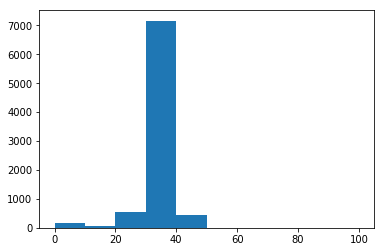

In [54]:
plt.hist(grain_df['PPG']);

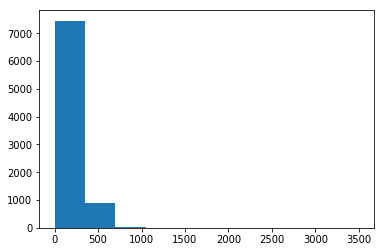

In [55]:
plt.hist(grain_df['color']);

In [56]:
grain_df.describe()

PPG        color
count  8365.000000  8365.000000
mean     33.920263    87.091333
std       6.292810   166.786354
min       0.000000     0.000000
25%      33.000000     3.000000
50%      34.000000    12.000000
75%      37.000000    75.000000
max     100.000000  3500.000000

It looks like there are some values that don't make sense. Degrees lovibond should not be over 800, so all values above that should be dropped. PPG measures how much of an increase in specific gravity one would expect to see if one pound of the fermentable was added to 1 gallon of water. Therefore, PPG should be greater than 0 for most malts. Additionally, the PPG of dextrose and other forms of sugar is approximately 46-48, which is the highest value of any fermentable that I know of. Anything beyond this value would not make sense. I'll drop any grains with a PPG above 50

In [57]:
grain_df[grain_df['color'] >= 800]

PPG amount_unit  color color_unit  generic   maltster  \
1612    1          lb   3120         °L    False        Any   
3202   35          lb   2320         °L     True  Dingemans   
3229   28           g   1400         °L     True        Any   
4015   33          kg   1300         °L     True     Briess   
4210   25          kg    985         °L    False        Any   
4211   33          kg    886         °L    False        Any   
4909   27          kg   1400         °L    False        Any   
5152   32          kg   1300         °L     True      Crisp   
5388   30          kg    850         °L    False        Any   
5421   28           g   1500         °L     True        Any   
5988   27          kg   1350         °L     True        Any   
6749   25          lb    800         °L     True        Any   
7226   34           g    900         °L     True  Dingemans   
7266   32           g    800         °L     True        Any   
7575   34          lb   3500         °L    False        Any   

                     name  
1612      Sinamar Extract  
3202         Biscuit (BE)  
3229      Black Malt (UK)  
4015  Roasted Barley (US)  
4210  Black (Patent) Malt  
4211       Chocolate Malt  
4909           Black Malt  
5152      Black Malt (US)  
5388            Carafa II  
5421      Black Malt (UK)  
5988    Black Barley (US)  
6749  Roasted Barley (US)  
7226       Chocolate (BE)  
7266      Carafa III (DE)  
7575            Maltoferm

In [58]:
drop_list = list(grain_df[grain_df['color'] >= 800].index)

In [59]:
grain_df[grain_df['PPG'] >= 50]

PPG amount_unit  color color_unit  generic    maltster  \
2666   50           g    100         °L    False         Any   
4660   77          kg     70         °L     True         Any   
5435   83           g     80         °L     True         Any   
6194  100          lb     60         °L    False  Weyermann®   
7000   80          lb     60         °L    False         Any   
7561   75           g     18         °L    False         Any   
7677   82          kg      4         °L     True         Any   
7678   82          kg     30         °L     True         Any   
7809   80          kg      5         °L     True       Crisp   

                          name  
2666             Black treacle  
4660              Biscuit (BE)  
5435  Caramel/Crystal 80L (US)  
6194           Wheat something  
7000               Caramel Rye  
7561                  CaraRuby  
7677             Carapils (DE)  
7678              Biscuit (BE)  
7809             Pale Ale (US)

In [60]:
drop_list += list(grain_df[grain_df['PPG'] >= 50].index)

In [61]:
def grain_dropper(indices):
    '''Pass in a list of indices from grain_df to drop all recipes with that grain
    from the original database'''
    orig = df.shape[0]
    # Create list of tuples (name, color, ppg) for grains to be dropped
    bad_grains = [list(grain_df.loc[x, ['name', 'color', 'PPG']].values) for x in indices]
    
    # Iterate through all rows in original dataframe
    for i in tqdm(df.index):
        # Iterate through all entries in fermentables dict
        d = df.loc[i, 'fermentables'].values()
        for j in d:
            # Check if tuple is in list to drop, if so break out of loop after dropping the row
            if [j['name'], j['color'], j['PPG']] in bad_grains:
                df.drop(i, axis=0, inplace=True)
                break
    print(f'{df.shape[0]} rows remaining. \t {orig- df.shape[0]} rows dropped.')
    return None

In [62]:
grain_dropper(drop_list)

100%|██████████| 79255/79255 [00:01<00:00, 70510.63it/s]

79241 rows remaining. 	 14 rows dropped.


Since I have dropped several recipes and I have found that all grains are using the same color units, I'll rerun the cells above that created the grain dataframe to get a more accurate picture of which grains remain

In [63]:
grain_df.head()

PPG amount_unit  color color_unit  generic maltster  \
0   39          lb      2         °L     True   Briess   
1   37          lb      1         °L    False   Briess   
2   35          lb     10         °L     True   Briess   
3   36          lb      1         °L     True   Briess   
4   36          lb      3         °L    False   Briess   

                      name  
0               Wheat (US)  
1       2-Row Brewers Malt  
2  Munich - Light 10L (US)  
3             Pilsner (US)  
4            Pale Ale Malt

In [64]:
df.loc[0, 'fermentables']

{0: {'amount': 5.0,
  'amount_unit': 'lb',
  'name': 'Wheat (US)',
  'maltster': 'Briess',
  'use': 'Mash',
  'PPG': 39,
  'color': 2,
  'color_unit': '°L',
  'generic': True,
  'grain_index': 0},
 1: {'amount': 4.0,
  'amount_unit': 'lb',
  'name': '2-Row Brewers Malt',
  'maltster': 'Briess',
  'use': 'Mash',
  'PPG': 37,
  'color': 1,
  'color_unit': '°L',
  'generic': False,
  'grain_index': 1},
 2: {'amount': 1.0,
  'amount_unit': 'lb',
  'name': 'Munich - Light 10L (US)',
  'maltster': 'Briess',
  'use': 'Mash',
  'PPG': 35,
  'color': 10,
  'color_unit': '°L',
  'generic': True,
  'grain_index': 2}}

In [65]:
grain_df = make_grain_df(exclude=['amount', 'amount_unit', 'use', 'grain_index', 'color_unit', 'generic'])
print('Shape', grain_df.shape)
print('Number of unique names', len(grain_df['name'].unique()))

100%|██████████| 79241/79241 [00:12<00:00, 6571.01it/s]

Shape (3296, 4)
Number of unique names 753


In [66]:
grain_df[grain_df['PPG']==0]

PPG  color               maltster                      name
33      0      0                    Any                Rice Hulls
270     0      0                    Any             Maltodextrine
388     0     20                    Any  Organic Caramel Malt 20L
476     0    550                 Briess  Midnight Wheat Malt (US)
482     0    500                 Briess          Blackprinz® Malt
696     0     17             Weyermann®               Abbey Malt®
1438    0      0                 Briess                Rice Hulls
1578    0      2                    Any               Flaked Oats
1703    0      0                   Rahr                Rice Hulls
1821    0    525                    Any              Black Patent
1848    0      2                    Any                   pumpkin
1882    0      1                    Any                Flaked Rye
1887    0      3                    Any              Cocoa Powder
2067    0    500                    Any     debittered black malt
2339    0      2                    Any           Spelt Malt (DE)
2340    0      3                    Any                  Rye (US)
2492    0    500                    Any           Black Malt (UK)
2508    0    300                 Briess       Roasted Barley (US)
2765    0    500  Thomas Fawcett & Sons                Black malt
2871    0      1                    Any      Lactose (Milk Sugar)
2937    0      0                    Any                Wheat (UK)
3008    0      1                    Any                   Pumpkin
3161    0    470                    Any  De-Husked Caraf III (DE)
3184    0    550                    Any       Roasted Barley (UK)
3258    0      0          Great Western                Rice Hulls
3278    0    425                    Any            Chocolate (UK)

In [67]:
mask_1 = grain_df['PPG'] == 0
mask_2 = grain_df['name'] != 'Rice Hulls'
mask_3 = grain_df['name'] != 'Maltodextrine'
mask_5 = grain_df['name'] != 'Lactose (Milk Sugar)'

drop_indices = list(grain_df[(mask_1) & (mask_2) & (mask_3)].index)
grain_dropper(indices=drop_indices)

100%|██████████| 79241/79241 [00:03<00:00, 25280.64it/s]

79113 rows remaining. 	 128 rows dropped.


In [68]:
bad_grains = ['boost', 'mroost',  'quaker quick oats', 'bread syrup', 'Château Café', 'grits',
              'devil ipa', 'field corn', 'kolsch', 'golden syrup', 'graham crackers']
ingredient_name_dropper(bad_grains, 'fermentables', 'name')

100%|██████████| 79113/79113 [00:07<00:00, 10985.09it/s]

78795 rows remaining. 	 318 rows dropped.


In [69]:
grain_df[grain_df['color']==0]

PPG  color       maltster                               name
17     34      0         Briess      Carapils (Dextrine Malt) (US)
18     46      0            Any              Dextrose (Corn Sugar)
28     36      0            Any  Belgian Candi Sugar - Clear/Blond
33      0      0            Any                         Rice Hulls
37     46      0            Any                       Invert Sugar
98     35      0            Any               Lactose (Milk Sugar)
261    32      0            Any        Belgian Candi Sugar - Clear
270     0      0            Any                      Maltodextrine
464    32      0            Any        Belgian Candi Syrup - Clear
513    46      0            Any             BrewVint Alcohol Boost
538    46      0            Any              Sucrose (Table Sugar)
598    32      0            Any         Belgian Candi Syrup, Clear
627    40      0            Any                        Flaked Corn
705    34      0            Any                            Glucose
769    46      0            Any                         Cane Sugar
829    39      0            Any                       Maltodextrin
866    40      0            Any                        Flaked Rice
886    37      0            Any                         Corn Syrup
906    38      0            Any  Belgian Candi Sugar - Clear/Blond
1128   34      0            Any      Carapils (Dextrine Malt) (US)
1178    1      0            Any               Libby's Pumpin 29 oz
1222   23      0            Any                        Coffee Malt
1249   39      0            Any                      Maltodextrin 
1316   47      0            Any              Sucrose (Table Sugar)
1326   40      0         Briess                        Flaked Corn
1438    0      0         Briess                         Rice Hulls
1683   37      0            Any                        Flaked Corn
1684   32      0            Any                        Flaked Rice
1703    0      0           Rahr                         Rice Hulls
1819    5      0            Any                            Pumpkin
2037   36      0            Any              Sucrose (Table Sugar)
2061   46      0         Briess              Dextrose (Corn Sugar)
2162   30      0            Any                        Maple Syrup
2330   10      0            Any               Lactose (Milk Sugar)
2490   38      0     Weyermann®  Belgian Candi Sugar - Clear/Blond
2572   40      0            Any        Belgian Candi Syrup - Clear
2766   40      0         Briess                        Flaked Rice
2778   35      0            Any           Caramel/Crystal 10L (US)
2862   44      0            Any              Sucrose (Table Sugar)
2864   32      0            Any  Belgian Candi Sugar - Clear/Blond
2937    0      0            Any                         Wheat (UK)
3248   20      0            Any                        Flaked Corn
3258    0      0  Great Western                         Rice Hulls

Pure sugar, dextrin, and rice hulls will not add additional color to a beer, but all other grains will. I'll remove those grains that claim not to add any color that are not one of the above

In [70]:
drop_indices = [513, 627, 866, 1178, 1222, 1326, 1683, 1684, 1819, 2162, 2766, 2778, 2937, 3248]
grain_dropper(drop_indices)
grain_df = make_grain_df(exclude=['amount', 'amount_unit', 'use', 'grain_index', 'color_unit', 'generic'])

  3%|▎         | 2208/78073 [00:00<00:20, 3742.94it/s] 

78073 rows remaining. 	 722 rows dropped.


100%|██████████| 78073/78073 [00:14<00:00, 5261.88it/s]


### Hops

In [71]:
hop_df = make_hop_df(exclude=['amount', 'amount_unit', 'time', 'use', 'form', 'generic', 'hop_index'])
hop_df.head()

100%|██████████| 78073/78073 [00:30<00:00, 2539.03it/s]


alpha                    name
0  0.109           Amarillo (US)
1  0.040            Liberty (US)
2  0.035               Saaz (CZ)
3  0.040  Hallertauer Aroma (NZ)
4  0.045         Tettnanger (US)

In [72]:
hop_df.shape

(5220, 2)

In [73]:
hop_df.describe()

alpha
count  5220.000000
mean      0.089323
std       0.050492
min       0.000000
25%       0.053000
50%       0.081000
75%       0.123000
max       1.600000

In [74]:
hop_df[hop_df['alpha']<=0.01]

alpha                    name
212   0.002              Perle (US)
410   0.010  Hallertauer Aroma (NZ)
808   0.010         Centennial (US)
980   0.010            Cascade (NZ)
992   0.007            Chinook (US)
1026  0.010       Kent Golding (UK)
1107  0.010               Saaz (CZ)
1142  0.010            Chinook (US)
1186  0.010            Cascade (US)
1188  0.010            Glacier (US)
1189  0.010         Mount Hood (US)
1190  0.010          Hallertau (US)
1191  0.010           Sterling (US)
1623  0.001              Citra (US)
1927  0.010          Hallertau (DE)
1996  0.000           Amarillo (US)
1997  0.000             Simcoe (US)
2407  0.010         Willamette (US)
2479  0.008            Golding (US)
2624  0.008             Fuggle (US)
2676  0.000                  Mosaic
2786  0.000            Cascade (US)
2927  0.001            Golding (UK)
3220  0.001             Magnum (DE)
3221  0.001         Centennial (US)
3272  0.000                Hop Shot
3471  0.000              Citra (US)
3472  0.000        Sorachi Ace (JP)
3523  0.010           Amarillo (US)
3524  0.001  East Kent Golding (UK)
3532  0.001           Amarillo (US)
3832  0.000  Pride of Ringwood (AU)
3982  0.001            Cascade (NZ)
4139  0.007            Motueka (NZ)
4163  0.001               Saaz (CZ)
4474  0.010              Citra (US)
4475  0.010             Galaxy (AU)
4478  0.001            Warrior (US)
4784  0.000         Centennial (US)
4785  0.001         Mount Hood (US)
4842  0.000           Columbus (US)
4843  0.000       Pacific Jade (NZ)
4975  0.010      heirloom/homegrown

Hops should not have below 1% alpha acid, so recipes with these hops should be removed as the information is not valid

In [75]:
hop_df.sort_values('alpha', ascending=False)

alpha                    name
1269  1.600                 hopshot
3421  0.790                 HopShot
4836  0.500                 Hopshot
1433  0.388            Cascade (US)
4217  0.270             Simcoe (US)
4282  0.260             Simcoe (US)
5191  0.260            Cascade (US)
4515  0.257          El Dorado (US)
4279  0.256            Mosaic™ (US)
790   0.252              Citra (US)
4262  0.252             Simcoe (US)
3136  0.250              Citra (US)
5164  0.250            Mosaic™ (US)
5162  0.250                 Ekuanot
3363  0.244              Citra (US)
4683  0.242            Mosaic™ (US)
2808  0.241            Mosaic™ (US)
2241  0.240          El Dorado (US)
4248  0.240            Chinook (US)
4263  0.238              Citra (US)
2807  0.238             Simcoe (US)
1456  0.237              Citra (US)
3417  0.235             Simcoe (US)
4283  0.234             Simcoe (US)
2736  0.232            Mosaic™ (US)
2483  0.230             Simcoe (US)
4620  0.228                 Ekuanot
1455  0.223            Mosaic™ (US)
1440  0.213            Polaris (DE)
3008  0.211             Simcoe (US)
...     ...                     ...
1189  0.010         Mount Hood (US)
1188  0.010            Glacier (US)
1186  0.010            Cascade (US)
980   0.010            Cascade (NZ)
2624  0.008             Fuggle (US)
2479  0.008            Golding (US)
992   0.007            Chinook (US)
4139  0.007            Motueka (NZ)
212   0.002              Perle (US)
3982  0.001            Cascade (NZ)
3524  0.001  East Kent Golding (UK)
4478  0.001            Warrior (US)
3220  0.001             Magnum (DE)
3221  0.001         Centennial (US)
1623  0.001              Citra (US)
3532  0.001           Amarillo (US)
4163  0.001               Saaz (CZ)
2927  0.001            Golding (UK)
4785  0.001         Mount Hood (US)
4784  0.000         Centennial (US)
3272  0.000                Hop Shot
2786  0.000            Cascade (US)
4842  0.000           Columbus (US)
1996  0.000           Amarillo (US)
4843  0.000       Pacific Jade (NZ)
3472  0.000        Sorachi Ace (JP)
3471  0.000              Citra (US)
2676  0.000                  Mosaic
1997  0.000             Simcoe (US)
3832  0.000  Pride of Ringwood (AU)

[5220 rows x 2 columns]

(array([ 79., 289., 654., 801., 694., 549., 533., 464., 460., 353., 203.,
         82.,  26.,   6.,   8.,  10.,   5.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.   , 0.016, 0.032, 0.048, 0.064, 0.08 , 0.096, 0.112, 0.128,
        0.144, 0.16 , 0.176, 0.192, 0.208, 0.224, 0.24 , 0.256, 0.272,
        0.288, 0.304, 0.32 , 0.336, 0.352, 0.368, 0.384, 0.4  , 0.416,
        0.432, 0.448, 0.464, 0.48 , 0.496, 0.512, 0.528, 0.544, 0.56 ,
        0.576, 0.592, 0.608, 0.624

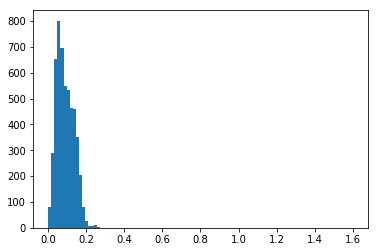

In [76]:
plt.hist(hop_df['alpha'], bins=100)

The `alpha` column represents a percentage of alpha acids found in the particular hop used. The largest value for the alpha acid percentage of a standard hop that I am aware of is about 18-22% for Polaris Hops. The smallest values I have seen are approximately 2%. Obviously, these are normal ranges and guidelines rather than hard and fast rules, however some of the values that are given here do not make much sense. 

Any recipe with a hop that has an alpha acid below 1% should be discarded as invalid data, same thing goes for any recipe with a hop that has an alpha acid above 25%

In [77]:
def hop_dropper(indices):
    orig = df.shape[0]
    bad_hops = [list(hop_df.loc[x, ['name', 'alpha']].values) for x in indices]
    for i in tqdm(df.index):
        d = df.loc[i, 'hops'].values()
        for j in d:
            if [j['name'], j['alpha']] in bad_hops:
                df.drop(i, axis=0, inplace=True)
                break
    print(f'{df.shape[0]} rows remaining. \t {orig-df.shape[0]} rows dropped.')
    return None

In [78]:
drop_indices = list(hop_df[hop_df['alpha'] <= 0.01].index) + list(hop_df[hop_df['alpha'] >= 0.25].index)
hop_dropper(drop_indices)

100%|██████████| 78073/78073 [00:03<00:00, 25486.88it/s]

77987 rows remaining. 	 86 rows dropped.


Recipes with homegrown hops will not be considered for reasons mentioned above about trustworthiness of measurements

In [79]:
extract_names = ['home', 'hophash', 'hop hash', 'hop shot', 'hopshot', 'extract', 'dust']
ingredient_name_dropper(extract_names, 'hops', 'name')

100%|██████████| 77987/77987 [00:04<00:00, 19183.07it/s]

77866 rows remaining. 	 121 rows dropped.


### Yeasts

In [80]:
yeast_df = make_yeast_df(exclude=['yeast_index', 'generic'])

100%|██████████| 77866/77866 [00:03<00:00, 23543.29it/s]


In [81]:
yeast_df.shape

(2744, 3)

Yeast attenuation is a measurement of the percentage of sugars that yeast convert into alcohol. This is normally within the range of 65%-85%. I'll check to see if there are any yeasts with abnormally low or high attenuations.

In [82]:
yeast_df.describe()

yeast_attenuation
count        2744.000000
mean            0.777731
std             0.068492
min             0.000000
25%             0.740000
50%             0.770000
75%             0.820000
max             1.000000

There definitely should not be yeasts with an attenuation of 0, and I'm also suspicious of yeasts with an attenuation of 1

In [83]:
yeast_df[yeast_df['yeast_attenuation'] < 0.5]

name  yeast_attenuation    yeast_lab
122   Lactobacillus                0.0  Wyeast 5335
1142    Pediococcus                0.0  Wyeast 5733

In [84]:
drop_indices = list(yeast_df[yeast_df['yeast_attenuation'] < 0.5].index)

In [85]:
yeast_df[yeast_df['yeast_attenuation'] >= 0.95]

name  yeast_attenuation          yeast_lab
470           American Farmhouse Blend              0.970  White Labs WLP670
554                      French Saison              0.950        Wyeast 3711
613             Belgian Saison I Yeast              1.000  White Labs WLP565
718               Belgian Lambic Blend              0.950        Wyeast 3278
911                       Belle Saison              0.950            Danstar
941                       Safbrew T-58              0.950     Fermentis T-58
947   Amalgamation - Brett Super Blend              0.980      The Yeast Bay
1120                            Saison              0.960                   
1134                      American Ale              0.950        Wyeast 1056
1224                   Dry Belgian Ale              0.990      The Yeast Bay
1238                     French Saison              1.000        Wyeast 3711
1442                     French Saison              0.960        Wyeast 3711
1494            Belgian Saison I Yeast              0.950  White Labs WLP565
1537       Belgian Sour Mix 1 (WLP655)              0.950                   
1714                            Abbaye              1.000          Fermentis
1732               Roeselare Ale Blend              0.950        Wyeast 3763
1752        Brettanomyces Bruxellensis              0.950  White Labs WLP650
1783                     French Saison              0.970        Wyeast 3711
1793        Brettanomyces Bruxellensis              1.000        Wyeast 5112
1794              Belgian Saison Yeast              1.000        Wyeast 3724
1795            Brettanomyces Lambicus              1.000  White Labs WLP653
1856                 Pasteur Champagne              0.950          Fermentis
1913               Roeselare Ale Blend              0.990        Wyeast 3763
1932              Belgian Saison Yeast              0.950        Wyeast 3724
2089              Belgian Saison Yeast              0.990        Wyeast 3724
2095        Brettanomyces Bruxellensis              0.950        Wyeast 5112
2096        Belgian Bastogne Ale Yeast              0.950  White Labs WLP510
2110                      Belle Saison              0.960            Danstar
2116                   Belgian Witbier              0.980        Wyeast 3944
2117                       Pediococcus              0.980        Wyeast 5733
2145              Belgian Lambic Blend              0.980        Wyeast 3278
2205                     French Saison              0.980        Wyeast 3711
2214                    California Ale              1.000  White Labs WLP001
2324                       Belgian Ale              0.950    Mangrove Jack's
2325                   Dry Belgian Ale              0.950      The Yeast Bay
2382            Brettanomyces Lambicus              0.970        Wyeast 5526
2383                     Lactobacillus              0.970        Wyeast 5335
2560            Belgian Saison I Yeast              0.960  White Labs WLP565
2638                   Champagne Yeast              0.960                   
2639              Belgian Saison Yeast              0.960        Wyeast 3724
2710             Bavarian Weizen Yeast              0.950  White Labs WLP351
2725                      Belle Saison              0.980            Danstar
2731              Belgian Saison Yeast              0.975        Wyeast 3724

In [86]:
drop_indices += list(yeast_df[yeast_df['yeast_attenuation'] >= 0.95].index)

In [87]:
def yeast_dropper(indices):
    orig = df.shape[0]
    bad_yeasts = [list(yeast_df.loc[x, ['name', 'yeast_attenuation', 'yeast_lab']].values) for x in indices]
    for i in tqdm(df.index):
        d = df.loc[i, 'yeast'].values()
        for j in d:
            if [j['name'], j['yeast_attenuation'], j['yeast_lab']] in bad_yeasts:
                df.drop(i, axis=0, inplace=True)
                break
    print(f'{df.shape[0]} rows remaining. \t {orig-df.shape[0]} rows dropped.')
    return None

In [88]:
yeast_dropper(drop_indices)

100%|██████████| 77866/77866 [00:02<00:00, 26120.88it/s]

77757 rows remaining. 	 109 rows dropped.


In [89]:
non_standard_yeasts = ['wine', 'champ', 'local', 'bottle', 'culture', 'dregs', 'sake']
ingredient_name_dropper(non_standard_yeasts, 'yeast', 'name')

100%|██████████| 77757/77757 [00:03<00:00, 23314.04it/s]

77626 rows remaining. 	 131 rows dropped.


---

## Fixing User Entered Data

The recipes that I am using are all scraped from the website [Brewtoad](http://www.brewtoad.com). This website allows users to enter any values they would like for the names of ingredients and all other fields when submitting a recipe. This had led to a huge discrepancy in the way the same grains or hops were entered into the site. There are multiple different ways that the same grains/hops are entered. I'll fix this below. Before fixing each set of ingredients, I'll regenerate the dataframes as I have dropped recipes since the last time they were generated.

#### Grains

In [90]:
grain_df = make_grain_df(exclude=['amount', 'amount_unit', 'use', 'color_unit', 'generic', 'grain_index'])

100%|██████████| 77626/77626 [00:11<00:00, 7026.05it/s]


In [91]:
def grain_name_cleaner(orig_names):
    # Make a copy of the original names to change to new names
    new_names = [x.lower() for x in orig_names]
    
    # Remove maltster names from grain names
    for i in grain_df['maltster'].unique():
        if i.lower() == 'any':
            continue
        new_names = [g.replace(i, '').strip() for g in new_names]

    # Remove the word malt and brewers from grain names
    new_names = [g.replace(' malt ', ' ').strip() for g in new_names]
    new_names = [g.replace("'", '').replace('brewers', '').strip() for g in new_names]
    
    # Replace unwanted characters/words in grain names
    # Build list of replacements
    grain_replacements = [
        # Punctuation
        ('-', ' '), ('/', ' '), (',', ''), ('(', ''), (')', ''), ('"', ''), ('’', ''),

        # Symbols
        ('md™', ''), ('™', ''), ('®', ''), ('°', ''), 

        # Accented Characters
        ('á', 'a'), ('ö', 'o'), ('é', 'e'), ('ô', 'o'),

        # Maltster names
        ('thomas fawcett', ''), ('fawcett', ''), ('breiss', ''), ('best malz', ''), ('canada malting', ''),
        ('canadian malting', ''), ('château', ''), ('dingeman', ''), ('europ', ''), ('franco belges', ''),
        ('francobelges', ''), ('gladfield', ''), ('gleneagles', ''), ('malteurop', ''), ('maltexico', ''),
        ('pauls', ''), ('simpons', ''), ('tf', ''), ('warminster', ''), ('weyermann', ''), ('weyerman', ''),
        ('thomas faucett', ''), ('bairds', ''), ('valley', ''), ('caragill', ''), ('great western', ''),
        ('canada m.c.', ''), ('gambrinus', ''), ('muntons', ''), ('munton', ''), ('crisp', ''),
        ('castle', ''), ('fawcet', ''), ('company', ''), ('rahr', ''), ('durst', ''),
        ('moravian', ''), ('viking', ''),

        # Spelling mistakes
        ('torrefied', 'torrified'), ('floor ed', 'floor malted'), ('cara belge', 'carabelge'),
        ('cara pils', 'carapils'), ('cherrywood smoke', 'cherrywood smoked'), ('dextrine', 'dextrin'),
        ('de husked', 'dehusked'), ('de bittered', 'debittered'), ('marris otter', 'maris otter'),
        ('marrisottercarapils', 'maris otter carapils'), ('raisans', 'raisins'), ('ebs', 'esb'),
        ('bohemial', 'bohemian'), ('caraf i', 'carafa i'), ('smokedd', 'smoked'),
        ('carstan', 'carastan'), ('pilsener', 'pilsner'), ('roast barley', 'roasted barley'),

        # Terminology differences
        ('floored', 'floor malted'), ('cherry wood', 'cherrywood'), ('carafa special', 'carafa'),
        ('type 1', 'i'), ('type 3', 'iii'), ('oio g&p', 'ca'), ('oio ca', 'ca'), ('oio', ''),  
        ('rauchmalz', 'beechwood smoked malt de'), ('german rauch smoked', 'beechwood smoked malt de'),
        ('beechwood smoked malt', 'beechwood smoked malt de'), ('caramel crystal 10 us', 'caramel crystal 10'),
        ('dehusked carafa iii special', 'dehusked carafa iii'), ('caramunich be', 'caramunich'),
        ('wheat torrified', 'torrified wheat'), ('bohemian pilsner', 'bohemian pilsner de'),
        ('candi syrup', 'candi sugar'), ('dark candi sugar', 'candi sugar dark'),
        ('soft brown', 'amber'), ('sugar syrup', 'sugar'), ('cara ruby cara 50', 'cara 50'),
        ('caramel wheat de', 'caramel wheat'), ('carawheat', 'caramel wheat'),
        ('cherry smoked', 'cherrywood smoked'), ('dextrose corn sugar', 'corn syrup'),
        ('low colour', 'pale uk'),  ('pumpkin cooked', 'pumpkin'), ('soft candi', 'candi'),
        
        # Unnecessary descriptive words
        ('organic', ''), ('premium', ''), ('milk sugar', ''), ('ebc', ''), ('type two', ''), ('type', ''),
        ('trader joes', ''), ('brewers', ''), (' malt ', ' '), ('matl', ''), ('australian', ''),

        # Numbers to words
        ('2 ', 'two '), ('6 ', 'six '), 
    ]
    
    # Loop through list and run all replacements
    for r in grain_replacements:
        new_names = [g.replace(r[0], r[1]).strip() for g in new_names]
    
    # Remove 'malt' at beginning and end of grain names
    new_names = [g.replace('malt', '').strip() if g.startswith('malt ') else g for g in new_names]
    new_names = [g.replace('malt', '').strip() if g.endswith(' malt') else g for g in new_names]
    
    # Fix all multiple spaces to be a single space
    new_names = [re.sub('\s+', ' ', g) for g in new_names]
    
    # Replace country names
    new_names = [g.replace('american ', '').strip() + ' us' if 'american' in g else g for g in new_names]
    new_names = [g.replace('british ', '').strip() + ' uk' if 'british' in g else g for g in new_names]
    new_names = [g.replace('belgian ', '').strip() + ' be' if 'belgian' in g else g for g in new_names]
    new_names = [g.replace('canadian ', '').strip() + ' ca' if 'canadian' in g else g for g in new_names]
    new_names = [g.replace('english ', '').strip() + ' uk' if 'english' in g else g for g in new_names]
    new_names = [g.replace('german ', '').strip() + ' de' if 'german' in g else g for g in new_names]
    
    # Fix remaining issues from country names
    new_names = [g.replace('us ', '') + ' us' if 'us ' in g else g for g in new_names]
    new_names = [g.replace('uk ', '') + ' uk' if 'uk ' in g else g for g in new_names]
    new_names = [g.replace('de de', 'de') for g in new_names]
    new_names = [g[:-1].strip() if g.endswith(' l') else g for g in new_names]
    new_names = [g.replace('0l','0').replace('4l','4').replace('5l','5').replace('7l','7').replace('8l','8') for g in new_names]
    
    # Fix different names for same grain
    full_replace = [
        ('sucrose', 'sucrose'), ('acid', 'acid'), ('agave', 'agave'), ('california select', 'two row us'),
        ('brown sugar', 'brown sugar'), ('cara 20', 'cara 20 be'), ('cara 45', 'cara 45 be'), 
        ('cara 8', 'cara 8'), ('cara gold', 'cara gold be'), ('caraamber', 'caraamber de'),
        ('carabelge', 'carabelge de'), ('carabohemian', 'carabohemian de'), ('carabrown', 'carabrown us'),
        ('carafa iii', 'carafa iii'), ('carafa ii', 'carafa ii'), ('carafa i', 'carafa i'),
        ('carafoam', 'carafoam de'), ('caramalt', 'caramalt'), ('caramunich iii', 'caramunich iii'),
        ('caramunich ii', 'caramunich ii'), ('caramunich i', 'caramunich i'), ('carapils be', 'carapils'),
        ('carapils de', 'carapils'), ('carapils dextrin', 'carapils dextrin'), ('carapils two row', 'two row'),
        ('caravienne', 'caravienne'), ('carawheat', 'carawheat'), ('chocolate rye', 'chocolate rye'),
        ('colorado two row pale', 'two row pale'), ('crystal 135', 'crystal 135 uk'), 
        ('crystal 30 37', 'crystal 30 uk'), ('crystal 45', 'crystal 45 uk'), ('crystal 50 60', 'crystal 50 uk'),
        ('crystal 70', 'crystal 70 uk'), ('crystal 65', 'crystal 65 uk'), ('crystal 90 uk', 'crystal 90'),
        ('crystal rye', 'crystal rye uk'), ('dark chocolate', 'dark chocolate us'), 
        ('dark munich', 'dark munich de'), ('dark wheat', 'dark wheat de'),
        ('debittered black', 'debittered black de'), ('dextrin carapils uk', 'dextrin uk'),
        ('extra dark crystal uk', 'extra dark crystal'), ('extra special', 'extra special us'),
        ('floor ed b', 'floor malted bohemian pilsner de'), ('floor ed', 'floor malted bohemian wheat de'),
        ('floor malted bohmeian wheat', 'floor malted bohemian wheat de'), 
        ('golden naked oats', 'golden naked oats uk'), ('kolsch', 'kolsch de'), 
        ('light crystal', 'light crystal de'), ('medium crystal', 'medium crystal uk'),
        ('mild', 'mild ale'), ('munich dark 30', 'munich 30'), ('munich light', 'munich light'),
        ('oat uk', 'oat'), ('optic', 'optic uk'), ('pale ale', 'pale ale'), ('pale chocolate', 'pale chocolate'),
        ('pale two row', 'pale two row'), ('pale wheat', 'pale wheat'), ('pearl', 'pearl'),
        ('peated', 'peated uk'), ('pilsner two row', 'pilsner two row'), ('red wheat', 'red wheat'),
        ('raisins', 'raisins'), ('raspberry', 'raspberry'), ('roasted barley', 'roasted barley'), 
        ('six row', 'six row us'), ('spelt', 'spelt de'), ('two row', 'two row'), ('vienna', 'vienna'),
        ('wheat dark', 'dark wheat de'), ('wheat ger', 'wheat de'), ('wheat be', 'wheat be'), 
        ('white wheat', 'white wheat us'), ('abbey', 'abbey'), ('ale nz', 'ale'),
        ('barley torrified', 'torrified barley'), ('black 600', 'black be'),
        ('black patent', 'black patent uk'), ('bonlander munich', 'bonlander munich us'),
        ('candi sugar clear', 'candi sugar clear'), ('candi sugar a', 'candi sugar amber'),
        ('candi sugar dark', 'candi sugar dark'), ('caraaroma', 'caraaroma de'), 
        ('crystal dark 77', 'crystal dark 77'), ('crystal 30', 'crystal 30'),
        ('crystal 40', 'crystal 40'), ('crystal 60', 'crystal 60'), ('crystal 90', 'crystal 90'),
        ('floor malted bohemian wheat', 'floor malted bohemian wheat de'),
        ('golden naked oat', 'golden naked oats uk'), ('libbys pump', 'libbys pumpkin mix'),
        ('munich dark', 'munich dark'), ('special b', 'special b'), ('victory', 'victory us'),
        ('wheat red', 'red wheat'), ('biscuit', 'biscuit'), ('black roast', 'black roast'),
        ('candi sugar brown', 'candi sugar brown'), ('candi sugar simplicity', 'candi sugar blond'),
        ('candi sugar d 45', 'candi sugar amber'), ('candi sugar d 90', 'candi sugar dark'),
        ('candi sugar d 180', 'candi sugar extra dark'), ('candi sugar d2', 'candi sugar dark'),
        ('cane sugar', 'glucose'), ('caramel pils', 'carapils'), ('caramel rye', 'cararye'),
        ('caramel crystal 10 us', 'caramel crystal 10'), ('caramel crystal 120 us', 'caramel crystal 120'),
        ('caramel crystal 30 us', 'caramel crystal 30'), ('caramel crystal 40 us', 'caramel crystal 40'),
        ('caramel crystal 60 us', 'caramel crystal 60'), ('caramel munich 60 us', 'caramel munich 60'),
        ('crystal 95 115 l uk', 'crystal 95 115 uk'), ('crystal extra dark 120 uk', 'crystal 120'),
        ('crystal 120', 'crystal 120'), ('dextrin uk', 'dextrin'), ('munich 8 10', 'munich 10'),
        ('s light munich', 'munich light'), ('crystal 120 ca', 'crystal 120'),
        ('crystal 95 115 l uk', 'crystal 95 115 uk'), ('crystal 77', 'crystal dark 77'),
        ('crystal extra dark 120 uk', 'crystal 120'), ('crystal cara 150','crystal 150'),
        ('amber uk', 'amber'), ('barley flaked', 'flaked barley'), ('wheat light de', 'light wheat'),
        ('light crystal de', 'crystal pale'), ('medium crystal uk', 'crystal medium'),
        ('melanoidin', 'melanoidin'), ('mfb special aromatic', 'aromatic'),
        ('candi sugar dt', 'candi sugar dark'), ('candi sugar extra dark', 'candi sugar extra dark'),
        ('caracrystal wheat us', 'caramel wheat'), ('caramel wheat', 'caramel wheat'),
        ('caramunch caramel', 'caramunich'), ('chocolate wheat', 'chocolate wheat'),
        ('crystal 15 ', 'crystal 15'), ('dark crystal ii', 'dark crystal 2'), 
        ('extra dark crystal', 'extra dark crystal'), ('fructose', 'simple sugar'),
        ('glucose', 'simple sugar'), ('corn syrup', 'simple sugar'), ('maize flaked', 'flaked corn'),
        ('invert', 'simple sugar'), ('pale maris otter', 'maris otter pale uk'),
        ('pilsen', 'pilsen'), ('dark munich de', 'munich dark'), ('malted naked oats uk', 'oats malted'),
        ('aroma', 'aromatic'), ('black barley', 'black barley'), ('black us', 'black'), ('black uk', 'black'),
        ('black be', 'black'), ('black treacle', 'molasses'), ('apple cider', 'apple juice'),
        ('pilsner', 'pilsner'), ('bonlander munich us', 'munich'), ('black roast', 'black'),
        ('bonlander', 'munich'), ('rice red', 'rice'), ('rice brown', 'rice'), ('flaked rice', 'rice'),
        ('rice syrup', 'rice'), ('brown uk', 'brown')
    ]
    for i in full_replace:
        new_names = [i[1] if i[0] in g else g for g in new_names]
        
    # Create mapping dictionary
    grain_mapper = {orig_names[i]:new_names[i] for i in range(len(new_names))}
    
    return (new_names, grain_mapper)

In [92]:
grain_df['name'], grain_mapper = grain_name_cleaner(grain_df['name'])

In [93]:
def remap_names(mapper, col):
    for i in tqdm(df.loc[:, col].values):
        for j in i.values():
            j['name'] = mapper[j['name']]
    return None

In [94]:
remap_names(grain_mapper, 'fermentables')

100%|██████████| 77626/77626 [00:00<00:00, 504339.63it/s]


In [95]:
grain_df = make_grain_df(exclude=['amount', 'use', 'maltster', 'color_unit', 'generic', 'grain_index'])
print('Shape', grain_df.shape)
print('Number of unique names', len(grain_df['name'].unique()))

100%|██████████| 77626/77626 [00:15<00:00, 4979.97it/s]

Shape (3256, 4)
Number of unique names 259


#### Hops

In [96]:
hop_df = make_hop_df(exclude=['amount', 'amount_unit', 'time', 'use', 'form', 'generic', 'hop_index'])

100%|██████████| 77626/77626 [00:24<00:00, 3201.84it/s]


In [97]:
def hop_name_cleaner(orig_names):
    # Create new_names to change
    new_names = [x.lower() for x in orig_names]
    
    # Create list of stopwords
    stop_words = ['(', ')', '%', '™', "'", '’', '.', ',', 'columbus/tomahawk/zeus', 'polish',
                  'organic', 'hopunion', 'fresh', 'bitterning', 'yakima', 'valley', 'hobart street']
    for w in stop_words:
        new_names = [x.replace(w, '') for x in new_names]
    new_names = [re.sub('\s+', ' ', re.sub('\s', ' ', g)).strip() for g in new_names]
    
    hop_replacements = [
        # Punctuation/Symbols
        ('-', ' '), ('/', ' '), ('ü', 'u'),
        
        # Misspellings
        ('7 c', '7c'), ('seven seas', ('7cs')), ('fuggles', 'fuggle'), ('lemondrop', 'lemon drop'),
        ('williamette', 'willamette'), ('eldorado', 'el dorado'), ('arora', 'aurora'),
        ('kazbeck', 'kazbek'), ('mandarine', 'mandarina'), ('mosiac', 'mosaic'), ('zues', 'zeus'),
        ('2usa', '2 us'), ('millennium', 'millenium'), ('ekuanot', 'eukanot'), ('columbia', 'columbus'),
        
        # Terminology Differences
        ('goldings east kent', 'east kent golding'), ('goldings', 'golding'), ('exp ', 'experimental '),
        ('7cs falconers flight', 'falconers flight 7cs'), ('mt', 'mount'),
        ('select spalt', 'spalt select'), ('super styrians', 'styrian aurora si'), ('tettnanger', 'tettnang'),
        ('auscha', ''), ('hallertauer aroma nz', 'wakatu'), ('pacific hallertau', 'pacifica'),
        ('ekg', 'east kent golding'), ('hbc3', 'hbc 3'), ('hbc4', 'hbc 4'), ('experiemental', 'exp'),
        ('galena us', 'galena'), ('tomahawk', 'ctz'), ('zeus', 'ctz'), ('hallertauer', 'hallertau')
    ]
    
    # Iterate through all replacements
    for r in hop_replacements:
        new_names = [x.replace(r[0], r[1]).strip() for x in new_names]

    # Fix spacing again
    new_names = [re.sub('\s+', ' ', g).strip() for g in new_names]
    
    # Create list of full replacements
    full_swaps = [
        # Terminology
        ('438', 'hbc 438'),('columbus', 'ctz us'), ('celeia', 'styrian celeia'),
        ('falconers', 'falconers flight 7cs us'), ('mandarin', 'mandarina bavaria de'),
        ('sauvin', 'nelson sauvin nz'), ('za', 'azacca us'), ('rudi', 'dr rudi nz'),
        
        # Country fix
        ('motueka', 'motueka nz'), ('sorachi ace', 'sorachi ace jp'), ('nelson', 'nelson sauvin nz'),
        ('bavaria', 'mandarina bavaria de'), ('melon', 'huell melon de'), ('premiant', 'premiant cz'), 
        ('willamette', 'willamette us'), ('aramis', 'aramis fr'), ('galaxy', 'galaxy au'),
        ('hersbrucker', 'hersbrucker de'), ('tradition', 'tradition de'), ('kazbek', 'kazbek cz'),
        ('marynka', 'marynka pl'), ('mount hood', 'mount hood us'), ('mosaic', 'mosaic us'),
        ('pacific jade', 'pacific jade nz'), ('waimea', 'waimea nz'), ('wakatu', 'wakatu nz'), 
        ('styrian golding', 'styrian golding si'), ('belma', 'belma us'), ('bravo', 'bravo us'),
        ('caliente', 'caliente us'), ('calypso', 'calypso us'), ('challenger', 'challenger uk'),
        ('chinook', 'chinook us'), ('citra', 'citra us'), ('crystal', 'crystal us'), 
        ('comet', 'comet us'), ('delta', 'delta us'), ('denali', 'denali us'), 
        ('east kent golding', 'east kent golding uk'), ('dorado', 'el dorado us'),
        ('equinox', 'equinox us'), ('glacier', 'glacier us'), ('green bullet', 'green bullet nz'),
        ('hallertau blanc', 'hallertauer blanc de'), ('hallertauer blanc', 'hallertauer blanc de'),
        ('ryl', 'jarrylo us'), ('legacy', 'legacy us'), ('liberty', 'liberty us'), 
        ('mosaic', 'mosaic us'), ('meridian', 'meridian us'), ('northdown', 'northdown uk'),
        ('nugget', 'nugget us'),('polaris', 'polaris de'), ('premiant', 'premiant cz'),
        ('sladek', 'sladek cz'), ('southern cross', 'southern cross nz'), ('sovereign', 'sovereign uk'),
        ('summit', 'summit us'), ('sybilla', 'sybilla pl'), ('sylva', 'sylva au'),
        ('target', 'target uk'), ('vic secret', 'vic secret au'), ('waimea', 'waimea nz'),
        ('wakatu', 'wakatu nz'), ('centennial', 'centennial us'), ('ctz', 'ctz us'),
        ('simcoe', 'simcoe us'), ('spalt', 'spalt select de'), ('warrior', 'warrior us')
    ]
    
    # Iterate through all full replacements
    for f in full_swaps:
        new_names = [f[1] if f[0] in x else x for x in new_names]
    
    # Replace Countries
    new_names = [x.replace('new zealand', '') + ' nz' if 'new zealand' in x else x for x in new_names]
    new_names = [x.replace('australian', '') + ' au' if 'australian' in x else x for x in new_names]
    new_names = [x.replace('belgian', '') + ' be' if 'belgian' in x else x for x in new_names]
    new_names = [x.replace('german', '') + ' de' if 'german' in x else x for x in new_names]
    
    # Fix spacing one more time
    new_names = [re.sub('\s+', ' ', g).strip() for g in new_names]
    
    # Create mapping dictionary
    mapper = {orig_names[i]:new_names[i] for i in range(len(new_names))}
    
    return new_names, mapper

In [98]:
hop_df['name'], hop_mapper = hop_name_cleaner(hop_df['name'])

In [99]:
remap_names(hop_mapper, 'hops')

100%|██████████| 77626/77626 [00:00<00:00, 629927.88it/s]


#### Yeasts

In [100]:
yeast_df = make_yeast_df(exclude=['generic', 'yeast_index'])

100%|██████████| 77626/77626 [00:01<00:00, 40134.18it/s]


In [101]:
def yeast_name_cleaner(orig_names):
    # Create new_names to change
    new_names = [x.lower() for x in orig_names]
    
    # Replace all whitespace characters with regular spaces and all multiple spaces with a single space
    new_names = [re.sub('\s+', ' ', re.sub('\s', ' ', x)) for x in new_names]
    
    # Create list of stopwords
    stop_words = ['-', '(', ')', 'yeast', "'", 'dry', 'white labs', '™', '’', '"', '1768', 'wlp630',
                  '3191', 'wlp080', 'danstar', 'wlp072', 'wyeast 1728', 'wlp860', 'fison', 
                  '2565', '2575', '4335', 'wlp655', 'wlab500', 'wlp645', 'style'
                 ]
    
    for w in stop_words:
        new_names = [x.replace(w, '') for x in new_names]
    new_names = [re.sub('\s+', ' ', re.sub('\s', ' ', g)).strip() for g in new_names]
    
    yeast_replacements = [
        # Punctuation/Symbols
        ('-', ' '), ('/', ' '), ('ü', 'u'), ('ä', 'a'), ('ö', 'o'),
        
        # Misspellings
        ('safeale', 'safale'), ('kolsh', 'kolsch'), ('delbruckii', 'delbrueckii'),
        ('delbrueckli', 'delbrueckii'), ('brettanomcyes', 'brettanomyces'), ('bier ', 'biere '),
        
        # Terminology Differences
        ('london esb', 'english special bitter'), ('wyeast 3787', 'trappist high gravity'),
        ('east midlands ale', 'nottingham ale'), ('u.s.', 'us')
    ]
    
    # Iterate through all replacements
    for r in yeast_replacements:
        new_names = [x.replace(r[0], r[1]).strip() for x in new_names]

    # Create list of full replacements
    full_swaps = [
        ('pac', 'rogue pacman 1764'), ('san diego', 'san diego super'), ('biere de', 'biere de garde'),
        ('west yorkshire', 'west yorkshire ale'), ('windsor', 'windsor ale'), ('sour mix', 'belgian sour mix i'),
        ('cry havoc', 'cry havoc'), ('edinburgh', 'edinburgh scottish ale yeast'), ('3726', 'farmhouse ale'),
        ('us 05', 'safale us 05'), ('s 04', 'safale s 04'), ('wb 06', 'safbrew wb 06'),
        ('german ale kolsch', 'german kolsch'), ('wlp099', 'super high gravity ale wlp099'),
        ('west coast ipa', 'west coast ipa wyeast 1217'), ('nottingham', 'mottingham ale'),
        ('safale english ale', 'safale s 04'), ('wlp670', 'american farmhouse blend'),
        ('saflager w', 'saflager w 34 70'), ('s04', 'safale s 04'), ('us05', 'safale us 05'),
        ('34 70', 'saflager w 34 70'), ('wlp500', 'trappist ale'), 
        ('farmhouse blend', 'american farmhouse blend'), ('bruxellensis', 'brettanomyces bruxellensis trois'),
        ('english special bitter', 'english special bitter ale'), ('bry97', 'american west coast'),
        ('german lager', 'german lager'), ('toberfest', 'oktoberfest lager'), ('wb06', 'safbrew wb06'),
        ('super high gravity ale', 'super high gravity ale'), ('w 3787', 'trappist high gravity'),
        ('scottish ale', 'scottish ale'), ('west coast', 'american west coast')
    ]
    
    # Iterate through all full replacements
    for f in full_swaps:
        new_names = [f[1] if f[0] in x else x for x in new_names]
    
    # Fix spacing one more time
    new_names = [re.sub('\s+', ' ', g).strip() for g in new_names]
    
    # Create mapping dictionary
    mapper = {orig_names[i]:new_names[i] for i in range(len(new_names))}
    
    return new_names, mapper

In [102]:
yeast_df['name'], yeast_mapper = yeast_name_cleaner(yeast_df['name'])

In [103]:
remap_names(yeast_mapper, 'yeast')

100%|██████████| 77626/77626 [00:00<00:00, 1576990.53it/s]


---

## Convert all grain measurements to pounds and all hop measurements to ounces

There are various units used to measure the amount of hops and grains that are in each recipe. In order to compare recipes, these units must be the same. First, I'll create functions to convert to ounces and pounds from the various units found in the dataset

In [104]:
def convert_to_pounds(amount, unit):
    if unit == 'lb':
        return amount
    if unit == 'oz':
        return round(amount/16, 3)
    if unit == 'g':
        return round(amount * 0.00220462, 3)
    if unit == 'kg':
        return round(amount * 2.20462, 3)
    
def convert_to_oz(amount, unit):
    if unit == 'oz':
        return amount
    if unit == 'lb':
        return amount*16
    if unit == 'g':
        return round(amount*0.035274, 3)

Now I'll use these functions to change all measurements to pounds for the grains and to ounces for the hops. These are the most common values found for the measurements.

In [105]:
for i in tqdm(df.index):
    f = df.loc[i, 'fermentables']
    h = df.loc[i, 'hops']
    for i in range(max(len(f), len(h))):
        if i in f.keys():
            f[i]['amount'] = convert_to_pounds(f[i]['amount'], f[i]['amount_unit'])
            del f[i]['amount_unit']
        if i in h.keys():
            h[i]['amount'] = convert_to_oz(h[i]['amount'], h[i]['amount_unit'])
            del h[i]['amount_unit']

100%|██████████| 77626/77626 [00:01<00:00, 43980.16it/s]


## Create columns for total amount of fermentables and hops

Another potentially useful piece of information is the total amount of hops and grains that are in a beer. I'll create these two features using mapping in the cells below

In [106]:
def total_grains(my_dict):
    total = 0
    for i in my_dict.values():
        total += i['amount']
    return total

In [107]:
df['total_fermentables'] = df['fermentables'].map(total_grains)

In [108]:
def total_hops(my_dict):
    total = 0
    for i in my_dict.values():
        total += i['amount']
    return total

In [109]:
df['total_hops'] = df['hops'].map(total_hops)

Another useful feature besides the amount of a grain is the percentage of the total grain bill or hop schedule that is comprised of each individual hop/grain. I'll create these values within the nested dictionaries in the cell below.

In [110]:
for j in tqdm(df.index):
    f = df.loc[j, 'fermentables']
    h = df.loc[j, 'hops']
    for i in range(max(len(f), len(h))):
        if i in f.keys():
            f[i]['percent'] = round(f[i]['amount']/df.loc[j, 'total_fermentables'], 4)
        if i in h.keys():
            h[i]['percent'] = round(h[i]['amount']/df.loc[j, 'total_hops'], 4)

100%|██████████| 77626/77626 [00:11<00:00, 6643.79it/s]


(array([7.7625e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.0000000e-02, 2.8774310e+02, 5.7544620e+02, 8.6314930e+02,
        1.1508524e+03, 1.4385555e+03, 1.7262586e+03, 2.0139617e+03,
        2.3016648e+03, 2.5893679e+03, 2.8770710e+03]),
 <a list of 10 Patch objects>)

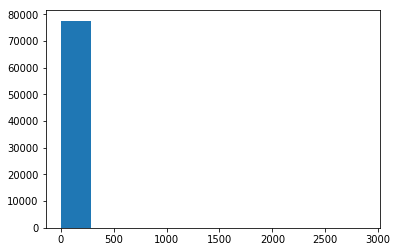

In [111]:
plt.hist(df['total_hops'])

(array([7.7625e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([8.7000000e-01, 1.7772580e+02, 3.5458160e+02, 5.3143740e+02,
        7.0829320e+02, 8.8514900e+02, 1.0620048e+03, 1.2388606e+03,
        1.4157164e+03, 1.5925722e+03, 1.7694280e+03]),
 <a list of 10 Patch objects>)

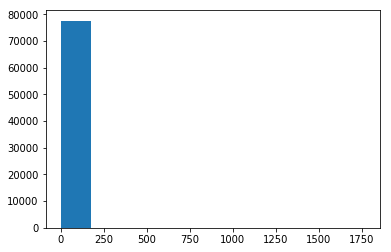

In [112]:
plt.hist(df['total_fermentables'])

In both the total fermentables and total hops there are some extreme outliers. Most 5 gallon beers use between 1 and 5 ounces of hops. Including dry hopping, total hop additions may get to be up to 1 pound. Values above 1400 ounces, or around 88 pounds, are impossible to use in 5 gallon batches as that much grain wouldn't fit in 5 gallons. Typical grain bills are between 8 and 14 pounds, with doubles going up to as much as 25. This may be due to differences in volume size, although there shouldn't be any volumes that extreme still remaining. Before deciding how to handle these values, I'll first scale the recipes to all have a volume of 5 gallons

## Scaling Recipes

All of the recipes I was given have different volumes. In order to use the amounts of ingredients in a recipe as features, I'll need to scale the recipes to all have the same volume. I'll do so below.

In [113]:
def recipe_scaler(row):
    vol = row['volume']
    if vol==5:
        return row
    scale_factor = 5/vol
    row['total_fermentables']*= scale_factor
    row['total_hops'] *= scale_factor
    for i in row['hops'].values():
        i['amount'] *= scale_factor
    for i in row['fermentables'].values():
        i['amount'] *= scale_factor
    row['volume'] = 5
    return row

In [114]:
df = df.apply(recipe_scaler, axis=1)

In [115]:
df = df[df['total_hops'] <= 16]
df = df[df['total_fermentables']<=25]

(array([19021., 31094., 13008.,  6938.,  3569.,  1684.,   976.,   482.,
          256.,   167.]),
 array([ 0.04995005,  1.64495504,  3.23996004,  4.83496503,  6.42997003,
         8.02497502,  9.61998002, 11.21498501, 12.80999001, 14.404995  ,
        16.        ]),
 <a list of 10 Patch objects>)

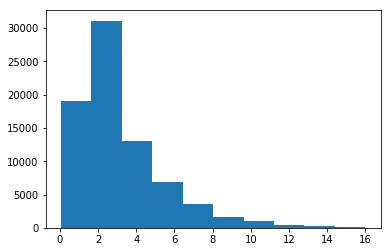

In [116]:
plt.hist(df['total_hops'])

(array([   37.,   621.,  8624., 30857., 20989.,  9360.,  3937.,  1700.,
          761.,   309.]),
 array([ 1.79090909,  4.11181818,  6.43272727,  8.75363636, 11.07454545,
        13.39545455, 15.71636364, 18.03727273, 20.35818182, 22.67909091,
        25.        ]),
 <a list of 10 Patch objects>)

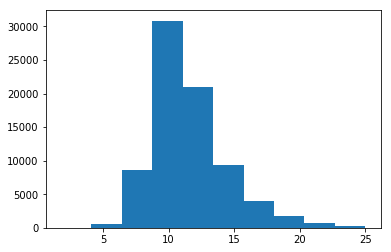

In [117]:
plt.hist(df['total_fermentables'])

At this point, I believed I was ready to jump into my clustering analysis. However, I found that in creating my dataframe, I ended up with a matrix that was almost entirely zeroes

In [118]:
def column_filler(grain_list, hop_list, yeast_list, input_df):
    dataframe = input_df.copy()
    for x in grain_list:
        dataframe['fermentable_'+x] = 0
    for h in hop_list:
        dataframe['hop_'+h] = 0
    for y in yeast_list:
        dataframe['yeast_'+y] = 0
    for row in tqdm(dataframe.index):
        f = dataframe.loc[row, 'fermentables']
        h = dataframe.loc[row, 'hops']
        y = dataframe.loc[row, 'yeast']
        for i in f.values():
            dataframe.loc[row, 'fermentable_'+i['name']] += i['amount']
        for i in h.values():
            dataframe.loc[row, 'hop_'+i['name']] += i['amount']
        for i in y.values():
            dataframe.loc[row, 'yeast_'+i['name']] = 1
    return dataframe

In [119]:
check_df = column_filler(grain_df['name'].unique(), hop_df['name'].unique(), yeast_df['name'].unique(), df)

100%|██████████| 77195/77195 [10:32<00:00, 122.09it/s]


In [120]:
check_df.head()

ABV     FG  IBU     OG  SRM  boil_time  \
0  0.055  1.012   36  1.054    4        105   
1  0.060  1.014   15  1.060    4         60   
2  0.052  1.016   26  1.056    6         60   
3  0.051  1.014   57  1.053    5         60   
4  0.111  1.030  146  1.115   57         90   

                                        fermentables  \
0  {0: {'amount': 4.517919877401726, 'name': 'whe...   
1  {0: {'amount': 6.666666666666666, 'name': 'pil...   
2  {0: {'amount': 4.761904761904763, 'name': 'two...   
3  {0: {'amount': 9.09090909090909, 'name': 'two ...   
4  {0: {'amount': 14.0, 'name': 'two row', 'malts...   

                                                hops  \
0  {0: {'amount': 0.22589599387008633, 'name': 'a...   
1  {0: {'amount': 1.0, 'name': 'liberty us', 'tim...   
2  {0: {'amount': 1.1904761904761907, 'name': 'wa...   
3  {0: {'amount': 0.45454545454545453, 'name': 'c...   
4  {0: {'amount': 2.0, 'name': 'centennial us', '...   

                                                link  meets_guidelines  \
0  http://www.brewtoad.com/recipes/frances-summer...                 0   
1       http://www.brewtoad.com/recipes/belgian-whit                 0   
2  http://www.brewtoad.com/recipes/russian-german...                 0   
3         http://www.brewtoad.com/recipes/baldy-pale                 0   
4       http://www.brewtoad.com/recipes/danger-stout                 0   

            ...            yeast_saison blend yeast_english ale blend wlp085  \
0           ...                             0                              0   
1           ...                             0                              0   
2           ...                             0                              0   
3           ...                             0                              0   
4           ...                             0                              0   

   yeast_bells oberon yeast_greenbelt  yeast_belgian schelde 3655  \
0                   0               0                           0   
1                   0               0                           0   
2                   0               0                           0   
3                   0               0                           0   
4                   0               0                           0   

   yeast_bastogne belgian ale  yeast_headwaters ale 1000  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   

   yeast_saison brettanomyces blend  yeast_safale k97  yeast_bread any variety  
0                                 0                 0                        0  
1                                 0                 0                        0  
2                                 0                 0                        0  
3                                 0                 0                        0  
4                                 0                 0                        0  

[5 rows x 604 columns]

In [121]:
check_df.columns[:30]

Index(['ABV', 'FG', 'IBU', 'OG', 'SRM', 'boil_time', 'fermentables', 'hops',
       'link', 'meets_guidelines', 'name', 'style', 'volume', 'yeast',
       'total_fermentables', 'total_hops', 'fermentable_wheat us',
       'fermentable_two row', 'fermentable_munich light',
       'fermentable_pilsner', 'fermentable_pale ale',
       'fermentable_caramel crystal 10', 'fermentable_cara 8',
       'fermentable_cherrywood smoked', 'fermentable_roasted barley',
       'fermentable_rolled oats', 'fermentable_chocolate uk',
       'fermentable_torrified wheat', 'fermentable_crystal 120',
       'fermentable_crystal 60'],
      dtype='object')

In [122]:
X = check_df.drop(['fermentables', 'hops', 'link', 'name', 'style', 'yeast', 'meets_guidelines', 'volume'], axis=1)

In [123]:
X.astype(bool).sum(axis=0).sort_values(ascending=False).head(30)/X.shape[0]

ABV                                1.000000
FG                                 1.000000
IBU                                1.000000
OG                                 1.000000
SRM                                1.000000
boil_time                          1.000000
total_fermentables                 1.000000
total_hops                         1.000000
fermentable_two row                0.497856
fermentable_pilsner                0.221582
fermentable_carapils               0.189326
fermentable_maris otter pale uk    0.175296
fermentable_crystal 60             0.172369
hop_cascade nz                     0.152614
yeast_safale us 05                 0.142457
fermentable_crystal 40             0.130760
hop_centennial us                  0.130371
fermentable_vienna                 0.116873
fermentable_munich light           0.109618
hop_amarillo us                    0.106911
fermentable_roasted barley         0.106872
hop_citra us                       0.098115
fermentable_flaked oats         

The series above shows the percentage of non-zero values within each column. As you can see, only 20 columns have fewer than 90% zeros, so this approach of using all of the possible ingredients as values will not be successful. The data is simply too sparse for effective analysis, and dropping the extremely sparse columns would leave many recipes with no ingredient information at all. To counter this, instead of using every possible ingredient, I will cluster the hops and grains that exist within the dataset, and then use the presence of grains within a cluster as the feature

## Preparing Grains for Clustering

In order to cluster the grains, I need more than just the color and PPG of each specific grain. I'm also going to include information on what percent of the grain bill each grain comprises. There are some grains that are strictly base malts, which are used for a relatively large percentage of the grain bill (up to 80%), while others are specialty grains, which are used for relatively small percentages (up to 10%). There are some grains that can be used as both, which will cause greater variance within the percentages for that grain.

To start this clustering approach, I'll remake the grain_df and add in new features as required.

In [124]:
grain_df = make_grain_df(exclude=['amount', 'use', 'maltster', 'color_unit', 'generic', 'grain_index', 'percent'])

100%|██████████| 77195/77195 [00:07<00:00, 10016.72it/s]


In [125]:
def grain_df_add_percent():
    grain_df['percents'] = np.empty((len(grain_df), 0)).tolist()
    for i in tqdm(df.loc[:, 'fermentables'].values):
        for j in i.values():
            grain_df.loc[j['grain_index'], 'percents'].append(j['percent'])
    grain_df['times_used'] = [len(i) for i in grain_df['percents'].values]
    return None

In [126]:
grain_df_add_percent()

100%|██████████| 77195/77195 [00:02<00:00, 32300.59it/s]


In [127]:
grain_df.head()

PPG  color          name  \
0   39      2      wheat us   
1   37      1       two row   
2   35     10  munich light   
3   36      1       pilsner   
4   36      3      pale ale   

                                            percents  times_used  
0  [0.5, 0.2333, 0.1952, 0.1, 0.0787, 0.2255, 0.4...        4758  
1  [0.4, 0.4615, 0.6206, 0.8569, 0.9091, 0.8182, ...       30742  
2  [0.1, 0.1538, 0.3636, 0.0148, 0.1111, 0.2143, ...        4363  
3  [0.6061, 0.7505, 0.6744, 0.3846, 0.1951, 0.859...         482  
4  [0.3939, 0.5542, 0.0833, 0.8, 0.7965, 0.2222, ...        1336

In [128]:
grain_df.describe()

PPG        color    times_used
count  1805.000000  1805.000000   1805.000000
mean     33.754571   109.119668    180.901939
std       5.030411   169.450413   1018.184263
min       0.000000     0.000000      1.000000
25%      33.000000     5.000000      1.000000
50%      34.000000    25.000000      3.000000
75%      36.000000   120.000000     50.000000
max      47.000000   750.000000  30742.000000

There appear to be some grains that are very rarely used. Although I dropped uncommon ingredients above, that was only by matching the names. In this case the uncommon ingredients are not uniquely named grains, but rather grains with a common name that have unique values for color or PPG. I'm going to drop recipes with these ingredients

In [129]:
rare_grains_index = grain_df[grain_df['times_used'] < 10].index
drop_indices = []
for i in tqdm(df.index):
    for j in df.loc[i, 'fermentables'].values():
        if j['grain_index'] in rare_grains_index:
            drop_indices.append(i)
            break
df.drop(drop_indices, axis=0, inplace=True)

100%|██████████| 77195/77195 [00:00<00:00, 101099.08it/s]


In [130]:
excluded_cols = ['amount', 'use', 'maltster', 'color_unit', 'generic', 'grain_index', 'percent']
grain_df = make_grain_df(exclude=excluded_cols)

100%|██████████| 75686/75686 [00:04<00:00, 15386.87it/s]


In [131]:
grain_df_add_percent()

100%|██████████| 75686/75686 [00:02<00:00, 32677.28it/s]


In [132]:
grain_df['max_percent'] = [max(i) for i in grain_df['percents'].values]
grain_df['min_percent'] = [min(i) for i in grain_df['percents'].values]
grain_df['mean_percent'] = [np.mean(i) for i in grain_df['percents'].values]
grain_df['sd_percent'] = [np.std(i) for i in grain_df['percents'].values]

In [133]:
grain_df.to_csv('../Data/grain_df_clean.csv')

I'll also make a version of the grain dataframe where I aggregate based on the name. This will allow me to see if the clustering performs better on the aggregated or non-aggregated grains, so I can use the best performing clustering to predict recipe types

In [134]:
grains = grain_df.groupby('name').agg({
    'PPG': ['min', 'max', 'mean', 'std'],
    'color': ['min', 'max', 'mean', 'std'],
    'percents': 'sum',
    'times_used': 'sum',
    'max_percent': 'max',
    'min_percent': 'min',
})
grains.columns=['PPG_min', 'PPG_max', 'PPG_mean', 'PPG_std', 'color_min', 'color_max', 'color_mean', 'color_std',
                'percents', 'times_used', 'max_percent', 'min_percent']

In [135]:
grains['mean_percent'] = [np.mean(i) for i in grains['percents'].values]
grains['sd_percent'] = [np.std(i, ddof=1) for i in grains['percents'].values]

In [136]:
grains.isna().sum()

PPG_min           0
PPG_max           0
PPG_mean          0
PPG_std         110
color_min         0
color_max         0
color_mean        0
color_std       110
percents          0
times_used        0
max_percent       0
min_percent       0
mean_percent      0
sd_percent        0
dtype: int64

In [137]:
grains.fillna(0, inplace=True)

In [138]:
grains.to_csv('../Data/grain_df_agg.csv')

## Preparing Hops for Clustering

I'm going to repeat the same process as above, but for the hops this time. The measurements for hops are slightly different. Instead of color and sugar, measurements for hops focus on alpha acid levels, which will determine how bitter the hop will make your beer. Hops with higher levels of alpha acis are more bitter than those with lower levels of alpha acids. The other big determinant of how a hop influences a beer is when the hop is added to the beer. Hops can be added during the boil, during the mash, or after boiling during fermentation. The timing of this addition is very important to the flavors that the hop will impart to the beer.

Generally, there are three stages when hops could be added. Hops added with over 45 minutes left in the boil are considered **bittering** hops. Those added between 15 and 45 minutes are considered **flavoring** hops, and those added with less than 15 minutes left in the boil are **finishing** hops. Below I will create features for the hop dataframe so that I can cluster based on both alpha acid levels and when the hops were added.

In [139]:
def hop_df_cleaner():
    print('Making Hop Dataframe')
    new_df = make_hop_df(exclude=['amount', 'form', 'hop_index', 'generic', 'percent', 'time','use'])
    new_df = add_hops_columns(new_df)
    new_df['boil_pct'] = [sum(i)/len(i) for i in new_df['boil'].values]
    new_df['bittering_pct'] = 0
    new_df['flavoring_pct'] = 0
    new_df['finishing_pct'] = 0
    new_df['use_count'] = [len(i) for i in new_df['boil'].values]
    new_df['boil_count'] = [len(i) for i in new_df['times'].values]
    print('Updating columns')
    for i in tqdm(new_df.index):
        total = new_df.loc[i, 'boil_count']
        if total == 0:
            new_df.loc[i, 'bittering_pct'] = 0
            new_df.loc[i, 'flavoring_pct'] = 0
            new_df.loc[i, 'finishing_pct'] = 0
        else:
            bittering_count = 0
            flavoring_count = 0
            finishing_count = 0
            for j in new_df.loc[i, 'times']:
                if j >=45:
                    bittering_count += 1
                elif j >15:
                    flavoring_count += 1
                else:
                    finishing_count += 1
            new_df.loc[i, 'bittering_pct'] = bittering_count/total
            new_df.loc[i, 'flavoring_pct'] = flavoring_count/total
            new_df.loc[i, 'finishing_pct'] = finishing_count/total
    return new_df

In [140]:
def add_hops_columns(dataframe):
    dataframe['percents'] = np.empty((dataframe.shape[0], 0)).tolist()
    dataframe['times'] = np.empty((dataframe.shape[0], 0)).tolist()
    dataframe['times_percent'] = np.empty((dataframe.shape[0], 0)).tolist()
    dataframe['boil'] = np.empty((dataframe.shape[0], 0)).tolist()
    for i in tqdm(df.index):
        percent_dict = {}
        boil_len = df.loc[i, 'boil_time']
        for j in df.loc[i, 'hops'].values():
            if j['hop_index'] in percent_dict.keys():
                percent_dict[j['hop_index']] += j['percent']
            else:
                percent_dict[j['hop_index']] = j['percent']
            if j['use'] == 'Boil':
                dataframe.loc[j['hop_index'], 'boil'].append(1)
                dataframe.loc[j['hop_index'], 'times'].append(min(j['time'], 120))
                dataframe.loc[j['hop_index'], 'times_percent'].append(min(j['time']/boil_len, 1))
            else:
                dataframe.loc[j['hop_index'], 'boil'].append(0)
        for k, v in percent_dict.items():
            dataframe.loc[k, 'percents'].append(v) 
    return dataframe

In [141]:
hop_df = hop_df_cleaner()

  2%|▏         | 1860/75686 [00:00<00:07, 9617.06it/s] 

Making Hop Dataframe


  2%|▏         | 87/4340 [00:00<00:04, 863.09it/s]

Updating columns


100%|██████████| 4340/4340 [00:04<00:00, 920.88it/s]


In [142]:
hop_df.head()

alpha         name                                           percents  \
0  0.109  amarillo us  [1.0, 0.21630000000000002, 0.22800000000000004...   
1  0.040   liberty us  [0.75, 0.4, 0.4286, 1.0, 1.0, 1.0, 0.1468, 0.2...   
2  0.035      saaz cz  [0.25, 0.4011, 0.7777, 0.3448, 0.6666, 0.75, 0...   
3  0.040    wakatu nz  [0.6, 0.1333, 0.5065, 1.0, 1.0, 1.0, 0.6666, 0...   
4  0.045  tettnang us  [0.4, 0.5714, 1.0, 0.5, 1.0, 1.0, 0.5, 0.1667,...   

                                               times  \
0  [30, 1, 20, 5, 120, 105, 90, 75, 60, 45, 30, 1...   
1  [60, 60, 15, 1, 60, 60, 60, 1, 15, 15, 25, 45,...   
2  [30, 5, 15, 60, 30, 20, 15, 10, 5, 1, 30, 5, 3...   
3  [60, 5, 15, 5, 15, 60, 45, 20, 10, 5, 15, 1, 2...   
4  [30, 10, 20, 60, 60, 30, 15, 60, 30, 30, 20, 6...   

                                       times_percent  \
0  [0.2857142857142857, 0.009523809523809525, 0.2...   
1  [1.0, 1.0, 0.25, 0.011111111111111112, 0.66666...   
2  [0.5, 0.08333333333333333, 0.25, 1.0, 0.5, 0.3...   
3  [1.0, 0.08333333333333333, 0.25, 0.08333333333...   
4  [0.5, 0.16666666666666666, 0.2222222222222222,...   

                                                boil  boil_pct  bittering_pct  \
0  [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...  0.768939       0.251232   
1  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...  0.914131       0.272929   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...  0.944490       0.248055   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  0.971751       0.343023   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  0.956239       0.390122   

   flavoring_pct  finishing_pct  use_count  boil_count  
0       0.211823       0.536946        264         203  
1       0.220414       0.506657       1479        1352  
2       0.196629       0.555315       2450        2314  
3       0.191860       0.465116        177         172  
4       0.204803       0.405075       2308        2207

In [143]:
hop_df.shape

(4340, 12)

In [144]:
hop_df.describe()

alpha     boil_pct  bittering_pct  flavoring_pct  finishing_pct  \
count  4340.000000  4340.000000    4340.000000    4340.000000    4340.000000   
mean      0.088285     0.860988       0.398922       0.152493       0.416096   
std       0.043185     0.216872       0.335692       0.204371       0.325686   
min       0.012000     0.000000       0.000000       0.000000       0.000000   
25%       0.053000     0.800000       0.125000       0.000000       0.000000   
50%       0.080000     0.950000       0.333333       0.112007       0.428571   
75%       0.121000     1.000000       0.600000       0.222222       0.636364   
max       0.244000     1.000000       1.000000       1.000000       1.000000   

          use_count   boil_count  
count   4340.000000  4340.000000  
mean      68.710599    57.572581  
std      440.285105   350.301619  
min        1.000000     0.000000  
25%        2.000000     2.000000  
50%        6.000000     5.000000  
75%       21.000000    18.250000  
max    13604.000000  9854.000000

In [145]:
rare_hops_index = hop_df[hop_df['use_count'] < 5].index
drop_indices=[]
for i in tqdm(df.index):
    for j in df.loc[i, 'hops'].values():
        if j['hop_index'] in rare_hops_index:
            drop_indices.append(i)
            break
df.drop(drop_indices, axis=0, inplace=True)

100%|██████████| 75686/75686 [00:00<00:00, 105459.86it/s]


In [146]:
df.shape

(73055, 16)

In [147]:
hop_df = hop_df_cleaner()

  3%|▎         | 2243/73055 [00:00<00:06, 11688.07it/s]

Making Hop Dataframe


  4%|▎         | 89/2390 [00:00<00:02, 885.16it/s]

Updating columns


100%|██████████| 2390/2390 [00:02<00:00, 858.72it/s]


In [148]:
hop_df.to_csv('../Data/hop_df_clean.csv')

In [269]:
hops = hop_df.groupby('name').agg({
    'alpha': ['min', 'max', 'mean', 'std'],
    'percents': 'sum',
    'times_percent': 'sum',
    'times': 'sum',
    'boil': 'sum',
    'use_count': 'sum',
    'boil_count': 'sum'
})
hops.columns = ['alpha_min', 'alpha_max', 'alpha_mean', 'alpha_std', 'percents', 'time_percents',
                'times', 'boil', 'use_count', 'boil_count']
hops.head()

alpha_min  alpha_max  alpha_mean  alpha_std  \
name                                                                       
admiral uk                       0.105      0.148      0.1280   0.021656   
aged debittered hops lambic      0.020      0.020      0.0200        NaN   
ahtanum us                       0.034      0.060      0.0474   0.007575   
amarillo                         0.084      0.084      0.0840        NaN   
amarillo gold                    0.085      0.085      0.0850        NaN   

                                                                      percents  \
name                                                                             
admiral uk                   [0.2395, 0.2, 0.2, 0.5117, 0.3172, 0.3636, 0.2...   
aged debittered hops lambic  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0946, 1....   
ahtanum us                   [0.3382, 0.3333, 0.1364, 0.3076, 0.24330000000...   
amarillo                         [0.2564, 0.1333, 0.1464, 0.38880000000000003]   
amarillo gold                                      [0.5, 0.1286, 0.0667, 0.47]   

                                                                 time_percents  \
name                                                                             
admiral uk                   [1.0, 0.16666666666666666, 1.0, 1.0, 0.75, 0.5...   
aged debittered hops lambic  [0.5, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, ...   
ahtanum us                   [0.5, 0.3333333333333333, 0.16666666666666666,...   
amarillo                     [0.16666666666666666, 0.0, 0.16666666666666666...   
amarillo gold                                                       [1.0, 0.0]   

                                                                         times  \
name                                                                             
admiral uk                   [60, 10, 60, 60, 45, 30, 60, 60, 15, 60, 60, 1...   
aged debittered hops lambic  [60, 60, 40, 120, 60, 120, 60, 5, 60, 60, 60, ...   
ahtanum us                   [30, 20, 10, 1, 60, 60, 5, 1, 20, 5, 25, 1, 15...   
amarillo                                                [10, 0, 10, 0, 60, 20]   
amarillo gold                                                          [60, 0]   

                                                                          boil  \
name                                                                             
admiral uk                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
aged debittered hops lambic  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...   
ahtanum us                   [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, ...   
amarillo                                                 [1, 1, 0, 1, 1, 1, 1]   
amarillo gold                                               [1, 0, 0, 0, 1, 0]   

                             use_count  boil_count  
name                                                
admiral uk                         221         200  
aged debittered hops lambic         31          29  
ahtanum us                        1433        1129  
amarillo                             7           6  
amarillo gold                        6           2

In [270]:
hops['boil_pct'] = hops['boil_count'] / hops['use_count']
for i in tqdm(hops.index):
    bittering_count = 0
    flavoring_count = 0
    finishing_count = 0
    total = hops.loc[i, 'boil_count']
    for j in hops.loc[i, 'times']:
        if j >=45:
            bittering_count += 1
        elif j >15:
            flavoring_count += 1
        else:
            finishing_count += 1
    hops.loc[i, 'bittering_pct'] = bittering_count/total
    hops.loc[i, 'flavoring_pct'] = flavoring_count/total
    hops.loc[i, 'finishing_pct'] = finishing_count/total

100%|██████████| 167/167 [00:00<00:00, 711.08it/s]


In [271]:
hops.head()

alpha_min  alpha_max  alpha_mean  alpha_std  \
name                                                                       
admiral uk                       0.105      0.148      0.1280   0.021656   
aged debittered hops lambic      0.020      0.020      0.0200        NaN   
ahtanum us                       0.034      0.060      0.0474   0.007575   
amarillo                         0.084      0.084      0.0840        NaN   
amarillo gold                    0.085      0.085      0.0850        NaN   

                                                                      percents  \
name                                                                             
admiral uk                   [0.2395, 0.2, 0.2, 0.5117, 0.3172, 0.3636, 0.2...   
aged debittered hops lambic  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0946, 1....   
ahtanum us                   [0.3382, 0.3333, 0.1364, 0.3076, 0.24330000000...   
amarillo                         [0.2564, 0.1333, 0.1464, 0.38880000000000003]   
amarillo gold                                      [0.5, 0.1286, 0.0667, 0.47]   

                                                                 time_percents  \
name                                                                             
admiral uk                   [1.0, 0.16666666666666666, 1.0, 1.0, 0.75, 0.5...   
aged debittered hops lambic  [0.5, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, ...   
ahtanum us                   [0.5, 0.3333333333333333, 0.16666666666666666,...   
amarillo                     [0.16666666666666666, 0.0, 0.16666666666666666...   
amarillo gold                                                       [1.0, 0.0]   

                                                                         times  \
name                                                                             
admiral uk                   [60, 10, 60, 60, 45, 30, 60, 60, 15, 60, 60, 1...   
aged debittered hops lambic  [60, 60, 40, 120, 60, 120, 60, 5, 60, 60, 60, ...   
ahtanum us                   [30, 20, 10, 1, 60, 60, 5, 1, 20, 5, 25, 1, 15...   
amarillo                                                [10, 0, 10, 0, 60, 20]   
amarillo gold                                                          [60, 0]   

                                                                          boil  \
name                                                                             
admiral uk                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
aged debittered hops lambic  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...   
ahtanum us                   [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, ...   
amarillo                                                 [1, 1, 0, 1, 1, 1, 1]   
amarillo gold                                               [1, 0, 0, 0, 1, 0]   

                             use_count  boil_count  boil_pct  bittering_pct  \
name                                                                          
admiral uk                         221         200  0.904977       0.600000   
aged debittered hops lambic         31          29  0.935484       0.793103   
ahtanum us                        1433        1129  0.787858       0.143490   
amarillo                             7           6  0.857143       0.166667   
amarillo gold                        6           2  0.333333       0.500000   

                             flavoring_pct  finishing_pct  
name                                                       
admiral uk                        0.110000       0.290000  
aged debittered hops lambic       0.068966       0.137931  
ahtanum us                        0.172719       0.683791  
amarillo                          0.166667       0.666667  
amarillo gold                     0.000000       0.500000

In [272]:
hops.isnull().sum()

alpha_min         0
alpha_max         0
alpha_mean        0
alpha_std        34
percents          0
time_percents     0
times             0
boil              0
use_count         0
boil_count        0
boil_pct          0
bittering_pct     0
flavoring_pct     0
finishing_pct     0
dtype: int64

In [273]:
hops.fillna(0, inplace=True)

In [274]:
hops.to_csv('../Data/hops_agg.csv')

---
## Clustering Grains

For clustering the grains, I'll need to scale all of my values. I'll first take a look at the distributions

In [155]:
grain_df.head()

PPG  color          name  \
0   39      2      wheat us   
1   37      1       two row   
2   35     10  munich light   
3   36      1       pilsner   
4   36      3      pale ale   

                                            percents  times_used  max_percent  \
0  [0.5, 0.2333, 0.1952, 0.1, 0.0787, 0.2255, 0.4...        4743          1.0   
1  [0.4, 0.4615, 0.6206, 0.8569, 0.9091, 0.8182, ...       30429          1.0   
2  [0.1, 0.1538, 0.3636, 0.0148, 0.1111, 0.2143, ...        4345          1.0   
3  [0.6061, 0.7505, 0.6744, 0.3846, 0.1951, 0.859...         475          1.0   
4  [0.3939, 0.5542, 0.0833, 0.8, 0.7965, 0.2222, ...        1316          1.0   

   min_percent  mean_percent  sd_percent  
0       0.0016      0.224872    0.201954  
1       0.0006      0.671753    0.222957  
2       0.0007      0.147176    0.150583  
3       0.0476      0.570593    0.238534  
4       0.0094      0.550091    0.285152

In [156]:
Xg = grain_df.drop(['name', 'percents', 'times_used'], axis=1)

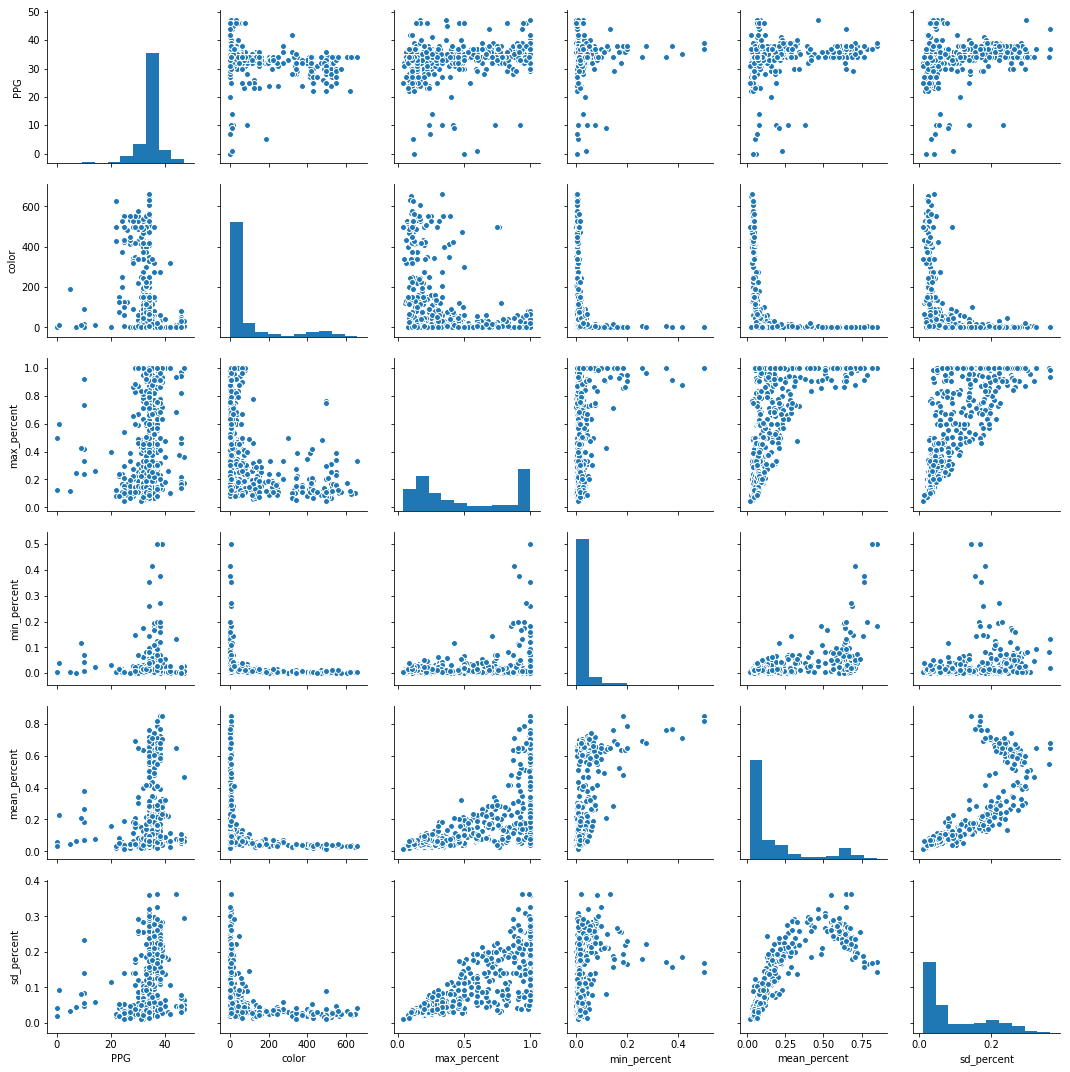

In [157]:
sns.pairplot(Xg)

The distributions for color, mean_percent, sd_percent, and min_percent are all heavily right skewed. In order to cluster, I'll transform these categories using a log transformation to make the distribution approximately more normal, then scale and cluster

In [158]:
log_cols = ['sd_percent', 'mean_percent', 'min_percent', 'color']
for col in log_cols:
    Xg[col] = np.log1p(Xg[col]+1)

In [159]:
ss = StandardScaler()
Xg_sc = ss.fit_transform(Xg)

In this case, I have relatively few features so I'm not going to use any dimensionality reduction techniques for clustering. I may use them for building visualizations after the clustering is complete. In order to judge my clustering, I'll be looking at the silhouette score using scikit-learn's built in metric, and the inertia finding metric I've used below

In [160]:
def inertia (data, labels):
    centroids = np.zeros((len(set(labels)), data.shape[1]))
    inertia = 0
    data_sorted = [[] for _ in range(centroids.shape[0])]
    for i in range(data.shape[0]):
        data_sorted[labels[i]].append(data[i].tolist())
    for i in range(centroids.shape[0]):
        km = KMeans(n_clusters=1).fit(data_sorted[i])
        centroids[i] = km.cluster_centers_
    for i in range(len(data_sorted)):
        for j in range(len(data_sorted[i])):
            inertia += np.linalg.norm(data_sorted[i][j]-centroids[i])**2
    return inertia    

In [161]:
agg = AgglomerativeClustering(n_clusters=20)
agg_labels = agg.fit_predict(Xg_sc)
print(silhouette_score(Xg_sc, agg_labels))
print(inertia(Xg_sc, agg_labels))

0.25641042344372955
397.1269797742076


A silhouette score of approximately 0.26 isn't bad, but neither does it indicate strong clustering. I'll create some visuals to evaluate the effectiveness of this clustering below

[0.58348282 0.74395119 0.87465259 0.95233457 0.98674688 1.        ]


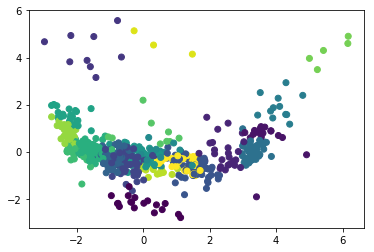

In [162]:
pca = PCA()
Xg_pca = pca.fit_transform(Xg_sc)
print(np.cumsum(pca.explained_variance_ratio_))
plt.scatter(Xg_pca[:, 0], Xg_pca[:, 1], c=agg_labels)

While the pca features explain a large amount of the variance within the original data, plotting the first two is not helpful with visually identifying clusters. This may be because of the amount of unexplained variance remaning. Another feature reduction module is T-Stochastic Neighbor Embedding. Below I will use TSNE to visualize the same clustering

In [163]:
tsne = TSNE(perplexity=10, n_iter=5000, learning_rate=250, random_state=42)
Xg_tsne = tsne.fit_transform(Xg_sc)

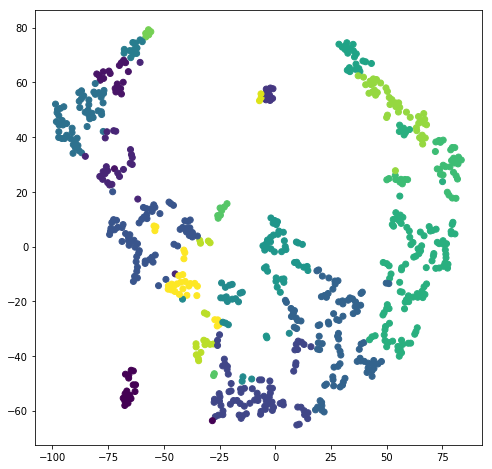

In [164]:
plt.figure(figsize=(8,8))
plt.scatter(Xg_tsne[:,0], Xg_tsne[:, 1], c=agg_labels)

With TSNE, these clusters appear much more distinct than with PCA. I'll also check the breakdown of the number of grains per cluster below

In [165]:
pd.Series(agg_labels).value_counts()

12    110
6      94
4      78
5      67
7      54
16     43
10     43
13     38
19     29
2      25
9      21
11     21
1      20
0      18
17     17
8      12
14      9
3       9
15      5
18      3
dtype: int64

This clustering appears to have an overwhelming number of grains in cluster 12. I'll look at which grains these are specifically below

In [166]:
grain_df['cluster_labels'] = agg_labels
grain_df[grain_df['cluster_labels']==12].describe()

PPG      color   times_used  max_percent  min_percent  \
count  110.000000  110.00000   110.000000   110.000000   110.000000   
mean    33.554545  115.00000   157.500000     0.176800     0.010411   
std      1.105336   60.99436   311.730616     0.063056     0.007956   
min     30.000000   34.00000     3.000000     0.055600     0.000500   
25%     33.000000   71.25000    24.250000     0.133400     0.004725   
50%     34.000000  107.50000    54.500000     0.174000     0.008950   
75%     34.000000  150.00000   129.750000     0.202550     0.014600   
max     36.000000  330.00000  1797.000000     0.333300     0.039900   

       mean_percent  sd_percent  cluster_labels  
count    110.000000  110.000000           110.0  
mean       0.053432    0.032256            12.0  
std        0.012411    0.007549             0.0  
min        0.029787    0.013488            12.0  
25%        0.042176    0.028219            12.0  
50%        0.052340    0.030862            12.0  
75%        0.063006    0.036489            12.0  
max        0.091411    0.058454            12.0

In [167]:
grain_df[grain_df['cluster_labels']==12]

PPG  color                    name  \
37    35    130                aromatic   
38    35    112               special b   
43    30    220               special b   
56    34     65           crystal 65 uk   
67    33    150             crystal 150   
68    33     90              crystal 90   
77    32    180  candi sugar extra dark   
78    32     45       candi sugar amber   
99    34    130        extra special us   
103   34     75   caramel crystal 75 us   
110   34     75            dark crystal   
119   34    148               special b   
122   34    130                aromatic   
123   34    127            chocolate us   
147   32    275        candi sugar dark   
150   34     80   caramel crystal 80 us   
154   33    110             crystal 110   
156   33    150          crystal 135 uk   
157   33     75   caramel crystal 75 us   
165   34    150                aromatic   
178   32    197          pale chocolate   
180   34     56            caramunich i   
188   33    100             crystal 100   
189   34     55          crystal medium   
215   34    200          pale chocolate   
223   33    105       crystal 95 115 uk   
224   31    244           chocolate rye   
231   34    220          pale chocolate   
237   34    140            dark crystal   
240   34     48              caramunich   
..   ...    ...                     ...   
558   34    118               special b   
564   34    250               chocolate   
565   34     47              cara 45 be   
566   34     77              crystal uk   
567   32    245           chocolate rye   
571   33     80      dark crystal 80 uk   
578   35     56            caramunich i   
581   34     80       caramel munich 80   
584   35     43           caramel wheat   
588   31    150                   brown   
596   33    135          crystal 135 uk   
598   33     90          crystal rye uk   
603   34     50      caramel crystal 50   
632   33    130        extra special us   
633   33    150  caramel crystal 150 us   
635   36    150               coffee uk   
637   34     46            cara gold be   
652   35     34          carastan 30 uk   
653   34    130               special b   
661   33     75         carabohemian de   
665   34     45           caramunich 45   
673   34    100             crystal 100   
676   34     77         crystal dark 77   
699   34    135          crystal 135 uk   
701   34    150               special b   
702   33    116             rye crystal   
709   32    150             crystal 150   
711   33    225          pale chocolate   
713   34     60            caramunich i   
714   34     65              crystal 60   

                                              percents  times_used  \
37   [0.0392, 0.04, 0.0357, 0.0329, 0.0333, 0.0333,...         207   
38   [0.0294, 0.0616, 0.0312, 0.052, 0.0161, 0.0659...        1666   
43   [0.0083, 0.025, 0.0357, 0.0303, 0.035, 0.0192,...        1113   
56   [0.0714, 0.0417, 0.1035, 0.0909, 0.0861, 0.043...          95   
67   [0.0526, 0.0339, 0.04, 0.0276, 0.0345, 0.0041,...         154   
68   [0.0526, 0.0442, 0.02, 0.0442, 0.0289, 0.0247,...         787   
77   [0.0449, 0.0516, 0.0588, 0.0592, 0.0606, 0.111...          61   
78   [0.0449, 0.0494, 0.0508, 0.0508, 0.1, 0.037, 0...          54   
99   [0.029, 0.0132, 0.0615, 0.0952, 0.0476, 0.0684...          86   
103  [0.0244, 0.0508, 0.0303, 0.0145, 0.0615, 0.076...         324   
110  [0.025, 0.05, 0.0994, 0.0385, 0.0294, 0.0702, ...         129   
119  [0.0265, 0.0217, 0.0391, 0.0323, 0.0336, 0.015...         109   
122  [0.0217, 0.0048, 0.098, 0.0444, 0.0227, 0.0514...         575   
123  [0.0406, 0.0226, 0.0115, 0.0349, 0.0113, 0.020...         727   
147  [0.0549, 0.05, 0.0896, 0.02, 0.0566, 0.1, 0.03...          71   
150  [0.0426, 0.0909, 0.0425, 0.0541, 0.0833, 0.092...         152   
154  [0.0611, 0.0782, 0.0741, 0.053, 0.1151, 0.0792...          25   
156  [0.0115, 0.0253, 0.1053, 0.046, 0.0857, 0.056,...         129   
157  [0.

While the grains in this cluster are those that tend to be used in smaller amounts and have relatively small standard deviations in their use, the differences in color are pretty large. I'll try some other clustering approaches below

0.17527041848059802
2296.094299650573


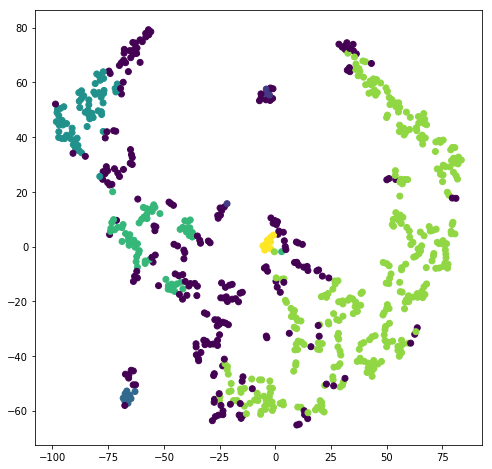

In [168]:
hdb = HDBSCAN()
hdb_labels = hdb.fit_predict(Xg_sc)
print(silhouette_score(Xg_sc, hdb_labels))
print(inertia(Xg_sc, hdb_labels))

plt.figure(figsize=(8,8))
plt.scatter(Xg_tsne[:,0], Xg_tsne[:, 1], c=hdb_labels)

Clustering with HDBSCAN appears to be significantly less effective than agglomerative clustering

In [169]:
pd.Series(hdb.labels_).value_counts()

 4    334
-1    236
 2     62
 3     61
 1      9
 5      9
 0      5
dtype: int64

The HDBSCAN left a huge number of the grains unclustered and was even worse about creating a large grouping than the agglomerative clustering approach. Below I'll try some other approaches

0.2451229837151672
282.47878653338114


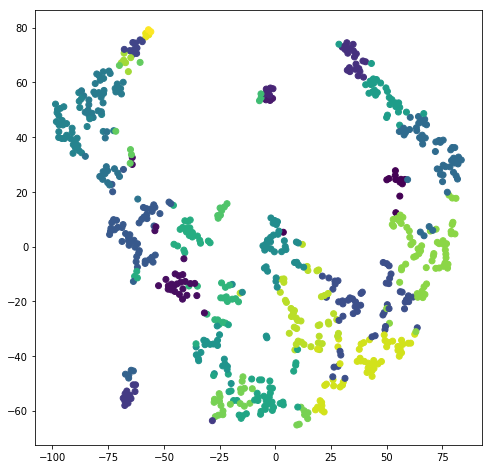

In [170]:
aff = AffinityPropagation(damping=0.8)
aff_labels = aff.fit_predict(Xg_sc)
print(silhouette_score(Xg_sc, aff_labels))
print(inertia(Xg_sc, aff_labels))

plt.figure(figsize=(8,8))
plt.scatter(Xg_tsne[:,0], Xg_tsne[:, 1], c=aff_labels)

In [171]:
pd.Series(aff_labels).value_counts()

24    62
7     53
10    51
27    51
8     49
26    43
17    41
12    35
14    35
13    34
16    29
23    27
1     27
18    25
15    23
4     21
19    18
11    15
5     13
0     12
6     10
21     7
9      6
22     6
3      6
25     6
28     3
20     3
2      3
29     2
dtype: int64

0.2710599752691247
440.743920028503


/anaconda3/lib/python3.6/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


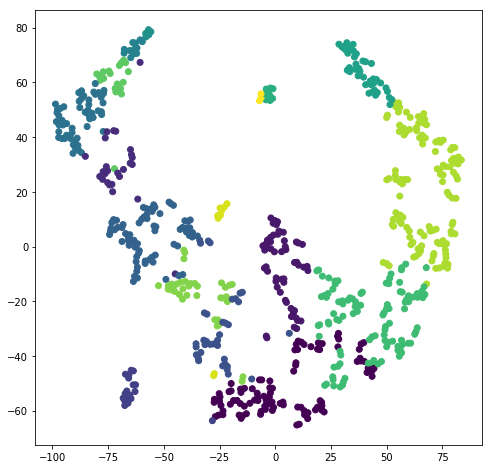

In [172]:
birch = Birch(n_clusters=17, threshold=0.1)
birch_labels = birch.fit_predict(Xg_sc)
print(silhouette_score(Xg_sc, birch_labels))
print(inertia(Xg_sc, birch_labels))

plt.figure(figsize=(8,8))
plt.scatter(Xg_tsne[:,0], Xg_tsne[:, 1], c=birch_labels)

In [173]:
pd.Series(birch_labels).value_counts()

14    122
11    106
0      96
5      70
1      54
6      54
9      40
13     36
4      36
2      26
12     20
3      18
7      12
10      9
15      9
8       5
16      3
dtype: int64

Text(0, 0.5, 'SSE')

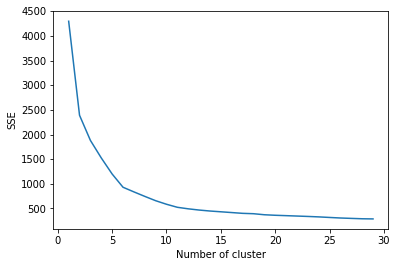

In [174]:
sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(Xg_sc)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

It appears the optimal number of clusters according to the elbow method for K-Means is approximately 7. I think it is likely that there are more than seven categories of grains, so below I will use K-Means with various numbers of clusters, including 7.

In [175]:
km = KMeans(n_clusters=7)
km_labels = km.fit_predict(Xg_sc)
silhouette_score(Xg_sc, km_labels)

0.3607520056684507

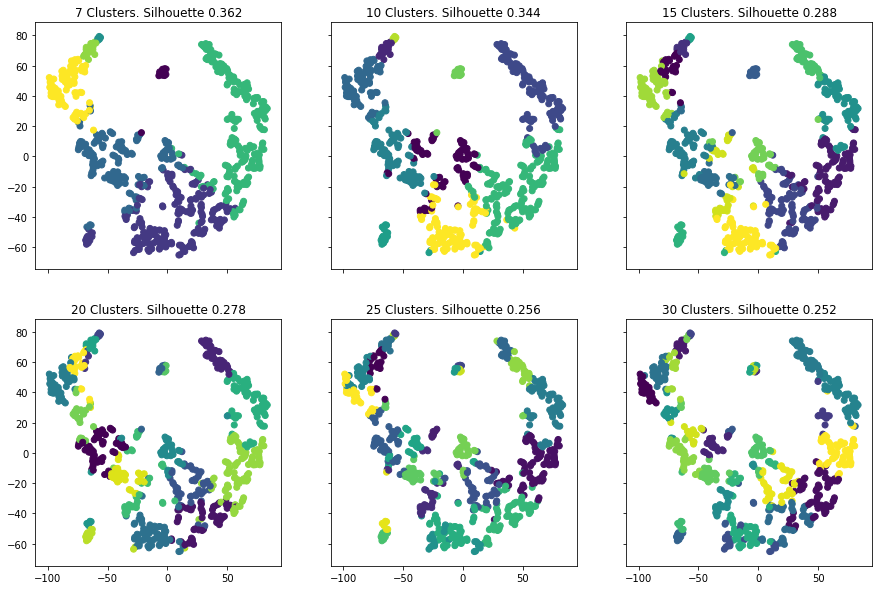

In [176]:
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,10))
for i, k in enumerate([7, 10, 15, 20, 25, 30]):
    kmeans=KMeans(n_clusters=k)
    km_labels = kmeans.fit_predict(Xg_sc)
    ax[i//3, i%3].scatter(Xg_tsne[:,0], Xg_tsne[:, 1], c=km_labels)
    score = round(silhouette_score(Xg_sc, km_labels), 3)
    ax[i//3, i%3].set_title(f'{k} Clusters. Silhouette {score}')

As of now, the K-Means clustering with 7 or 10 clusters appears to be my best approach in terms of intertia, silhouette scores, and visual inspection. I'll also try clustering the aggregated grain dataframe I created earlier.

In [177]:
grains.head()

PPG_min  PPG_max   PPG_mean   PPG_std  color_min  color_max  \
name                                                                 
abbey       33       36  34.333333  1.527525         17         19   
acid        27       33  29.000000  3.464102          2          3   
agave       34       39  35.666667  2.886751          5         40   
ale         34       38  35.333333  2.309401          2          5   
amber       30       36  33.000000  1.772811          5         60   

       color_mean  color_std  \
name                           
abbey   17.666667   1.154701   
acid     2.333333   0.577350   
agave   16.666667  20.207259   
ale      3.333333   1.527525   
amber   34.125000  18.224297   

                                                percents  times_used  \
name                                                                   
abbey  [0.0524, 0.0909, 0.3249, 0.1702, 0.4828, 0.25,...         315   
acid   [0.0714, 0.0209, 0.0584, 0.0282, 0.0256, 0.027...        2235   
agave  [0.0834, 0.0516, 0.0338, 0.1278, 0.0317, 0.039...         105   
ale    [0.6102, 1.0, 0.8696, 0.8182, 0.9075, 0.9353, ...         169   
amber  [0.0909, 0.0302, 0.1882, 0.0296, 0.0909, 0.028...        1271   

       max_percent  min_percent  mean_percent  sd_percent  
name                                                       
abbey       0.9362       0.0087      0.116741    0.118773  
acid        0.3333       0.0008      0.038945    0.040566  
agave       0.7905       0.0024      0.118393    0.116502  
ale         1.0000       0.1427      0.763234    0.183446  
amber       1.0000       0.0013      0.093242    0.098959

In [178]:
excluded_cols = ['percents', 'times_used']
Xg_agg = grains.drop(excluded_cols, axis=1)

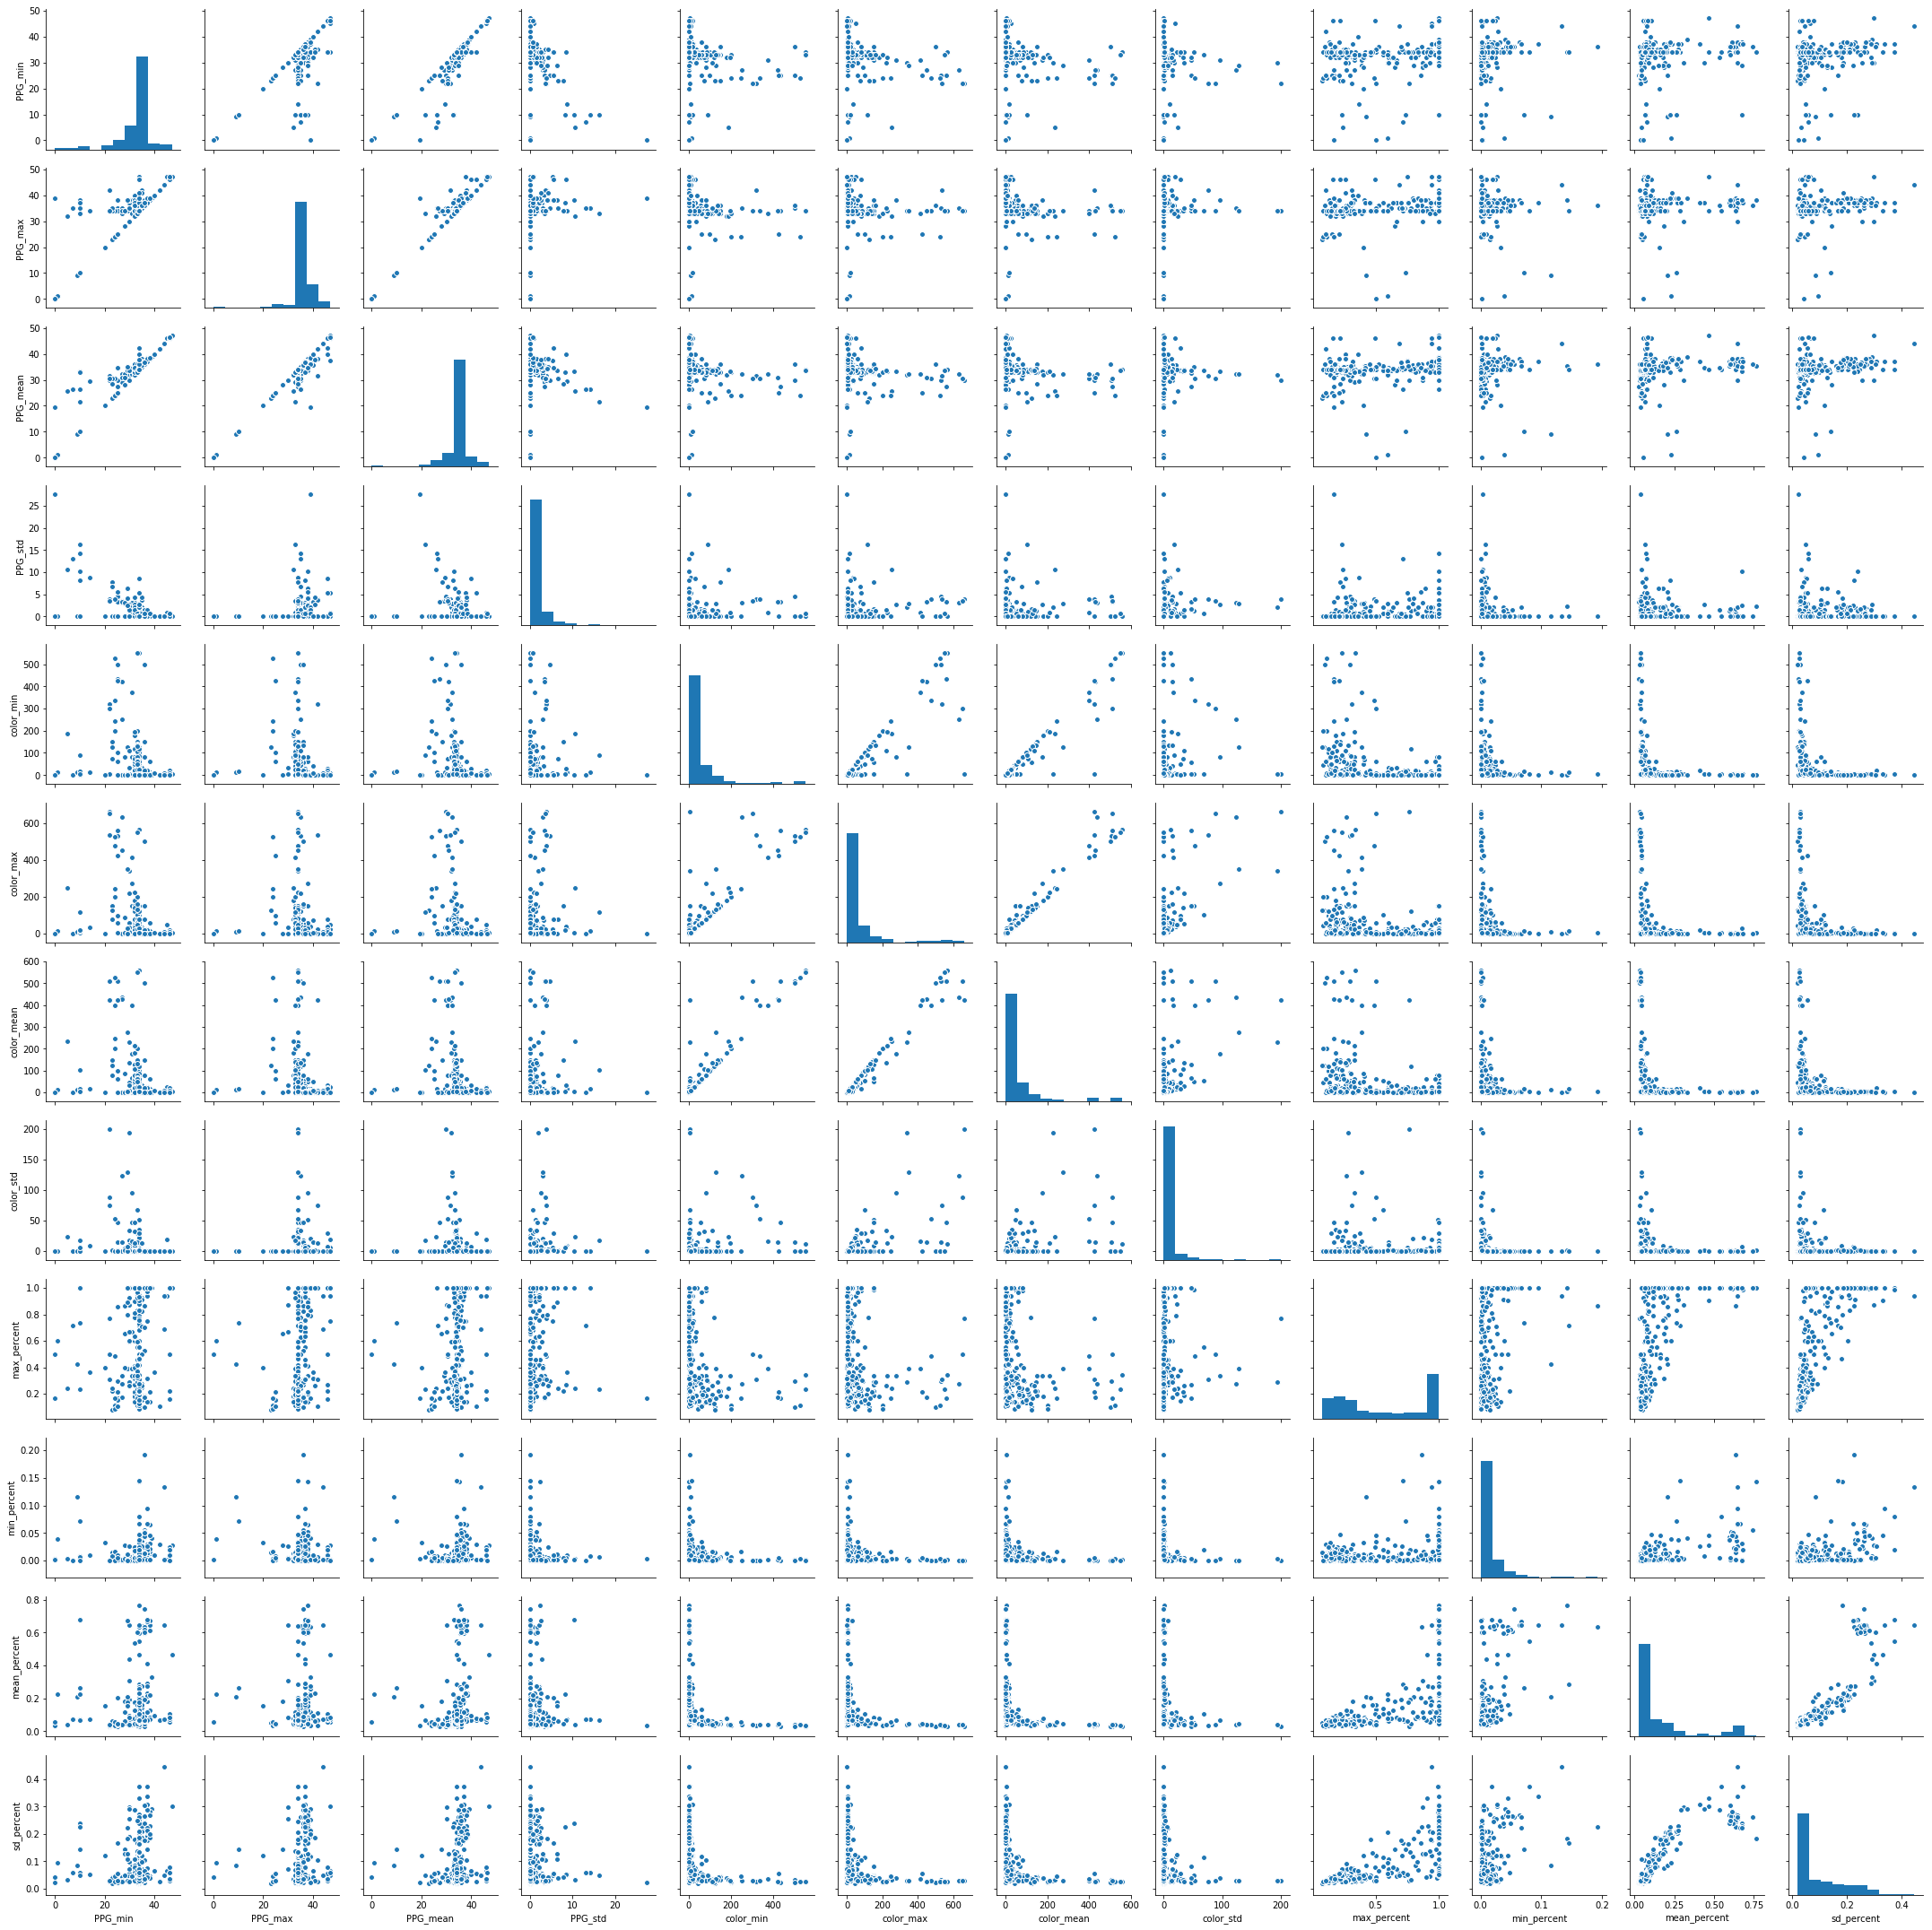

In [179]:
sns.pairplot(Xg_agg)

Again I'll correct the skewed columns with a log transformation

In [180]:
skewed_cols = ['sd_percent', 'mean_percent', 'min_percent', 'color_std', 'color_mean',
               'color_max', 'color_min', 'PPG_std']

for col in skewed_cols:
    Xg_agg[col] = np.log1p(Xg_agg[col]+1)

Xg_agg_sc = StandardScaler().fit_transform(Xg_agg)

I want to try a variety of clustering approaches, so I'll write a function that will take in a clustering object, find the silhouette score and plot the visualization of the clustering using TSNE

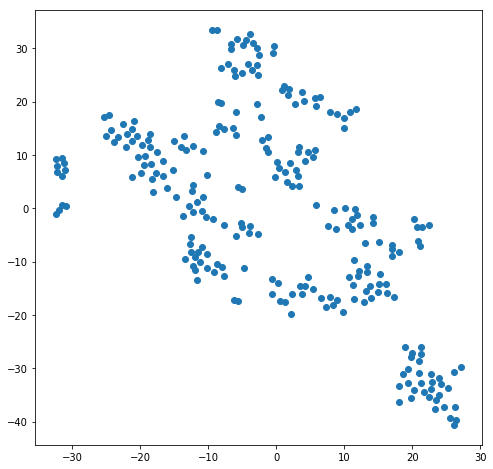

In [181]:
tsne_agg = TSNE(perplexity=15, n_iter=3000, learning_rate=250)
Xg_agg_tsne = tsne_agg.fit_transform(Xg_agg_sc)
plt.figure(figsize=(8,8))
plt.scatter(Xg_agg_tsne[:,0], Xg_agg_tsne[:,1])

In [182]:
def cluster_eval(clusterer, name, data, points):
    new_points = pd.DataFrame(points, columns = ['x', 'y'])
    labels = clusterer.fit_predict(data)
    new_points['labels'] = labels
    score = silhouette_score(data, labels)
    sns.lmplot('x', 'y', new_points, fit_reg=False, hue = 'labels', size=8)
    plt.title(f'Name: {name}   Score: {score}', size=14);
    print(inertia(data, labels))
    return pd.Series(labels).value_counts()

741.3062501459362


1     46
7     44
3     43
0     39
4     26
6     20
2     10
10     7
9      7
5      5
8      4
dtype: int64

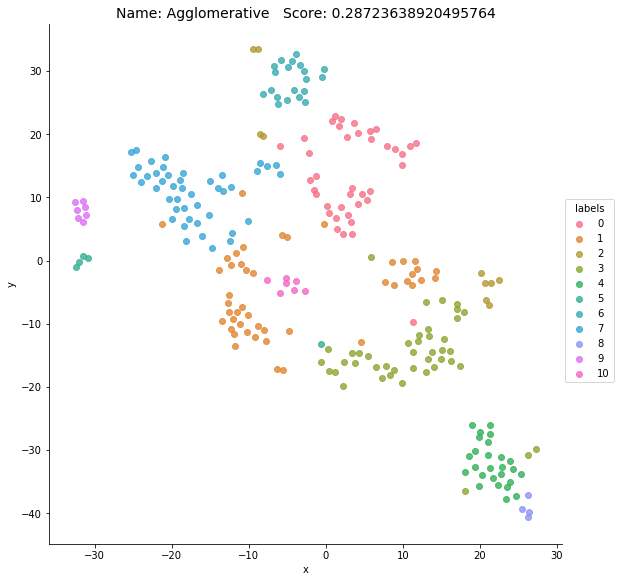

In [183]:
agg2 = AgglomerativeClustering(n_clusters=11)
cluster_eval(agg2, 'Agglomerative', Xg_agg_sc, Xg_agg_tsne)

2762.94563228822


 1    211
-1     34
 0      6
dtype: int64

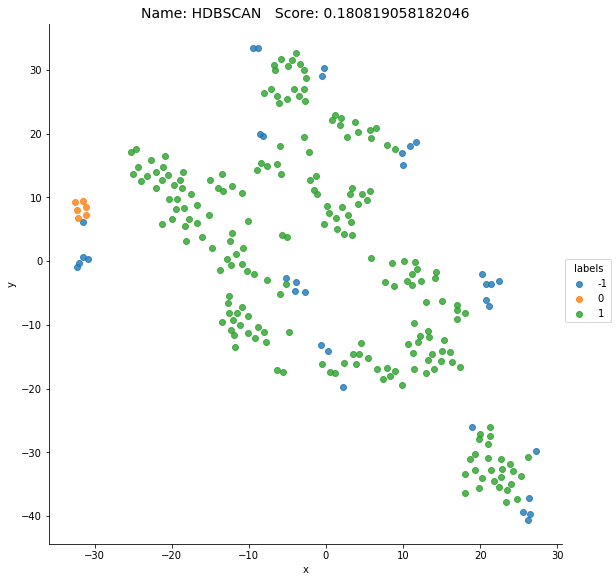

In [184]:
hdb2 = HDBSCAN()
cluster_eval(hdb2, 'HDBSCAN', Xg_agg_sc, Xg_agg_tsne)

445.9047796145009


10    41
12    25
0     23
17    19
2     18
4     18
5     17
3     16
18    12
13    11
8     10
16     7
11     6
19     5
15     5
1      5
9      3
6      3
14     3
7      2
20     2
dtype: int64

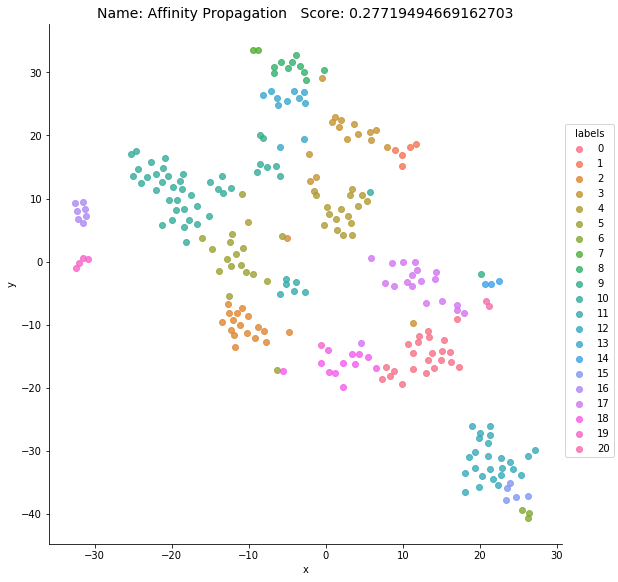

In [185]:
aff2 = AffinityPropagation(damping=0.95)
cluster_eval(aff2, 'Affinity Propagation', Xg_agg_sc, Xg_agg_tsne)

/anaconda3/lib/python3.6/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


515.1893551336163


1     41
2     26
4     26
8     23
14    18
15    17
5     17
3     15
6     11
17     9
16     8
11     8
10     7
13     7
7      6
9      4
12     4
0      4
dtype: int64

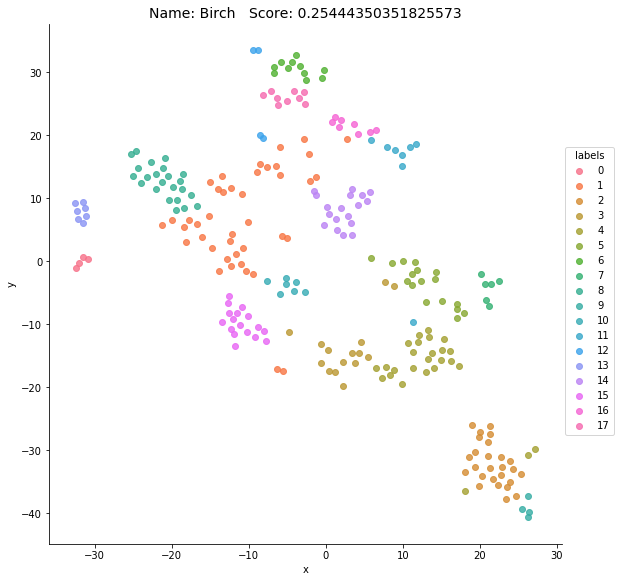

In [186]:
birch2 = Birch(n_clusters=18, threshold=.25, branching_factor=70)
cluster_eval(birch2, 'Birch', Xg_agg_sc, Xg_agg_tsne)

537.3828080679289


3     32
10    27
5     27
4     27
15    24
11    22
2     22
12    13
9     12
1     10
0      8
13     7
8      6
14     5
6      5
7      4
dtype: int64

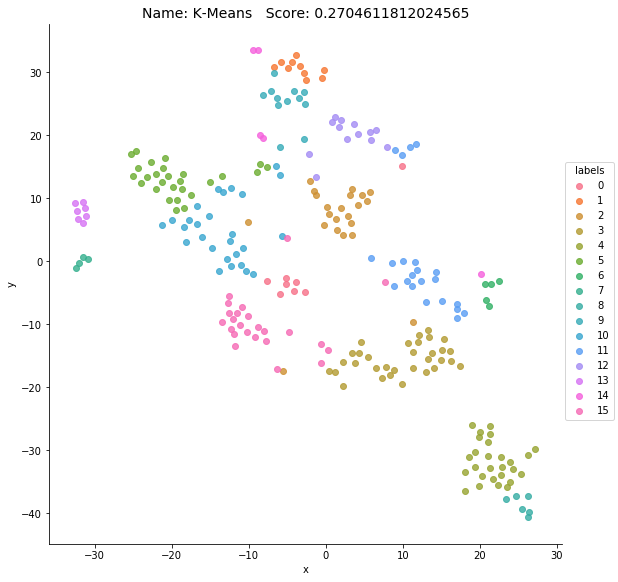

In [187]:
km = KMeans(n_clusters=16, random_state=42)
cluster_eval(km, 'K-Means', Xg_agg_sc, Xg_agg_tsne)

In [188]:
km.inertia_

537.3828080679289

At this point, my two best performing models seem to be the Kmeans clustering with 10 centroids on the individual grains, and the Kmeans clustering with 16 centroids on the aggregated grains. I'll look at example clusters from both below

In [189]:
grain_df['cluster_labels'] = KMeans(n_clusters=10, random_state=42).fit_predict(Xg_sc)
grain_df[grain_df['cluster_labels']==1].describe()

PPG       color    times_used  max_percent  min_percent  \
count  86.000000   86.000000     86.000000    86.000000    86.000000   
mean   33.500000   19.174419   1103.209302     0.805783     0.009466   
std     2.247875   21.794868   2094.587249     0.166316     0.009554   
min    25.000000    0.000000     22.000000     0.483000     0.000400   
25%    33.000000    3.250000    106.250000     0.666175     0.001850   
50%    34.000000   10.000000    280.500000     0.821450     0.007350   
75%    35.000000   24.500000    848.250000     0.978700     0.012450   
max    38.000000  120.000000  12751.000000     1.000000     0.046500   

       mean_percent  sd_percent  cluster_labels  
count     86.000000   86.000000            86.0  
mean       0.106927    0.099255             1.0  
std        0.043202    0.037379             0.0  
min        0.041034    0.033161             1.0  
25%        0.071640    0.064641             1.0  
50%        0.090337    0.102093             1.0  
75%        0.146967    0.131555             1.0  
max        0.209852    0.190867             1.0

In [190]:
grain_df[grain_df['cluster_labels']==1]

PPG  color                   name  \
2     35     10           munich light   
6     34     10     caramel crystal 10   
8     30      8                 cara 8   
13    36      1        torrified wheat   
14    32    120            crystal 120   
15    34     60             crystal 60   
17    34      0               carapils   
19    34     40             crystal 40   
20    33     20                  amber   
23    34      2           flaked wheat   
29    37     23               honey ca   
34    34     20  caramel crystal 20 us   
40    35      1                  honey   
47    33     80  caramel crystal 80 us   
52    32      1          flaked barley   
53    34      1               carapils   
57    35     20            munich dark   
59    35      9            carahell de   
63    34     28             victory us   
65    35     23                biscuit   
81    30     10                 munich   
88    29      3                 rye us   
96    35     15              munich 15   
100   37     10              munich 10   
117   32     27                  amber   
120   34     17                  abbey   
121   34     34           caramunich i   
131   34      3                    rye   
137   35     22               aromatic   
141   33      1               carapils   
..   ...    ...                    ...   
343   34      5           clover honey   
386   35     10    orgaic light munich   
399   31     20                two row   
406   30     60                  amber   
410   33      2            oats malted   
414   37     12            munich dark   
416   34     20             carared de   
437   35     10     caramel crystal 10   
441   25      5               wheat be   
447   32      1                   rice   
471   34      6              munich uk   
478   28      2                    oat   
483   33     10                 munich   
489   34      5               spelt de   
519   34      2      cherrywood smoked   
524   28      2             barley raw   
533   34     10           munich light   
544   29      2                 rye de   
549   34     32            munich dark   
550   34     40                  agave   
551   37      3    beechwood smoked de   
552   34      8           munich light   
601   32     65                  brown   
612   34     55          caramel wheat   
624   33     20            munich dark   
630   38      2              peated uk   
631   33     60           munich 60 us   
634   34      8               carapils   
638   33     17                  abbey   
650   35     17                cara uk   

                                              percents  times_used  \
2    [0.1, 0.1538, 0.3636, 0.0148, 0.1111, 0.2143, ...        4345   
6    [0.1538, 0.0455, 0.0457, 0.0376, 0.0769, 0.047...        2258   
8    [0.0455, 0.037, 0.1048, 0.049, 0.1249, 0.0492,...         131   
13   [0.0222, 0.0357, 0.1429, 0.0417, 0.025, 0.1111...         852   
14   [0.0222, 0.0651, 0.0438, 0.0455, 0.052, 0.0769...        4106   
15   [0.0164, 0.0219, 0.0616, 0.0616, 0.1756, 0.053...       12751   
17   [0.0497, 0.0625, 0.093, 0.1455, 0.0375, 0.052,...        1506   
19   [0.0219, 0.0909, 0.0863, 0.0231, 0.0596, 0.078...        9715   
20   [0.0909, 0.0302, 0.1882, 0.0296, 0.0909, 0.028...         543   
23   [0.0327, 0.1333, 0.0388, 0.1333, 0.0835, 0.181...        3220   
29   [0.0333, 0.1154, 0.0506, 0.08, 0.0833, 0.0351,...        2807   
34   [0.0357, 0.0714, 0.05, 0.1489, 0.0625, 0.0457,...        3689   
40   [0.0876, 0.0889, 0.087, 0.0465, 0.1701, 0.0833...         187   
47   [0.0909, 0.0549, 0.0333, 0.1533, 0.0893, 0.025...        4017   
52   [0.0235, 0.052, 0.0396, 0.0741, 0.0333, 0.0851...        2366   
53   [0.0235, 0.0176, 0.0678, 0.05, 0.0596, 0.0294,...        7600   
57   [0.0909, 0.0827, 0.0343, 0.1702, 0.1667, 0.051...         537   
59   [0.0288, 0.08, 0.0312, 0.0702, 0.0202, 0.0312,...         637   
63   [0.0312, 0.0417, 0.0549, 0.027, 0.0463, 0.0444...        4680   


The first cluster from Kmeans appears to be mostly pale malts used for relatively small percentages of the grain bill. There are some odd combinations, such as the crystal 120 and the brown malt. I'll look at another cluster below

In [191]:
grain_df[grain_df['cluster_labels']==7]

PPG  color                      name  \
1     37      1                   two row   
3     36      1                   pilsner   
4     36      3                  pale ale   
5     37      1                   pilsner   
7     36      2                   two row   
25    34      3                  pale ale   
26    37      3                  pale ale   
30    38      4       maris otter pale uk   
35    35      2                   two row   
36    38      3              pale halcyon   
45    37      2                  pale ale   
46    37      3                   two row   
64    36      3                   two row   
71    38      3       maris otter pale uk   
89    38      3                   pale uk   
93    34      2                   two row   
95    34      3                     pearl   
97    36      1                   two row   
104   38      1                   two row   
106   37      2                   two row   
107   36      2       maris otter pale uk   
109   35      5  floor malted maris otter   
114   35      2                    pilsen   
125   34      4            maris otter uk   
135   34      3                   two row   
146   34      2                   pilsner   
153   34      3               maris otter   
167   36      1                six row us   
170   37      2                     pearl   
176   34      5                   two row   
..   ...    ...                       ...   
381   38      2                  pale ale   
384   36      5                  mild ale   
435   34      1                    pilsen   
452   37      3                      pale   
469   34      3                  mild ale   
470   36      1                  lager uk   
477   35      1                six row us   
497   38      3       pale golden promise   
503   34      2                six row us   
504   34      5                    millet   
521   34      2         golden promise uk   
522   39      2                  pale ale   
523   36      2                   pilsner   
530   30      3                  esb pale   
534   36      2                halcyon uk   
535   37      3         golden promise uk   
545   33      6                   pilsner   
582   34      4                  mild ale   
605   37      3                  scottish   
609   34      5                   pilsner   
623   36      1                    pilsen   
627   37      2                   pale us   
628   37      2                 kolsch de   
640   38      6                   pilsner   
642   36      3                    esb ca   
647   30      5                  mild ale   
651   38      2                  optic uk   
658   37      3                  mild ale   
684   34      1                   pilsner   
715   37     20             sorghum syrup   

                                              percents  times_used  \
1    [0.4, 0.4615, 0.6206, 0.8569, 0.9091, 0.8182, ...       30429   
3    [0.6061, 0.7505, 0.6744, 0.3846, 0.1951, 0.859...         475   
4    [0.3939, 0.5542, 0.0833, 0.8, 0.7965, 0.2222, ...        1316   
5    [0.2308, 0.4411, 0.7387, 0.5006, 0.8, 0.5056, ...       12241   
7    [0.9091, 0.8667, 0.8824, 0.8667, 0.332, 0.64, ...        2098   
25   [0.3333, 0.856, 0.72, 0.9545, 0.8, 0.8333, 0.5...         609   
26   [0.1333, 0.8889, 0.7109, 0.381, 0.5882, 0.6667...        2082   
30   [0.5714, 0.8702, 0.7742, 0.7498, 0.8636, 0.449...         832   
35   [0.622, 0.8597, 0.8824, 0.3492, 0.8871, 0.5274...         281   
36   [0.4902, 0.7692, 0.7857, 0.9098, 0.1724, 0.8, ...          38   
45   [0.5, 0.8421, 0.2138, 0.7547, 0.9368, 0.8246, ...         672   
46   [0.9091, 0.4, 0.3902, 0.1818, 0.9474, 0.8001, ...         184   
64   [0.625, 0.8455, 0.5455, 0.267, 0.122, 0.8182, ...         446   
71   [0.8076, 0.2305, 0.8651, 0.6501, 0.381, 0.8014...        7580   
89   [0.6339, 0.75, 0.7843, 0.8276, 0.8462, 0.933, ...         158   
93   [0.8667, 0.7462, 0.6897, 0.8199, 0.625, 0.0606...         731   
95   [0.9404, 0.913, 0.3

The seventh cluster appears to be all of the base malts

In [194]:
grains['cluster_labels'] = KMeans(n_clusters=16, random_state=42).fit_predict(Xg_agg_sc)
grains[grains['cluster_labels']==1].describe()

PPG_min    PPG_max   PPG_mean    PPG_std   color_min   color_max  \
count  10.00000  10.000000  10.000000  10.000000   10.000000   10.000000   
mean   25.70000  35.400000  30.965125   3.370893  235.600000  500.500000   
std     3.40098   2.633122   1.728516   0.743077  174.036522  137.466157   
min    22.00000  34.000000  27.333333   2.000000    5.000000  275.000000   
25%    22.50000  34.000000  30.025240   2.931986   91.750000  381.250000   
50%    25.00000  34.000000  31.082609   3.490981  275.000000  532.500000   
75%    28.50000  35.000000  32.250000   3.838252  332.750000  612.500000   
max    31.00000  42.000000  33.285714   4.573474  500.000000  660.000000   

       color_mean   color_std   times_used  max_percent  min_percent  \
count   10.000000   10.000000    10.000000    10.000000     10.00000   
mean   388.657307  102.098082  3155.900000     0.380230      0.00117   
std    120.857210   60.458530  2885.215241     0.168381      0.00106   
min    176.428571   15.000000   411.000000     0.166700      0.00030   
25%    306.100000   59.031886   763.250000     0.287800      0.00060   
50%    423.299331   92.278507  2418.000000     0.321650      0.00070   
75%    489.656250  127.276370  4958.250000     0.460800      0.00125   
max    510.187500  199.838460  8052.000000     0.766400      0.00320   

       mean_percent  sd_percent  cluster_labels  
count     10.000000   10.000000            10.0  
mean       0.040307    0.029057             1.0  
std        0.011459    0.004409             0.0  
min        0.027468    0.021655             1.0  
25%        0.034862    0.028177             1.0  
50%        0.039095    0.029353             1.0  
75%        0.041232    0.030038             1.0  
max        0.069091    0.038751             1.0

In [195]:
grains[grains['cluster_labels']==1]

PPG_min  PPG_max   PPG_mean   PPG_std  color_min  color_max  \
name                                                                            
black                  22       34  29.846154  3.912505          5        660   
black barley           25       35  29.750000  4.573474        500        530   
black patent uk        25       34  27.333333  3.386247        432        560   
candi sugar dark       31       38  33.285714  2.627691         80        275   
carafa i               22       42  31.565217  3.811777        320        535   
chocolate              27       35  32.375000  3.067689        250        630   
chocolate be           30       34  32.000000  2.000000          5        340   
chocolate uk           24       34  30.600000  3.847077        337        475   
chocolate us           29       34  32.333333  2.886751        127        350   
roasted barley         22       34  30.562500  3.595715        300        650   

                  color_mean   color_std  \
name                                       
black             424.076923  199.838460   
black barley      507.500000   15.000000   
black patent uk   508.333333   47.373692   
candi sugar dark  176.428571   96.164542   
carafa i          422.521739   75.724302   
chocolate         436.125000  122.858150   
chocolate be      228.333333  193.412340   
chocolate uk      397.400000   53.467747   
chocolate us      275.666667  128.749110   
roasted barley    510.187500   88.392472   

                                                           percents  \
name                                                                  
black             [0.0084, 0.027, 0.0065, 0.0148, 0.037, 0.0107,...   
black barley      [0.0599, 0.0769, 0.0185, 0.04, 0.0741, 0.0345,...   
black patent uk   [0.0276, 0.0177, 0.0408, 0.0328, 0.0303, 0.02,...   
candi sugar dark  [0.0329, 0.0566, 0.0342, 0.0367, 0.0413, 0.037...   
carafa i          [0.0456, 0.029, 0.0556, 0.0357, 0.0625, 0.0426...   
chocolate         [0.1523, 0.0612, 0.045, 0.0265, 0.0256, 0.0455...   
chocolate be      [0.0091, 0.0217, 0.0341, 0.0106, 0.0375, 0.040...   
chocolate uk      [0.0443, 0.0876, 0.0312, 0.0104, 0.0536, 0.039...   
chocolate us      [0.0588, 0.0455, 0.0442, 0.0167, 0.0129, 0.024...   
roasted barley    [0.0443, 0.0235, 0.0308, 0.0792, 0.0496, 0.033...   

                  times_used  max_percent  min_percent  mean_percent  \
name                                                                   
black                   4218       0.7664       0.0006      0.029349   
black barley             458       0.2941       0.0014      0.041329   
black patent uk          788       0.1667       0.0008      0.027468   
candi sugar dark         868       0.3333       0.0030      0.069091   
carafa i                3968       0.3100       0.0008      0.033509   
chocolate                755       0.2725       0.0004      0.040941   
chocolate be             411       0.2857       0.0032      0.039014   
chocolate uk            5205       0.4848       0.0006      0.039176   
chocolate us            6836       0.3888       0.0003      0.044276   
roasted barley          8052       0.5000       0.0006      0.038920   

                  sd_percent  cluster_labels  
name                                          
black               0.028578               1  
black barley        0.030307               1  
black patent uk     0.021655               1  
candi sugar dark    0.038751               1  
carafa i            0.024478               1  
chocolate           0.028964               1  
chocolate be        0.029742               1  
chocolate uk        0.028043               1  
chocolate us        0.030047               1  
roasted barley      0.030009               1

The non-aggregated clustering of grains appears to better capture the information, so I'll use these features going forward as features for the recipes

## Clustering Hops

In [275]:
hops.head()

alpha_min  alpha_max  alpha_mean  alpha_std  \
name                                                                       
admiral uk                       0.105      0.148      0.1280   0.021656   
aged debittered hops lambic      0.020      0.020      0.0200   0.000000   
ahtanum us                       0.034      0.060      0.0474   0.007575   
amarillo                         0.084      0.084      0.0840   0.000000   
amarillo gold                    0.085      0.085      0.0850   0.000000   

                                                                      percents  \
name                                                                             
admiral uk                   [0.2395, 0.2, 0.2, 0.5117, 0.3172, 0.3636, 0.2...   
aged debittered hops lambic  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0946, 1....   
ahtanum us                   [0.3382, 0.3333, 0.1364, 0.3076, 0.24330000000...   
amarillo                         [0.2564, 0.1333, 0.1464, 0.38880000000000003]   
amarillo gold                                      [0.5, 0.1286, 0.0667, 0.47]   

                                                                 time_percents  \
name                                                                             
admiral uk                   [1.0, 0.16666666666666666, 1.0, 1.0, 0.75, 0.5...   
aged debittered hops lambic  [0.5, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, ...   
ahtanum us                   [0.5, 0.3333333333333333, 0.16666666666666666,...   
amarillo                     [0.16666666666666666, 0.0, 0.16666666666666666...   
amarillo gold                                                       [1.0, 0.0]   

                                                                         times  \
name                                                                             
admiral uk                   [60, 10, 60, 60, 45, 30, 60, 60, 15, 60, 60, 1...   
aged debittered hops lambic  [60, 60, 40, 120, 60, 120, 60, 5, 60, 60, 60, ...   
ahtanum us                   [30, 20, 10, 1, 60, 60, 5, 1, 20, 5, 25, 1, 15...   
amarillo                                                [10, 0, 10, 0, 60, 20]   
amarillo gold                                                          [60, 0]   

                                                                          boil  \
name                                                                             
admiral uk                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
aged debittered hops lambic  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...   
ahtanum us                   [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, ...   
amarillo                                                 [1, 1, 0, 1, 1, 1, 1]   
amarillo gold                                               [1, 0, 0, 0, 1, 0]   

                             use_count  boil_count  boil_pct  bittering_pct  \
name                                                                          
admiral uk                         221         200  0.904977       0.600000   
aged debittered hops lambic         31          29  0.935484       0.793103   
ahtanum us                        1433        1129  0.787858       0.143490   
amarillo                             7           6  0.857143       0.166667   
amarillo gold                        6           2  0.333333       0.500000   

                             flavoring_pct  finishing_pct  
name                                                       
admiral uk                        0.110000       0.290000  
aged debittered hops lambic       0.068966       0.137931  
ahtanum us                        0.172719       0.683791  
amarillo                          0.166667       0.666667  
amarillo gold                     0.000000       0.500000

In [276]:
hops['times_mean'] = [np.mean(x) for x in hops['time_percents'].values]
hops['times_sd'] = [np.std(x) for x in hops['time_percents'].values]

In [277]:
Xh = hops.drop(['percents', 'times', 'time_percents', 'boil', 'use_count', 'boil_count'], axis=1)

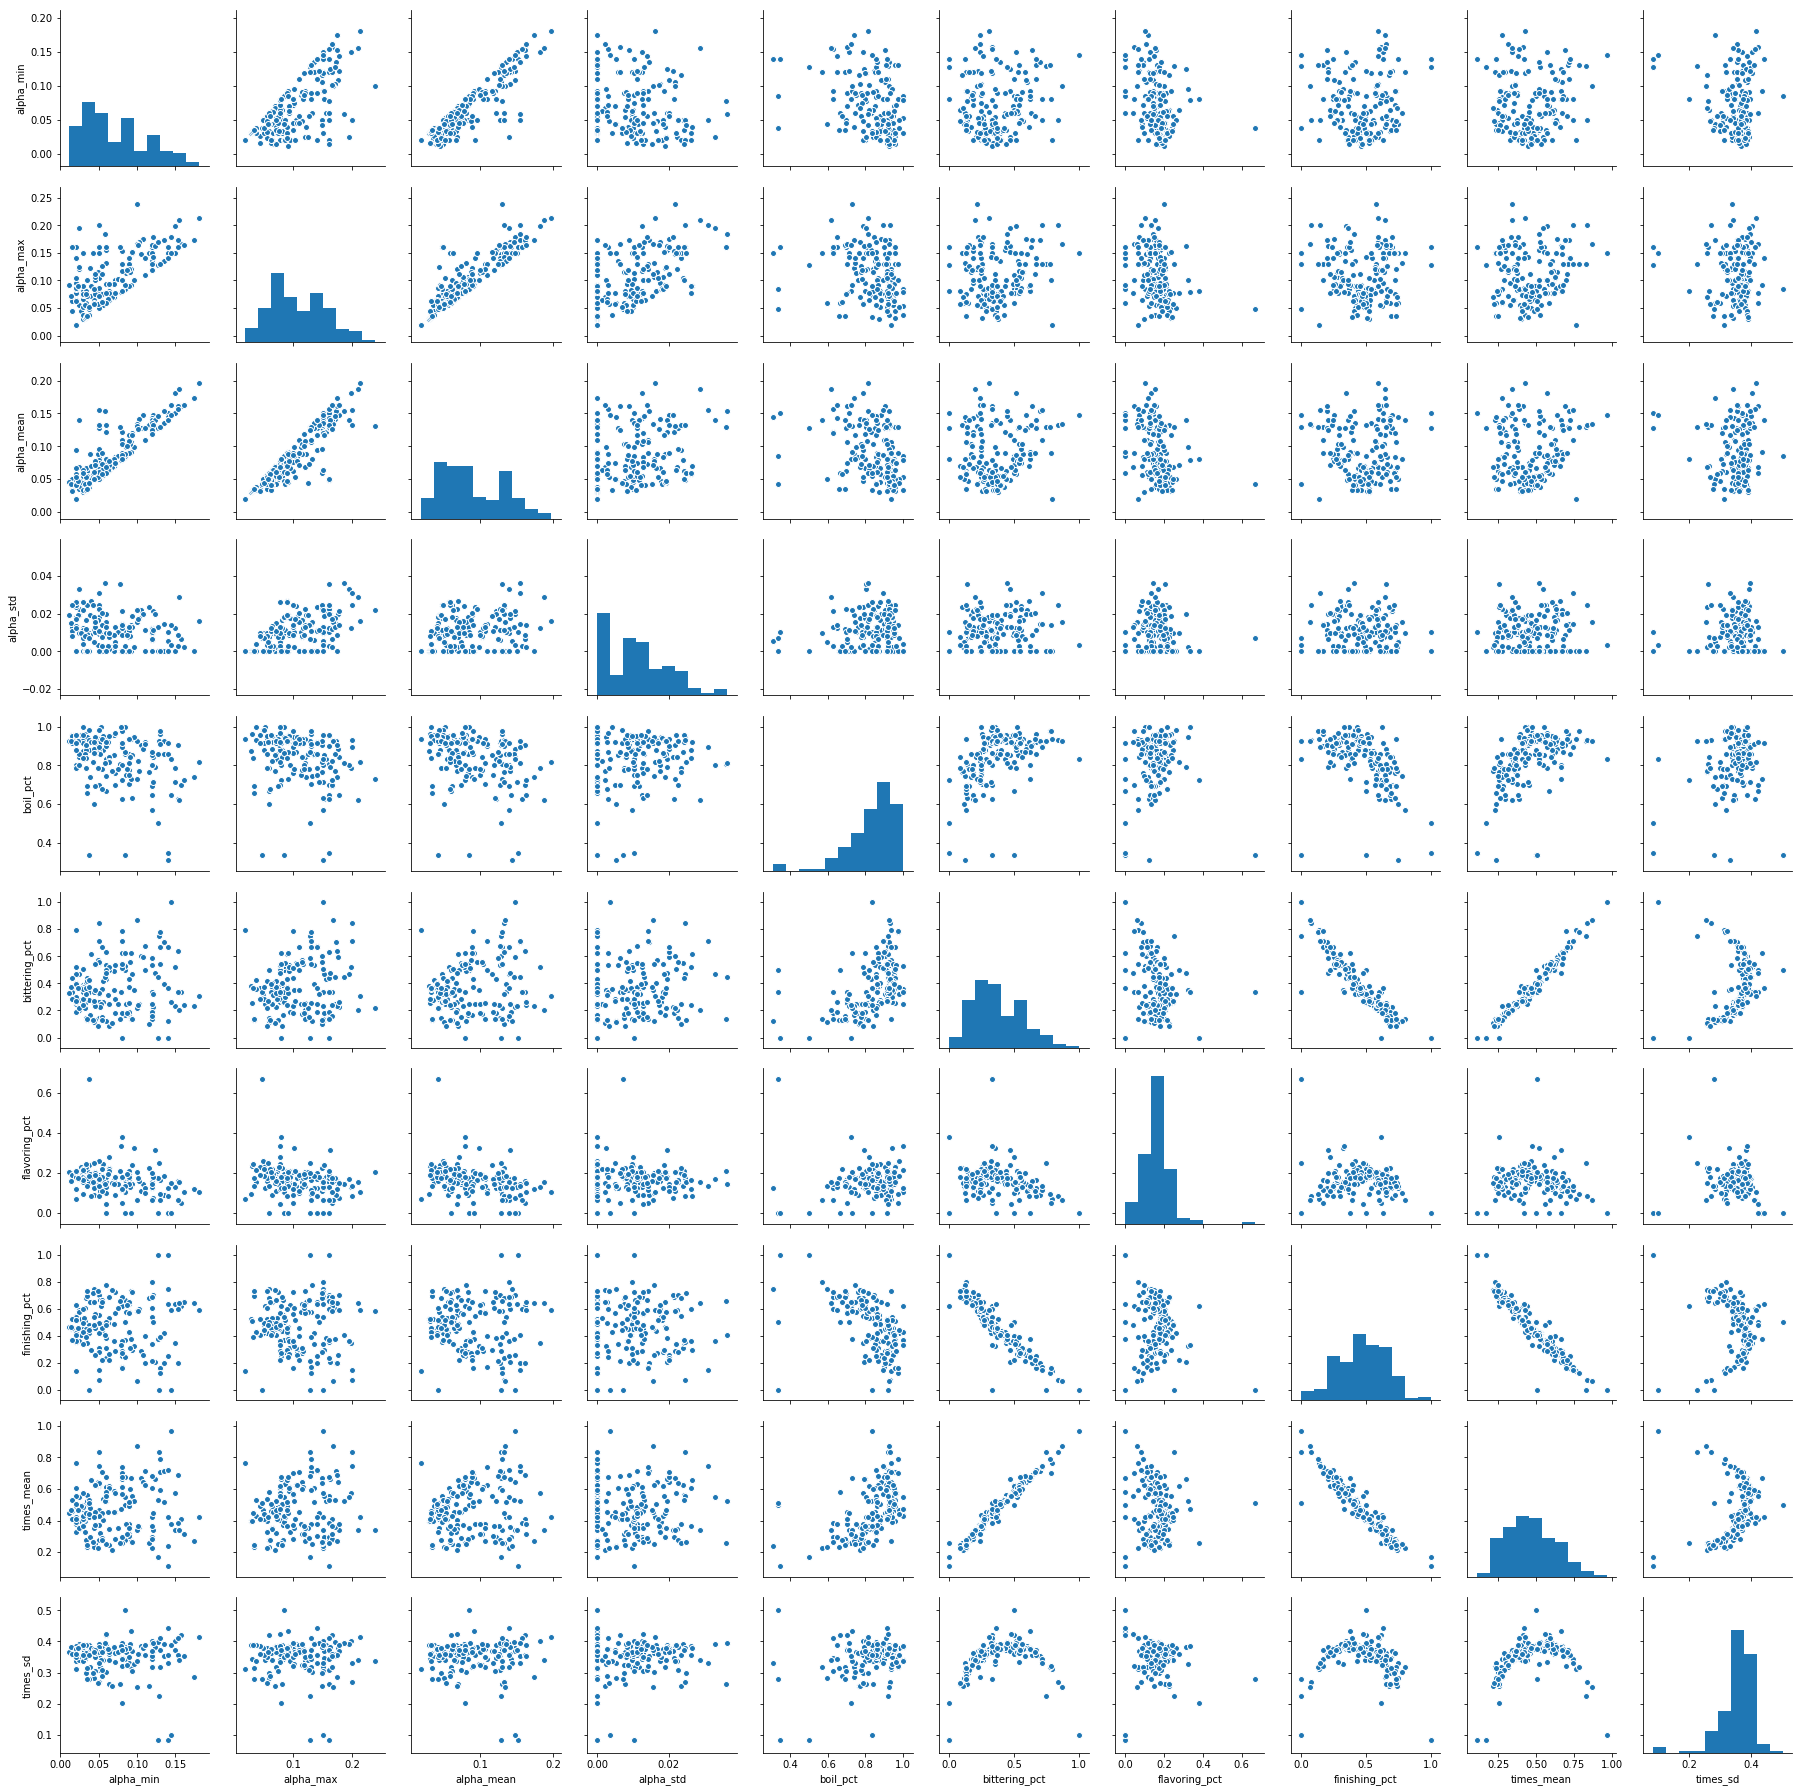

In [278]:
sns.pairplot(Xh)

In [279]:
Xh['boil_pct'] = Xh['boil_pct']*Xh['boil_pct']
Xh['alpha_std'] = np.log1p(Xh['alpha_std']+1)

In [280]:
Xh_sc = StandardScaler().fit_transform(Xh)

In [281]:
hop_tsne = TSNE(perplexity=15)
Xh_tsne = hop_tsne.fit_transform(Xh_sc)

349.14870618603805


5     29
12    22
11    17
3     14
0     12
6     12
13    11
1     10
7      9
2      8
16     8
4      5
9      3
14     3
8      2
15     1
10     1
dtype: int64

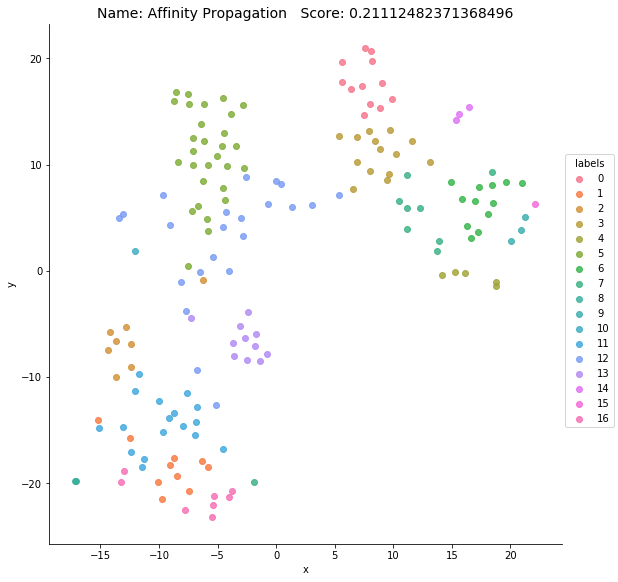

In [282]:
aff = AffinityPropagation(damping=0.7, max_iter=500)
cluster_eval(aff, 'Affinity Propagation', Xh_sc, Xh_tsne)

472.4051027215807


2     50
0     27
10    20
3     17
4     13
1     13
8     10
7     10
9      3
5      2
11     1
6      1
dtype: int64

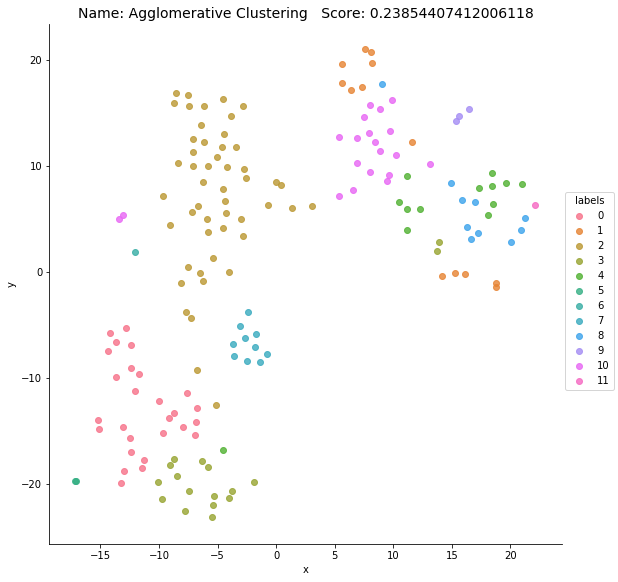

In [290]:
agg = AgglomerativeClustering(n_clusters=12)
cluster_eval(agg, 'Agglomerative Clustering', Xh_sc, Xh_tsne)

/anaconda3/lib/python3.6/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


347.5536714600802


1     51
0     18
4     18
10    10
2     10
5     10
8      9
7      7
12     6
14     6
6      5
3      5
9      3
17     3
16     2
15     2
11     1
13     1
dtype: int64

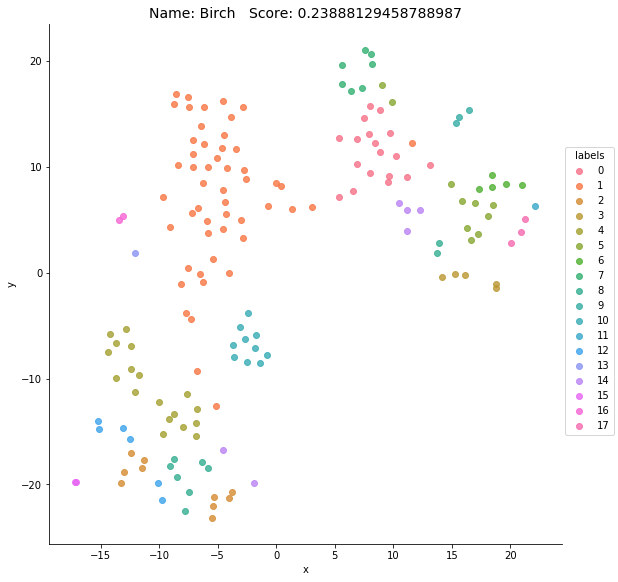

In [297]:
birch = Birch(n_clusters=18, branching_factor=45)
cluster_eval(birch, 'Birch', Xh_sc, Xh_tsne)

Text(0, 0.5, 'SSE')

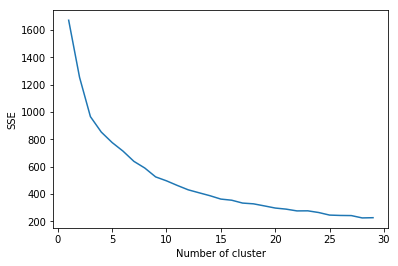

In [298]:
sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(Xh_sc)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

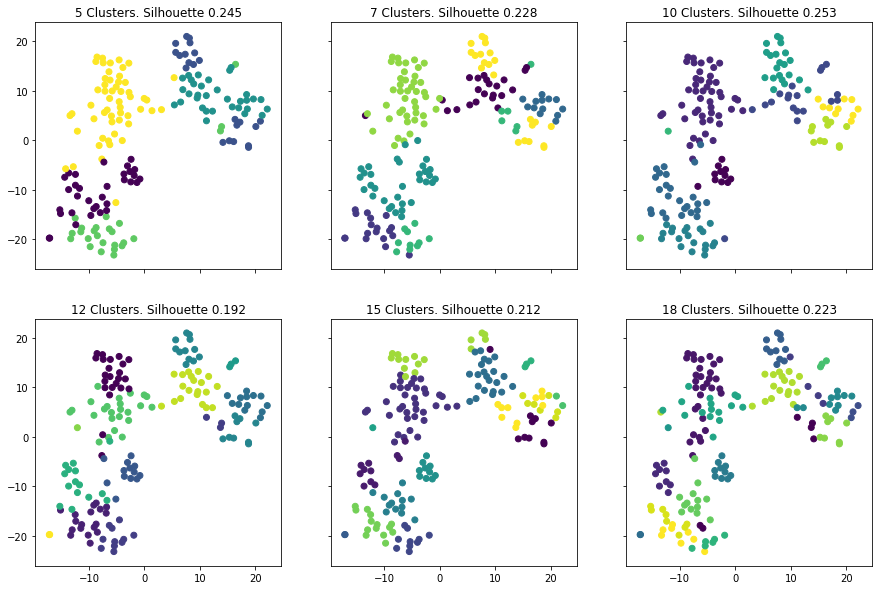

In [299]:
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,10))
for i, k in enumerate([5, 7, 10, 12, 15, 18]):
    kmeans=KMeans(n_clusters=k)
    km_labels = kmeans.fit_predict(Xh_sc)
    ax[i//3, i%3].scatter(Xh_tsne[:,0], Xh_tsne[:, 1], c=km_labels)
    score = round(silhouette_score(Xh_sc, km_labels), 3)
    ax[i//3, i%3].set_title(f'{k} Clusters. Silhouette {score}')

485.5083356819882


3    45
6    26
8    22
2    22
9    21
1    13
7    12
0     3
4     2
5     1
dtype: int64

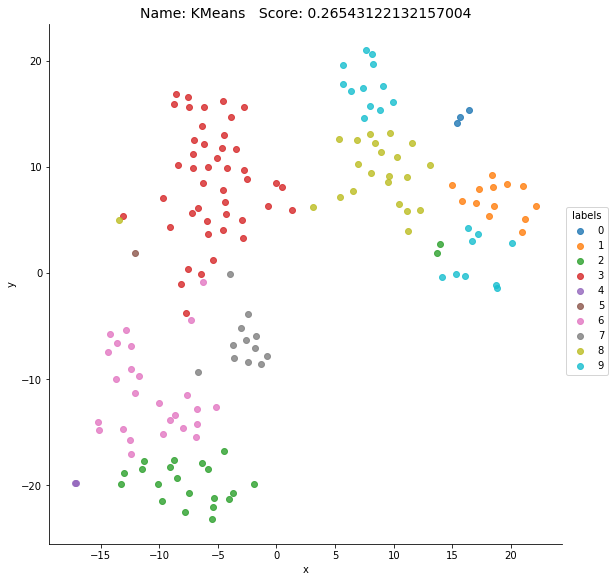

In [300]:
km = KMeans(n_clusters=10, random_state=42)
cluster_eval(km, 'KMeans', Xh_sc, Xh_tsne)

In [301]:
hops['cluster_label'] = km.fit_predict(Xh_sc)

In [304]:
hops[hops['cluster_label']==3].describe()

alpha_min  alpha_max  alpha_mean  alpha_std     use_count   boil_count  \
count  45.000000  45.000000   45.000000  45.000000     45.000000    45.000000   
mean    0.035489   0.066356    0.049933   0.009148   1639.911111  1522.844444   
std     0.015279   0.018349    0.012100   0.005959   2564.171201  2383.385636   
min     0.012000   0.030000    0.030000   0.000000      6.000000     6.000000   
25%     0.024000   0.053000    0.041800   0.004947     73.000000    63.000000   
50%     0.032000   0.067000    0.049034   0.009883    352.000000   320.000000   
75%     0.044000   0.078000    0.056000   0.012583   2216.000000  2096.000000   
max     0.079000   0.111000    0.079000   0.019266  10770.000000  9875.000000   

        boil_pct  bittering_pct  flavoring_pct  finishing_pct  times_mean  \
count  45.000000      45.000000      45.000000      45.000000   45.000000   
mean    0.923068       0.331568       0.191419       0.477014    0.445779   
std     0.040998       0.052886       0.042393       0.061690    0.045228   
min     0.833472       0.217082       0.088710       0.333333    0.326822   
25%     0.902782       0.283541       0.174377       0.438710    0.410727   
50%     0.926742       0.338966       0.187050       0.462810    0.447466   
75%     0.945873       0.369487       0.206987       0.519179    0.472222   
max     1.000000       0.423077       0.333333       0.653226    0.533626   

        times_sd  cluster_label  
count  45.000000           45.0  
mean    0.368841            3.0  
std     0.014353            0.0  
min     0.336076            3.0  
25%     0.360540            3.0  
50%     0.371193            3.0  
75%     0.379440            3.0  
max     0.389115            3.0

In [306]:
hops[hops['cluster_label']==3]

alpha_min  alpha_max  alpha_mean  alpha_std  \
name                                                                   
aramis fr                    0.030      0.030    0.030000   0.000000   
argentine cascade            0.032      0.032    0.032000   0.000000   
bobek                        0.038      0.052    0.045000   0.009899   
bramling cross uk            0.056      0.078    0.068200   0.009602   
cascade                      0.050      0.083    0.069000   0.009372   
czech saaz                   0.024      0.056    0.035455   0.009883   
delta us                     0.044      0.065    0.057000   0.011358   
east kent golding uk         0.030      0.081    0.055350   0.012583   
first gold uk                0.033      0.081    0.067429   0.016349   
fuggle                       0.053      0.053    0.053000   0.000000   
fuggle nz                    0.056      0.056    0.056000   0.000000   
fuggle uk                    0.030      0.067    0.049034   0.009948   
fuggle us                    0.030      0.073    0.048111   0.011556   
glacier us                   0.031      0.074    0.054556   0.010240   
golding bc                   0.050      0.050    0.050000   0.000000   
golding uk                   0.030      0.075    0.054417   0.011119   
golding us                   0.039      0.072    0.053000   0.008658   
hallertau                    0.027      0.045    0.037667   0.009452   
hallertau mittelfruh de      0.015      0.065    0.040543   0.012641   
hallertau nz                 0.070      0.070    0.070000   0.000000   
hersbrucker de               0.016      0.063    0.033577   0.010834   
kent golding uk              0.035      0.072    0.054538   0.009288   
liberty us                   0.030      0.052    0.043625   0.007029   
lublin pl                    0.038      0.038    0.038000   0.000000   
mount hood us                0.034      0.076    0.053053   0.011971   
mount rainier us             0.054      0.075    0.064600   0.007829   
progress uk                  0.062      0.066    0.064000   0.002828   
saaz                         0.030      0.038    0.033667   0.004041   
saaz cz                      0.020      0.085    0.047686   0.017662   
saaz us                      0.020      0.086    0.042409   0.018099   
santiam us                   0.050      0.072    0.060667   0.011015   
saphir de                    0.032      0.056    0.042875   0.008026   
smaragd de                   0.044      0.085    0.061250   0.018355   
sonnet golding us            0.033      0.033    0.033000   0.000000   
spalt select de              0.012      0.092    0.044907   0.019049   
sterling us                  0.045      0.111    0.071094   0.015702   
styrian bobek si             0.038      0.052    0.044500   0.007047   
styrian celeia               0.016      0.045    0.032400   0.008289   
styrian golding si           0.014      0.072    0.042488   0.015246   
tahoma                       0.079      0.079    0.079000   0.000000   
tettnang de                  0.020      0.065    0.041464   0.013287   
tettnang us                  0.020      0.063    0.041800   0.012331   
vanguard us                  0.044      0.058    0.050545   0.004947   
wakatu nz                    0.023      0.090    0.047278   0.019266   
willamette us                0.020      0.104    0.052810   0.016850   

                                                                  percents  \
name                                                                         
aramis fr                [0.7778, 0.3257, 1.0, 1.0, 0.6, 0.0999, 0.3605...   
argentine cascade        [0.4, 0.25, 0.25, 0.5, 0.4964, 0.2, 0.3913, 0....   
bobek                    [0.3401, 0.5714, 0.2857, 0.6438, 0.6023, 0.285...   
bramling cross uk        [0.4102, 1.0, 0.5, 0.1437, 0.9999, 0.7058, 0.2...   
cascade                  [0.3636, 0.2222, 0.7272, 0.4074, 1.0, 0.2, 0.4...   
czech saaz               [0.625, 0.2, 1.0, 0.3345, 0.4583, 0.7936, 0.4,...   
delta us        

In [308]:
hops[hops['cluster_label']==5]

alpha_min  alpha_max  alpha_mean  alpha_std                  percents  \
name                                                                            
medusa      0.038      0.048       0.043   0.007071  [1.0001, 0.8838, 0.1905]   

                                            time_percents         times  \
name                                                                      
medusa  [0.8888888888888888, 0.2222222222222222, 0.416...  [80, 20, 25]   

                               boil  use_count  boil_count  boil_pct  \
name                                                                   
medusa  [1, 1, 0, 0, 1, 0, 0, 0, 0]          9           3  0.333333   

        bittering_pct  flavoring_pct  finishing_pct  times_mean  times_sd  \
name                                                                        
medusa       0.333333       0.666667            0.0    0.509259   0.27993   

        cluster_label  
name                   
medusa              5

In [358]:
hops[hops['cluster_label']==2]

alpha_min  alpha_max  alpha_mean  alpha_std  \
name                                                                   
apollo us                    0.150      0.198    0.181778   0.012464   
caliente us                  0.121      0.178    0.147800   0.021088   
calypso us                   0.103      0.170    0.141375   0.017500   
el dorado us                 0.120      0.160    0.142867   0.012489   
ella stella au               0.150      0.150    0.150000   0.000000   
equinox us                   0.120      0.150    0.139750   0.009721   
eukanot                      0.140      0.150    0.144000   0.005292   
galaxy au                    0.120      0.165    0.139441   0.011657   
hbc 342                      0.174      0.174    0.174000   0.000000   
hbc 438                      0.157      0.166    0.161500   0.006364   
pacific gem nz               0.128      0.170    0.146000   0.013145   
pacific jade nz              0.119      0.150    0.135375   0.010281   
pekko                        0.154      0.160    0.156667   0.003055   
polaris de                   0.181      0.213    0.196750   0.016091   
simcoe us                    0.100      0.238    0.130375   0.021750   
sorachi ace jp               0.101      0.165    0.125838   0.017312   
southern cross nz            0.121      0.143    0.132500   0.011121   
super high alpha hop nz      0.140      0.140    0.140000   0.000000   
topaz au                     0.161      0.165    0.163333   0.002082   
vic secret au                0.155      0.210    0.187000   0.028583   
waimea nz                    0.144      0.178    0.162286   0.013841   
x hops                       0.119      0.119    0.119000   0.000000   

                                                                  percents  \
name                                                                         
apollo us                [0.3333, 0.1111, 0.1, 0.25, 0.2, 0.0909, 0.2, ...   
caliente us              [0.4286, 0.5172, 0.0625, 0.1516, 1.0, 1.0, 0.1...   
calypso us               [1.0001999999999998, 0.8518000000000001, 0.571...   
el dorado us             [1.0, 0.5, 0.4, 1.0, 0.125, 0.25, 1.0, 0.2135,...   
ella stella au           [1.0, 0.2665, 0.4999, 0.7407, 0.4255, 0.5, 0.4...   
equinox us               [0.30779999999999996, 0.3846, 0.9999, 0.2222, ...   
eukanot                  [0.2962, 0.2572, 0.4255, 0.8888, 0.25, 0.25, 0...   
galaxy au                [0.42869999999999997, 1.0, 0.36, 0.25, 0.5, 0....   
hbc 342                  [0.2286, 0.25, 0.2667, 0.0909, 0.8, 0.8, 0.266...   
hbc 438                  [0.8106, 0.8106, 0.5, 0.5, 0.375, 0.1429, 1.00...   
pacific gem nz           [0.2222, 0.3704, 0.2222, 0.1739, 0.99990000000...   
pacific jade nz          [0.4, 0.375, 0.4, 0.37370000000000003, 1.0, 0....   
pekko                    [1.0, 1.0, 0.3884, 1.0, 0.5, 0.3334, 0.5714, 0...   
polaris de               [0.2727, 1.0, 0.1288, 1.0, 1.0, 0.1579, 0.1111...   
simcoe us                [0.4419, 0.4616, 0.33340000000000003, 0.1936, ...   
sorachi ace jp           [0.2858, 0.21960000000000002, 0.1111, 0.3636, ...   
southern cross nz        [0.40549999999999997, 0.4044, 0.1081, 0.4138, ...   
super high alpha hop nz  [0.2496, 0.1429, 0.3844, 0.3847, 0.0999, 0.285...   
topaz au                 [0.1818, 0.2105, 0.31579999999999997, 0.407099...   
vic secret au            [0.1813, 0.4, 0.35710000000000003, 0.536, 0.66...   
waimea nz                [0.875, 0.4, 0.2, 0.5, 0.3333, 0.1429, 0.244, ...   
x hops                   [0.1791, 0.3214, 1.0, 0.1428, 0.1765, 0.0105, ...   

                                                             time_percents  \
name                                                                         
apollo us                [1.0, 1.0, 1.0, 0.5, 1.0, 0.05555555555555555,...   
caliente us              [0.25, 0.016666666666666666, 1.0, 0.1666666666...   
calypso us               [1.0, 0.3333333333333333, 0.16666666666666666,...   
el dorado us             [1.0, 0.

In [357]:
hop_df.head()

alpha         name                                           percents  \
0  0.109  amarillo us  [1.0, 0.21630000000000002, 0.22800000000000004...   
1  0.040   liberty us  [0.75, 0.4, 0.4286, 1.0, 1.0, 1.0, 0.1468, 0.2...   
2  0.035      saaz cz  [0.25, 0.4011, 0.7777, 0.3448, 0.6666, 0.75, 0...   
3  0.040    wakatu nz  [0.6, 0.5065, 1.0, 1.0, 1.0, 0.6666, 0.4286, 0...   
4  0.045  tettnang us  [0.4, 0.5714, 1.0, 0.5, 1.0, 1.0, 0.5, 0.1667,...   

                                               times  \
0  [30, 1, 20, 5, 120, 105, 90, 75, 60, 45, 30, 1...   
1  [60, 60, 15, 1, 60, 60, 60, 1, 15, 15, 45, 30,...   
2  [30, 5, 15, 60, 30, 20, 15, 10, 5, 1, 30, 5, 3...   
3  [60, 15, 5, 15, 60, 45, 20, 10, 5, 15, 1, 20, ...   
4  [30, 10, 20, 60, 60, 30, 15, 60, 30, 30, 20, 6...   

                                       times_percent  \
0  [0.2857142857142857, 0.009523809523809525, 0.2...   
1  [1.0, 1.0, 0.25, 0.011111111111111112, 0.66666...   
2  [0.5, 0.08333333333333333, 0.25, 1.0, 0.5, 0.3...   
3  [1.0, 0.25, 0.08333333333333333, 0.25, 1.0, 0....   
4  [0.5, 0.16666666666666666, 0.2222222222222222,...   

                                                boil  boil_pct  bittering_pct  \
0  [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...  0.765625       0.255102   
1  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...  0.913370       0.274832   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...  0.945455       0.248252   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  0.971429       0.341176   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  0.955876       0.389854   

   flavoring_pct  finishing_pct  use_count  boil_count  times_mean  times_sd  
0       0.214286       0.530612        256         196    0.348322  0.330580  
1       0.218820       0.506348       1466        1339    0.404815  0.354646  
2       0.197115       0.554633       2420        2288    0.376038  0.347877  
3       0.194118       0.464706        175         170    0.471134  0.372478  
4       0.205210       0.404936       2289        2188    0.506849  0.376298

In [311]:
hop_df['times_mean'] = [np.mean(x) for x in hop_df['times_percent'].values]
hop_df['times_sd'] = [np.std(x) for x in hop_df['times_percent'].values]

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [312]:
hop_df.isnull().sum()

alpha            0
name             0
percents         0
times            0
times_percent    0
boil             0
boil_pct         0
bittering_pct    0
flavoring_pct    0
finishing_pct    0
use_count        0
boil_count       0
times_mean       2
times_sd         2
dtype: int64

In [313]:
hop_df[hop_df['times_mean'].isnull()]

alpha      name  percents times times_percent boil  boil_pct  \
2293  0.048    medusa  [0.1905]    []            []  [0]       0.0   
2364  0.110  bravo us  [0.3333]    []            []  [0]       0.0   

      bittering_pct  flavoring_pct  finishing_pct  use_count  boil_count  \
2293            0.0            0.0            0.0          1           0   
2364            0.0            0.0            0.0          1           0   

      times_mean  times_sd  
2293         NaN       NaN  
2364         NaN       NaN

In [314]:
hop_df.fillna(0, inplace=True)

In [315]:
Xh2 = hop_df.drop(['name', 'percents', 'times', 'times_percent', 'boil', 'use_count', 'boil_count'], axis=1)

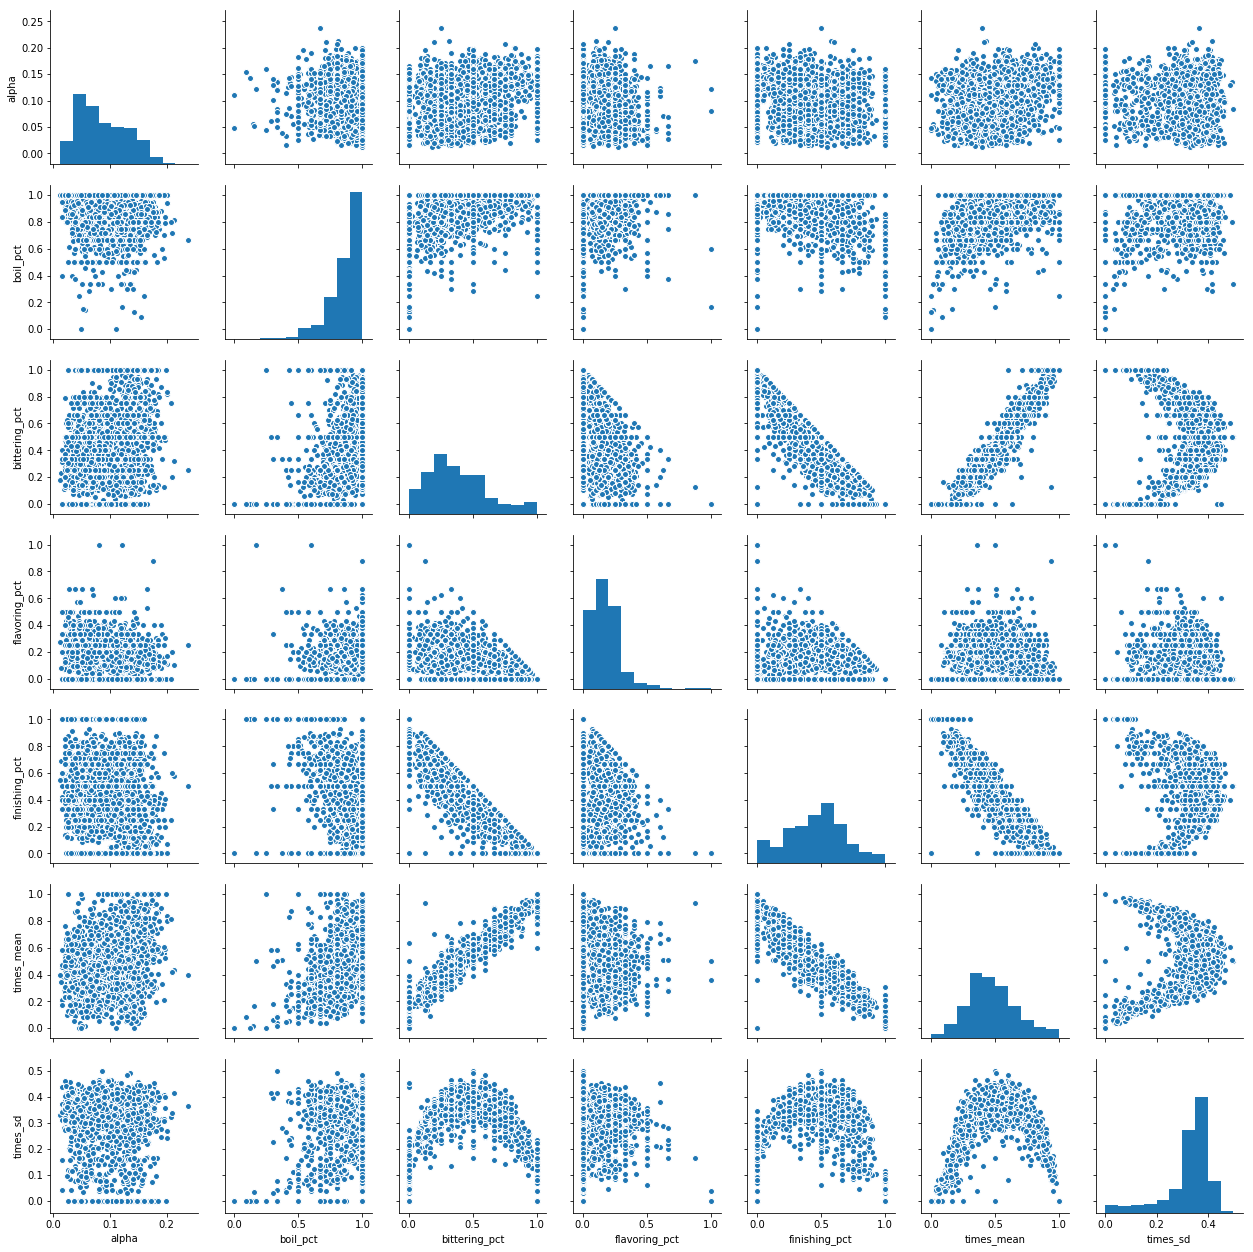

In [316]:
sns.pairplot(Xh2)

In [317]:
Xh2['boil_pct'] = Xh2['boil_pct']*Xh2['boil_pct']

In [318]:
Xh2_sc=StandardScaler().fit_transform(Xh2)

In [319]:
hop2_tsne = TSNE(perplexity=15)
Xh2_tsne = hop2_tsne.fit_transform(Xh2_sc)

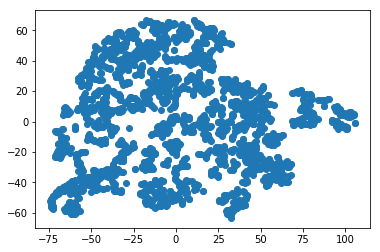

In [320]:
plt.scatter(Xh2_tsne[:,0], Xh2_tsne[:,1])

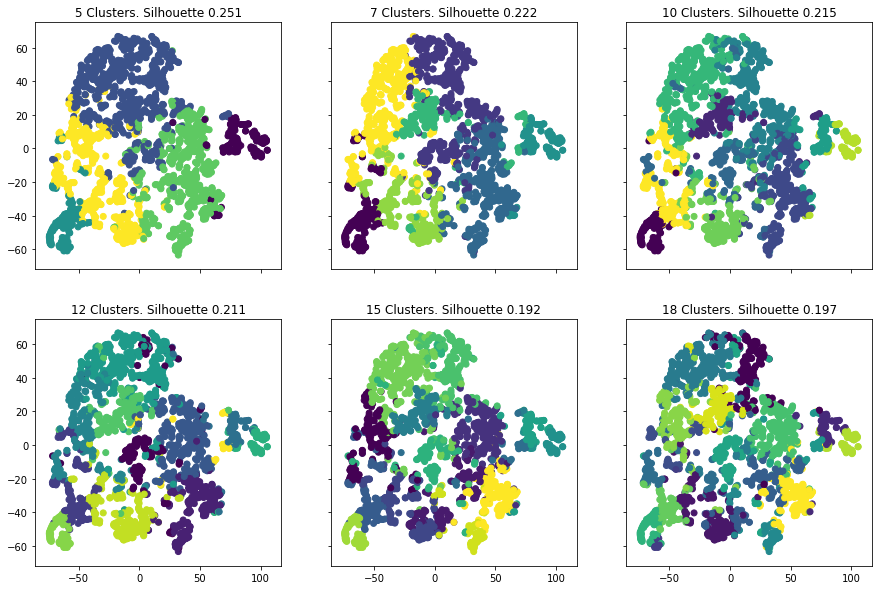

In [323]:
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,10))
for i, k in enumerate([5, 7, 10, 12, 15, 18]):
    kmeans=KMeans(n_clusters=k)
    km_labels = kmeans.fit_predict(Xh2_sc)
    ax[i//3, i%3].scatter(Xh2_tsne[:,0], Xh2_tsne[:, 1], c=km_labels)
    score = round(silhouette_score(Xh2_sc, km_labels), 3)
    ax[i//3, i%3].set_title(f'{k} Clusters. Silhouette {score}')

6494.006412147391


5    751
0    685
4    277
3    231
2    200
1    132
6    114
dtype: int64

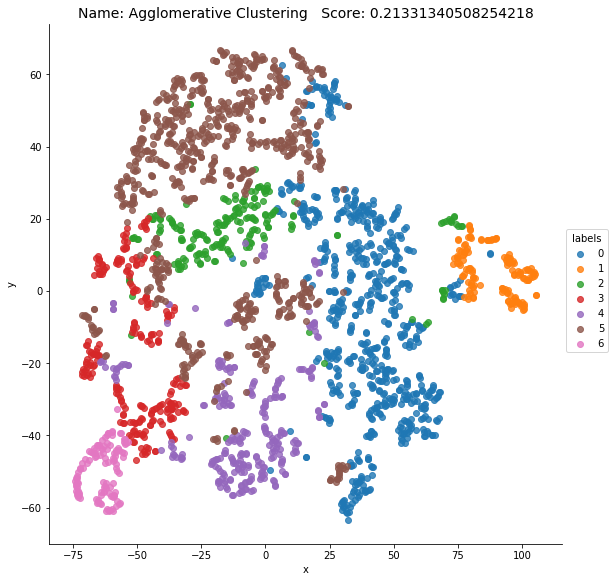

In [333]:
agg3 = AgglomerativeClustering(n_clusters=7)
cluster_eval(agg3, 'Agglomerative Clustering', Xh2_sc, Xh2_tsne)

1512.7661572487068


12    71
26    70
7     60
59    56
30    54
22    54
72    53
23    52
25    52
20    47
48    46
10    46
18    45
14    45
0     45
5     44
52    43
13    42
35    41
6     40
9     39
2     37
62    36
4     35
81    35
89    34
15    34
11    33
24    31
38    30
      ..
93    14
50    13
17    13
73    13
39    13
45    12
87    12
96    12
33    11
92    11
71    11
3     10
57    10
47     9
54     9
43     9
94     9
98     8
61     8
97     7
79     7
78     6
63     5
68     4
80     4
90     4
76     2
99     2
41     1
55     1
Length: 100, dtype: int64

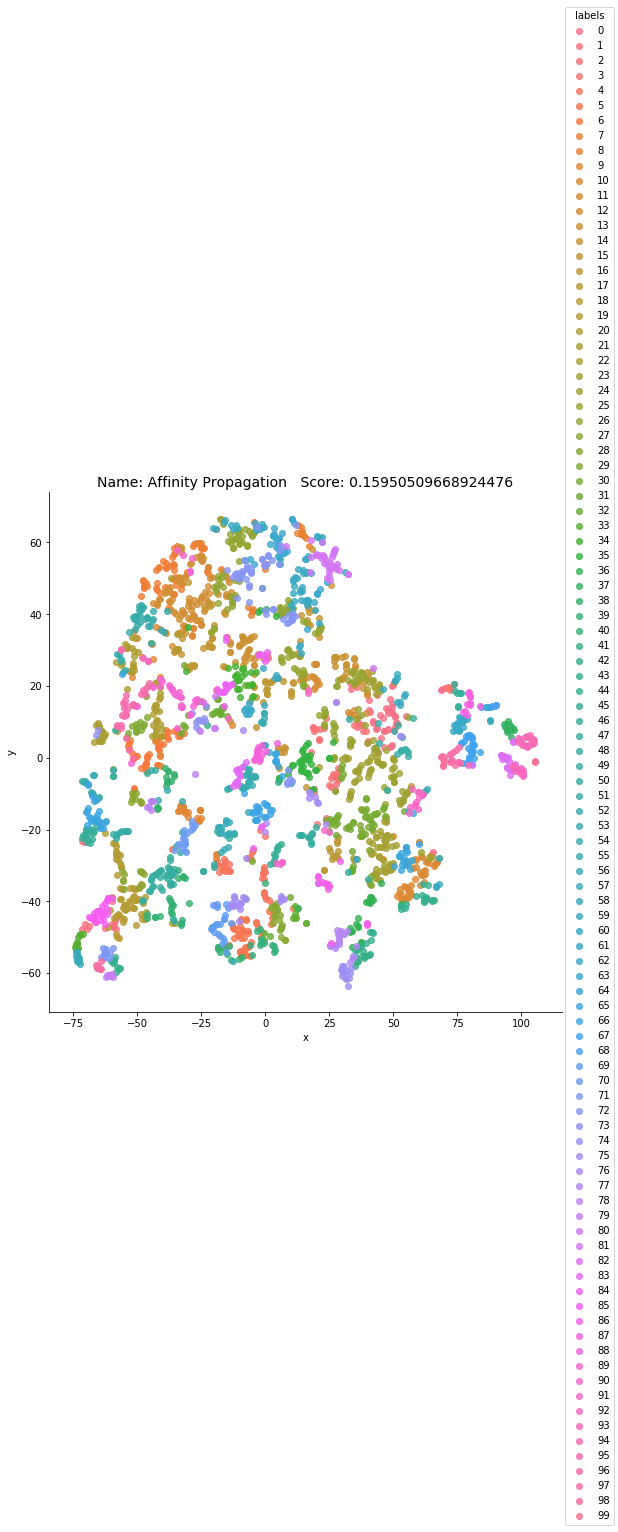

In [334]:
aff3 = AffinityPropagation()
cluster_eval(aff3, 'Affinity Propagation', Xh2_sc, Xh2_tsne)

/anaconda3/lib/python3.6/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


6314.5957946052085


6    625
4    487
5    361
2    247
0    198
1    193
3    170
7    109
dtype: int64

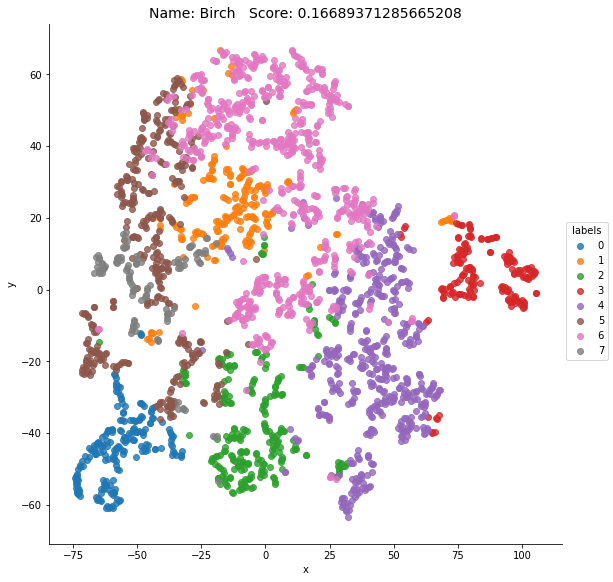

In [344]:
birch3 = Birch(n_clusters=8)
cluster_eval(birch3, 'Birch', Xh2_sc, Xh2_tsne)

14241.197574972162


 6    1379
-1     898
 5      28
 4      21
 2      21
 0      16
 1      14
 3      13
dtype: int64

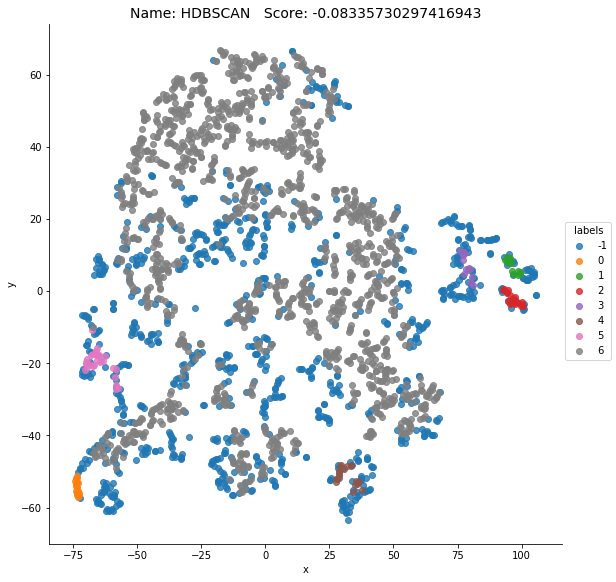

In [345]:
hdb3 = HDBSCAN()
cluster_eval(hdb3, 'HDBSCAN', Xh2_sc, Xh2_tsne)

## Creating Final Recipe DataFrame

To create the final dataframe for the recipes, I'll use the clustering labels from the aggregated data

In [347]:
grains['cluster_labels'].value_counts()

3     32
10    27
5     27
4     27
15    24
11    22
2     22
12    13
9     12
1     10
0      8
13     7
8      6
14     5
6      5
7      4
Name: cluster_labels, dtype: int64

In [349]:
hops['cluster_label'].value_counts()

3    45
6    26
8    22
2    22
9    21
1    13
7    12
0     3
4     2
5     1
Name: cluster_label, dtype: int64

In [350]:
for i in range(10):
    col_name = 'hop_cluster_'+str(i)
    df[col_name]=0
for i in range(16):
    col_name = 'fermentable_cluster'+str(i)
    df[col_name]=0

In [354]:
for i in tqdm(df.index):
    f = df.loc[i, 'fermentables']
    for j in f.values():
        cluster = grains.loc[j['name'], 'cluster_labels']
        col_name = 'fermentable_cluster'+str(cluster)
        df.loc[i, col_name] += j['amount']
    h = df.loc[i, 'hops']
    for j in h.values():
        cluster = hops.loc[j['name'], 'cluster_label']
        col_name = 'hop_cluster_'+str(cluster)
        df.loc[i, col_name] += j['amount']

100%|██████████| 73055/73055 [05:49<00:00, 209.12it/s]


In [359]:
df.shape

(73055, 42)

In [360]:
df.head()

ABV     FG  IBU     OG  SRM  boil_time  \
0  0.055  1.012   36  1.054    4        105   
1  0.060  1.014   15  1.060    4         60   
2  0.052  1.016   26  1.056    6         60   
3  0.051  1.014   57  1.053    5         60   
4  0.111  1.030  146  1.115   57         90   

                                        fermentables  \
0  {0: {'amount': 4.517919877401726, 'name': 'whe...   
1  {0: {'amount': 6.666666666666666, 'name': 'pil...   
2  {0: {'amount': 4.761904761904763, 'name': 'two...   
3  {0: {'amount': 9.09090909090909, 'name': 'two ...   
4  {0: {'amount': 14.0, 'name': 'two row', 'malts...   

                                                hops  \
0  {0: {'amount': 0.22589599387008633, 'name': 'a...   
1  {0: {'amount': 1.0, 'name': 'liberty us', 'tim...   
2  {0: {'amount': 1.1904761904761907, 'name': 'wa...   
3  {0: {'amount': 0.45454545454545453, 'name': 'c...   
4  {0: {'amount': 2.0, 'name': 'centennial us', '...   

                                                link  meets_guidelines  \
0  http://www.brewtoad.com/recipes/frances-summer...                 0   
1       http://www.brewtoad.com/recipes/belgian-whit                 0   
2  http://www.brewtoad.com/recipes/russian-german...                 0   
3         http://www.brewtoad.com/recipes/baldy-pale                 0   
4       http://www.brewtoad.com/recipes/danger-stout                 0   

           ...           fermentable_cluster6 fermentable_cluster7  \
0          ...                            0.0                  0.0   
1          ...                            0.0                  0.0   
2          ...                            0.0                  0.0   
3          ...                            0.0                  0.0   
4          ...                            0.0                  0.0   

   fermentable_cluster8 fermentable_cluster9  fermentable_cluster10  \
0                   0.0                  0.0                    0.0   
1                   0.0                  0.0                    0.0   
2                   0.0                  0.0                    0.0   
3                   0.0                  0.0                    0.0   
4                   0.0                  0.0                    0.0   

   fermentable_cluster11  fermentable_cluster12  fermentable_cluster13  \
0               0.000000                    0.0                    0.0   
1               0.000000                    0.0                    0.0   
2               0.000000                    0.0                    0.0   
3               0.454545                    0.0                    0.0   
4               4.000000                    0.0                    0.0   

   fermentable_cluster14  fermentable_cluster15  
0                    0.0                    0.0  
1                    0.0                    0.0  
2                    0.0                    0.0  
3                    0.0                    0.0  
4                    0.0                    1.0  

[5 rows x 42 columns]

In [391]:
X = df.drop(['boil_time', 'fermentables', 'hops', 'link', 'name', 'meets_guidelines', 'yeast', 'volume', 'style'], axis=1)

In [392]:
X.shape

(73055, 33)

In [393]:
X.head()

ABV     FG  IBU     OG  SRM  total_fermentables  total_hops  \
0  0.055  1.012   36  1.054    4            9.505703    4.230038   
1  0.060  1.014   15  1.060    4           11.000000    1.333333   
2  0.052  1.016   26  1.056    6           10.317460    1.984127   
3  0.051  1.014   57  1.053    5           10.000000    4.090909   
4  0.111  1.030  146  1.115   57           22.560000   11.000000   

   hop_cluster_0  hop_cluster_1  hop_cluster_2          ...            \
0            0.0            0.0            0.0          ...             
1            0.0            0.0            0.0          ...             
2            0.0            0.0            0.0          ...             
3            0.0            0.0            0.0          ...             
4            0.0            0.0            0.0          ...             

   fermentable_cluster6  fermentable_cluster7  fermentable_cluster8  \
0                   0.0                   0.0                   0.0   
1                   0.0                   0.0                   0.0   
2                   0.0                   0.0                   0.0   
3                   0.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   

   fermentable_cluster9  fermentable_cluster10  fermentable_cluster11  \
0                   0.0                    0.0               0.000000   
1                   0.0                    0.0               0.000000   
2                   0.0                    0.0               0.000000   
3                   0.0                    0.0               0.454545   
4                   0.0                    0.0               4.000000   

   fermentable_cluster12  fermentable_cluster13  fermentable_cluster14  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   fermentable_cluster15  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    1.0  

[5 rows x 33 columns]

In [396]:
non_ingr_cols = ['ABV', 'FG', 'IBU', 'OG', 'SRM', 'total_fermentables', 'total_hops']
X_non_ingr = X[non_ingr_cols]
X_non_ingr_sc = StandardScaler().fit_transform(X_non_ingr)
X_non_ingr_sc = pd.DataFrame(X_non_ingr_sc, columns=non_ingr_cols, index=X.index)

In [397]:
for col in X_non_ingr_sc.columns:
    X[col] = X_non_ingr_sc[col]

In [399]:
X.to_csv('../Ignore/recipes_fully_clean.csv')

In [ ]:
recipe_tsne = TSNE()
X_tsne = recipe_tsne.fit_transform(X)

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])